# Data Mining Assignment

## Road Traffic Accident Analysis – 2020

This project investigates road traffic accidents in Great Britain using real-world data from the year 2020. The dataset includes detailed information about each reported accident, including vehicles involved and casualties. The purpose of this analysis is to uncover meaningful insights from the data and demonstrate data mining techniques.

### Dataset Source
The data is sourced from the UK Department for Transport and contains records of all reported road traffic accidents for the year 2020.


In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from itertools import product
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import DBSCAN   
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score

### Loading the Database

We begin by connecting to the SQLite database which contains multiple related tables: `accident`, `vehicle`, `casualty`, and `lsoa`. These tables contain structured data about each accident, including the vehicles involved and the locations.


In [171]:
try:
    con = sqlite3.connect("accident_data_v1.0.0_2023.db")
    cur = con.cursor()
    print('database connection successful')
except:
    print('error connecting to database')

database connection successful


In [172]:
tables = ["accident", "vehicle", "casualty","lsoa"]
for table in tables:
    count = cur.execute(f"SELECT COUNT(*) FROM {table}").fetchone()[0]
    print(f"{table}: {count}")

accident: 461352
vehicle: 849091
casualty: 600332
lsoa: 34378


### Check Table Info

checking all the columns in accident table

In [173]:
col_info = cur.execute("PRAGMA table_info(accident)")
col_info.fetchall()

[(0, 'accident_index', '', 0, None, 1),
 (1, 'accident_year', '', 0, None, 0),
 (2, 'accident_reference', '', 0, None, 0),
 (3, 'location_easting_osgr', '', 0, None, 0),
 (4, 'location_northing_osgr', '', 0, None, 0),
 (5, 'longitude', '', 0, None, 0),
 (6, 'latitude', '', 0, None, 0),
 (7, 'police_force', '', 0, None, 0),
 (8, 'accident_severity', '', 0, None, 0),
 (9, 'number_of_vehicles', '', 0, None, 0),
 (10, 'number_of_casualties', '', 0, None, 0),
 (11, 'date', '', 0, None, 0),
 (12, 'day_of_week', '', 0, None, 0),
 (13, 'time', '', 0, None, 0),
 (14, 'local_authority_district', '', 0, None, 0),
 (15, 'local_authority_ons_district', '', 0, None, 0),
 (16, 'local_authority_highway', '', 0, None, 0),
 (17, 'first_road_class', '', 0, None, 0),
 (18, 'first_road_number', '', 0, None, 0),
 (19, 'road_type', '', 0, None, 0),
 (20, 'speed_limit', '', 0, None, 0),
 (21, 'junction_detail', '', 0, None, 0),
 (22, 'junction_control', '', 0, None, 0),
 (23, 'second_road_class', '', 0, None,

check the primary and foreign keys in all the tables

In [5]:
def get_table_schema(table_name):
    cur.execute(f"PRAGMA table_info({table_name});")
    columns = cur.fetchall()
    print(f"\n Table Name: {table_name}")
    print(f"Columns: ")
    for col in columns:
        col_name = col[1]  # Column name
        col_type = col[2] if col[2] else "UNKNOWN"  # Column type (handle empty case)
        print(f"  - {col_name} ({col_type})", end="")  
        if col[5]:  # col[5] indicates if it's a primary key
            print(" [PRIMARY KEY]", end="")
        print()
    cur.execute(f"PRAGMA foreign_key_list({table_name});")
    foreign_keys = cur.fetchall()
    if foreign_keys:
        print("\nForeign Keys:")
        for fk in foreign_keys:
            print(f"  - Column '{fk[3]}' references '{fk[2]}' table on column '{fk[4]}'")

In [6]:
tables = ["accident", "vehicle", "casualty","lsoa"]
# Get schema for each table
for table in tables:
    get_table_schema(table)



 Table Name: accident
Columns: 
  - accident_index (UNKNOWN) [PRIMARY KEY]
  - accident_year (UNKNOWN)
  - accident_reference (UNKNOWN)
  - location_easting_osgr (UNKNOWN)
  - location_northing_osgr (UNKNOWN)
  - longitude (UNKNOWN)
  - latitude (UNKNOWN)
  - police_force (UNKNOWN)
  - accident_severity (UNKNOWN)
  - number_of_vehicles (UNKNOWN)
  - number_of_casualties (UNKNOWN)
  - date (UNKNOWN)
  - day_of_week (UNKNOWN)
  - time (UNKNOWN)
  - local_authority_district (UNKNOWN)
  - local_authority_ons_district (UNKNOWN)
  - local_authority_highway (UNKNOWN)
  - first_road_class (UNKNOWN)
  - first_road_number (UNKNOWN)
  - road_type (UNKNOWN)
  - speed_limit (UNKNOWN)
  - junction_detail (UNKNOWN)
  - junction_control (UNKNOWN)
  - second_road_class (UNKNOWN)
  - second_road_number (UNKNOWN)
  - pedestrian_crossing_human_control (UNKNOWN)
  - pedestrian_crossing_physical_facilities (UNKNOWN)
  - light_conditions (UNKNOWN)
  - weather_conditions (UNKNOWN)
  - road_surface_conditions

# Fetch Data From Tables

getting data from lsoa separately since no accident_year column defined in the lsoa table

### Filtering for the Year 2020

Although the dataset may contain multiple years, we are interested in analyzing data specifically for the year 2020.
Getting Data for accident, vehicle and casualty tables in the function below

In [7]:
# Function to get data for the year 2020
def get_data_for_2020(table_name):
    cur.execute(f"SELECT * FROM {table_name} WHERE accident_year = 2020")
    data = cur.fetchall()  # Retrieve all matching rows
    cur.execute(f"PRAGMA table_info({table_name})")
    columns = [row[1] for row in cur.fetchall()]
    df = pd.DataFrame(data, columns = columns)
    return df

# Get data for each table
accident_data = get_data_for_2020("accident")
vehicle_data = get_data_for_2020("vehicle")
casualty_data = get_data_for_2020("casualty")

# Print the number of rows extracted for 2020
print(f"Accident Data (2020): {accident_data.head()} ")
print(f"Vehicle Data (2020): {vehicle_data.head()} ")
print(f"Casualty Data (2020): {casualty_data.head()} ")

Accident Data (2020):   accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  ...  \
0                  3                   1  ...   
1                  3      

In [8]:

query = '''
SELECT l.*
FROM accident AS a
JOIN lsoa AS l
ON a.lsoa_of_accident_location = l.lsoa01cd
WHERE a.accident_year = 2020
'''

cur.execute(query)
data = cur.fetchall()
cur.execute('PRAGMA table_info(lsoa)')
lsoa_cols = [row[1] for row in cur.fetchall()]
lsoa_data = pd.DataFrame(data, columns=lsoa_cols)
lsoa_data.head()


objectid   lsoa01cd          lsoa01nm         lsoa01nmw    shape__area  \
0      4576  E01004576   Wandsworth 013D   Wandsworth 013D  445625.061623   
1      3034  E01003034      Lambeth 012A      Lambeth 012A  114698.446686   
2      4726  E01004726  Westminster 003C  Westminster 003C  185726.854301   
3      3617  E01003617       Newham 012B       Newham 012B  232690.613373   
4      4763  E01004763  Westminster 013B  Westminster 013B  293663.772385   

   shape__length                              globalid  
0    4486.701130  c7ddebfb-d730-4be6-b67e-938adb21309e  
1    1719.140860  cb2e7f50-252f-469e-9b13-a56794f5d5d6  
2    2698.692831  e5cccc5e-7d0c-4f89-82c3-2a5d03b1ae18  
3    3013.438191  3e1979c9-8863-4982-afa5-7a6de00635d7  
4    4706.823542  94474f4a-0fea-4630-9173-e8fdbb834c34

In [9]:
accident_data.head()

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  ...  \
0                  3                   1  ...   
1                  3                   1  ...   
2                  3                   1  ...   
3                  2                   1  ...   
4                  3                   1  ...   

   pedestrian_crossing_physical_facilities light_conditions  \
0                                        9                1   
1                                        4                1   
2                                        0                4   
3                                        4                4   
4                                        0                4   

   weather_conditions road_surface_conditions  special_conditions_at_site  \
0                   9                       9                           0   
1                   1                       1                           0   
2                   1                       2                           0   
3                   1                       1                           0   
4                   1                       1                           0   

  carriageway_hazards urban_or_rural_area  \
0                   0                   1   
1                   0                   1   
2                   0                   1   
3                   0                   1   
4                   0                   1   

   did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                            3                2   
1                                            1                2   
2                                            1                2   
3                                            1                2   
4                                            1                2   

   lsoa_of_accident_location  
0                  E01004576  
1                  E01003034  
2                  E01004726  
3                  E01003617  
4                  E01004763  

[5 rows x 36 columns]

In [10]:
accident_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

In [11]:
accident_data.isnull().sum()

accident_index                                  0
accident_year                                   0
accident_reference                              0
location_easting_osgr                          14
location_northing_osgr                         14
longitude                                      14
latitude                                       14
police_force                                    0
accident_severity                               0
number_of_vehicles                              0
number_of_casualties                            0
date                                            0
day_of_week                                     0
time                                            0
local_authority_district                        0
local_authority_ons_district                    0
local_authority_highway                         0
first_road_class                                0
first_road_number                               0
road_type                                       0


In [12]:
accident_data['accident_severity'].unique()

array([3, 2, 1])

In [13]:
accident_data['day_of_week'].unique()

array([3, 2, 4, 5, 6, 7, 1])

In [14]:
categorical_cols = [
    'accident_severity', 'day_of_week', 'road_type', 'junction_detail',
    'junction_control', 'pedestrian_crossing_human_control',
    'pedestrian_crossing_physical_facilities', 'light_conditions',
    'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site',
    'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
    'trunk_road_flag'
]

for col in categorical_cols:
    print(f"\n{col}:\n", accident_data[col].value_counts(dropna=False))



accident_severity:
 accident_severity
3    71453
2    18355
1     1391
Name: count, dtype: int64

day_of_week:
 day_of_week
6    14889
5    14056
4    13564
3    13267
2    12772
7    12336
1    10315
Name: count, dtype: int64

road_type:
 road_type
6    66929
3    13206
1     5580
9     2006
2     1966
7     1512
Name: count, dtype: int64

junction_detail:
 junction_detail
 0     37978
 3     25626
 6      8429
 1      7326
 9      4705
 8      1887
 99     1508
 2      1300
 7      1279
 5      1159
-1         2
Name: count, dtype: int64

junction_control:
 junction_control
 4    39998
-1    38298
 2    10407
 9     1536
 3      583
 1      377
Name: count, dtype: int64

pedestrian_crossing_human_control:
 pedestrian_crossing_human_control
 0    86358
 9     3332
 2      980
 1      386
-1      143
Name: count, dtype: int64

pedestrian_crossing_physical_facilities:
 pedestrian_crossing_physical_facilities
 0    69269
 5     7465
 4     4903
 1     3836
 9     2932
 8     2460
 7    

In [15]:
accident_data[['number_of_vehicles', 'number_of_casualties', 'speed_limit']].describe()

number_of_vehicles  number_of_casualties   speed_limit
count        91199.000000          91199.000000  91199.000000
mean             1.835272              1.267382     36.270113
std              0.677272              0.681473     13.896032
min              1.000000              1.000000     -1.000000
25%              1.000000              1.000000     30.000000
50%              2.000000              1.000000     30.000000
75%              2.000000              1.000000     40.000000
max             13.000000             41.000000     70.000000

In [16]:
vehicle_data.head()

vehicle_index accident_index  accident_year accident_reference  \
0         681716  2020010219808           2020          010219808   
1         681717  2020010220496           2020          010220496   
2         681718  2020010228005           2020          010228005   
3         681719  2020010228006           2020          010228006   
4         681720  2020010228011           2020          010228011   

   vehicle_reference  vehicle_type  towing_and_articulation  \
0                  1             9                        9   
1                  1             9                        0   
2                  1             9                        0   
3                  1             8                        0   
4                  1             9                        0   

   vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
0                  5                       1                     5  ...   
1                  4                       2                     6  ...   
2                 18                      -1                    -1  ...   
3                 18                       1                     5  ...   
4                 18                       3                     7  ...   

   journey_purpose_of_driver  sex_of_driver  age_of_driver  \
0                          6              2             32   
1                          2              1             45   
2                          6              3             -1   
3                          1              1             44   
4                          6              1             20   

   age_band_of_driver  engine_capacity_cc  propulsion_code  age_of_vehicle  \
0                   6                1968                2               6   
1                   7                1395                1               2   
2                  -1                  -1               -1              -1   
3                   7                1798                8               8   
4                   4                2993                2               4   

   generic_make_model  driver_imd_decile  driver_home_area_type  
0             AUDI Q5                  4                      1  
1             AUDI A1                  7                      1  
2                  -1                 -1                     -1  
3        TOYOTA PRIUS                  2                      1  
4        BMW 4 SERIES                 -1                     -1  

[5 rows x 28 columns]

In [17]:
vehicle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167375 entries, 0 to 167374
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   vehicle_index                     167375 non-null  int64 
 1   accident_index                    167375 non-null  object
 2   accident_year                     167375 non-null  int64 
 3   accident_reference                167375 non-null  object
 4   vehicle_reference                 167375 non-null  int64 
 5   vehicle_type                      167375 non-null  int64 
 6   towing_and_articulation           167375 non-null  int64 
 7   vehicle_manoeuvre                 167375 non-null  int64 
 8   vehicle_direction_from            167375 non-null  int64 
 9   vehicle_direction_to              167375 non-null  int64 
 10  vehicle_location_restricted_lane  167375 non-null  int64 
 11  junction_location                 167375 non-null  int64 
 12  sk

In [18]:
casualty_data.head()

casualty_index accident_index  accident_year accident_reference  \
0          484748  2020010219808           2020          010219808   
1          484749  2020010220496           2020          010220496   
2          484750  2020010220496           2020          010220496   
3          484751  2020010228005           2020          010228005   
4          484752  2020010228006           2020          010228006   

   vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
0                  1                   1               3                1   
1                  1                   1               3                2   
2                  1                   2               3                2   
3                  1                   1               3                1   
4                  1                   1               3                1   

   age_of_casualty  age_band_of_casualty  casualty_severity  \
0               31                     6                  3   
1                2                     1                  3   
2                4                     1                  3   
3               23                     5                  3   
4               47                     8                  2   

   pedestrian_location  pedestrian_movement  car_passenger  \
0                    9                    5              0   
1                    1                    1              0   
2                    1                    1              0   
3                    5                    9              0   
4                    4                    1              0   

   bus_or_coach_passenger  pedestrian_road_maintenance_worker  casualty_type  \
0                       0                                   0              0   
1                       0                                   0              0   
2                       0                                   0              0   
3                       0                                   0              0   
4                       0                                   0              0   

   casualty_home_area_type  casualty_imd_decile  
0                        1                    4  
1                        1                    2  
2                        1                    2  
3                        1                    3  
4                        1                    3

In [19]:
vehicle_data.isnull().sum()

vehicle_index                       0
accident_index                      0
accident_year                       0
accident_reference                  0
vehicle_reference                   0
vehicle_type                        0
towing_and_articulation             0
vehicle_manoeuvre                   0
vehicle_direction_from              0
vehicle_direction_to                0
vehicle_location_restricted_lane    0
junction_location                   0
skidding_and_overturning            0
hit_object_in_carriageway           0
vehicle_leaving_carriageway         0
hit_object_off_carriageway          0
first_point_of_impact               0
vehicle_left_hand_drive             0
journey_purpose_of_driver           0
sex_of_driver                       0
age_of_driver                       0
age_band_of_driver                  0
engine_capacity_cc                  0
propulsion_code                     0
age_of_vehicle                      0
generic_make_model                  0
driver_imd_d

In [20]:
casualty_data.isnull().sum()

casualty_index                        0
accident_index                        0
accident_year                         0
accident_reference                    0
vehicle_reference                     0
casualty_reference                    0
casualty_class                        0
sex_of_casualty                       0
age_of_casualty                       0
age_band_of_casualty                  0
casualty_severity                     0
pedestrian_location                   0
pedestrian_movement                   0
car_passenger                         0
bus_or_coach_passenger                0
pedestrian_road_maintenance_worker    0
casualty_type                         0
casualty_home_area_type               0
casualty_imd_decile                   0
dtype: int64

### merge vehicle, accident and casualty dataframes for future use

In [21]:
merged_df = pd.merge(vehicle_data, accident_data, on='accident_index', how='inner')

merged_df

vehicle_index accident_index  accident_year_x accident_reference_x  \
0              681716  2020010219808             2020            010219808   
1              681717  2020010220496             2020            010220496   
2              681718  2020010228005             2020            010228005   
3              681719  2020010228006             2020            010228006   
4              681720  2020010228011             2020            010228011   
...               ...            ...              ...                  ...   
167370         849086  2020991030297             2020            991030297   
167371         849087  2020991030297             2020            991030297   
167372         849088  2020991030900             2020            991030900   
167373         849089  2020991030900             2020            991030900   
167374         849090  2020991032575             2020            991032575   

        vehicle_reference  vehicle_type  towing_and_articulation  \
0                       1             9                        9   
1                       1             9                        0   
2                       1             9                        0   
3                       1             8                        0   
4                       1             9                        0   
...                   ...           ...                      ...   
167370                  1             9                        0   
167371                  2             5                        0   
167372                  1             9                        0   
167373                  2             1                        0   
167374                  1             9                        0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
0                       5                       1                     5  ...   
1                       4                       2                     6  ...   
2                      18                      -1                    -1  ...   
3                      18                       1                     5  ...   
4                      18                       3                     7  ...   
...                   ...                     ...                   ...  ...   
167370                  7                       8                     2  ...   
167371                 16                       6                     2  ...   
167372                  7                       8                     2  ...   
167373                 18                       6                     2  ...   
167374                  1                       8                     4  ...   

        pedestrian_crossing_physical_facilities  light_conditions  \
0                                             9                 1   
1                                             4                 1   
2                                             0                 4   
3                                             4                 4   
4                                             0                 4   
...                                         ...               ...   
167370                                        0                 1   
167371                                        0                 1   
167372                                        0                 1   
167373                                        0                 1   
167374                                        0                 1   

        weather_conditions  road_surface_conditions  \
0                        9                        9   
1                        1                        1   
2                        1                        2   
3                        1                        1   
4                        1                        1   
...                    ...                      ...   
167370                   1                        1   
167371                  

In [22]:
len(accident_data['accident_index'])


91199

In [23]:
len(merged_df['accident_index'])


167375

When merging accident_data and vehicle_data, both DataFrames contained columns with the same names such as accident_year and accident_reference. To avoid ambiguity, Pandas automatically adds suffixes:

_x refers to the column from the left DataFrame (accident_data)

_y refers to the column from the right DataFrame (vehicle_data)

This results in columns like accident_year_x and accident_year_y.

To resolve this and keep only the original version from accident_data, we do the following:

In [24]:
merged_df = merged_df.drop(columns=['accident_year_y', 'accident_reference_y'])
merged_df = merged_df.rename(columns={
    'accident_year_x': 'accident_year',
    'accident_reference_x': 'accident_reference'
})

Before merging, accident_index is unique in accident_data (one row per accident).
After merging with vehicle_data, duplicates appear because one accident can involve multiple vehicles.
The merge creates one row per vehicle, repeating the accident_index for each.

This is expected behavior in a one-to-many join.

In [25]:
merged_df[merged_df.duplicated('accident_index', keep=False)].sort_values('accident_index').head(10)

vehicle_index accident_index  accident_year accident_reference  \
6          681722  2020010228014           2020          010228014   
7          681723  2020010228014           2020          010228014   
8          681724  2020010228017           2020          010228017   
9          681725  2020010228017           2020          010228017   
10         681726  2020010228018           2020          010228018   
11         681727  2020010228018           2020          010228018   
12         681728  2020010228020           2020          010228020   
13         681729  2020010228020           2020          010228020   
15         681731  2020010228024           2020          010228024   
16         681732  2020010228024           2020          010228024   

    vehicle_reference  vehicle_type  towing_and_articulation  \
6                   1             9                        0   
7                   2             9                        3   
8                   1             9                        0   
9                   2             9                        0   
10                  1             9                        0   
11                  2             9                        0   
12                  1             3                        0   
13                  2             9                        0   
15                  1             9                        0   
16                  2             9                        0   

    vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
6                  18                       5                     1  ...   
7                  18                       1                     5  ...   
8                  18                       3                     7  ...   
9                   3                       3                     7  ...   
10                 18                       1                     5  ...   
11                  2                       0                     0  ...   
12                  3                       7                     3  ...   
13                  4                       7                     3  ...   
15                 18                       1                     5  ...   
16                  3                       5                     1  ...   

    pedestrian_crossing_physical_facilities  light_conditions  \
6                                         0                 4   
7                                         0                 4   
8                                         0                 4   
9                                         0                 4   
10                                        0                 4   
11                                        0                 4   
12                                        5                 4   
13                                        5                 4   
15                                        5                 4   
16                                        5                 4   

    weather_conditions  road_surface_conditions  special_conditions_at_site  \
6                    1                        2                           0   
7                    1                        2                           0   
8                    8                        2                           0   
9                    8                        2                           0   
10                   1                        1                           0   
11                   1                        1                           0   
12                   1                        1                           0   
13                   1                        1                           0   
15                   1                        2                           0   
16                   1                        2                           0   

    carriageway_hazards  urban_or_rural_area  \
6                     0                    1   
7        

#### Visualise accident severity

<Axes: title={'center': 'Accident Severity Distribution'}, xlabel='accident_severity'>

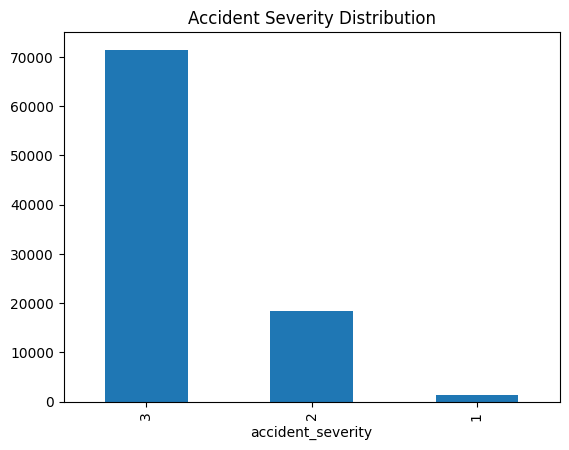

In [26]:
# Distribution of accident severity
accident_data['accident_severity'].value_counts().plot(kind='bar', title='Accident Severity Distribution')

# 1. significant hours of the day in which the accidents occur

In [27]:
df = accident_data[['day_of_week', 'time']].copy()
# Convert 'time' to datetime format to extract hour
df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour
df.head()

day_of_week   time  hour
0            3  09:00     9
1            2  13:55    13
2            4  01:25     1
3            4  01:50     1
4            4  02:25     2

In [28]:
# Group by hour and day of week
hourly_counts = df['hour'].value_counts().sort_index()
daily_counts = df['day_of_week'].value_counts().sort_index()

daily_counts

day_of_week
1    10315
2    12772
3    13267
4    13564
5    14056
6    14889
7    12336
Name: count, dtype: int64

In [29]:
hourly_counts

hour
0     1188
1      915
2      658
3      566
4      508
5      855
6     1830
7     3736
8     5267
9     3917
10    4173
11    4812
12    5395
13    5741
14    6245
15    7361
16    7381
17    7813
18    6618
19    5048
20    3715
21    3106
22    2555
23    1796
Name: count, dtype: int64

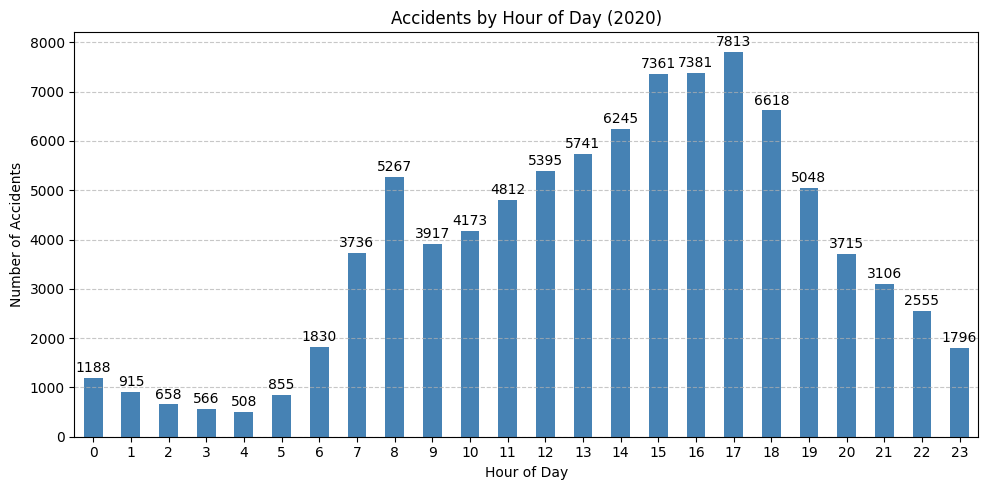

In [30]:
# Plotting hourly accident counts for 2020 with number labels
plt.figure(figsize=(10, 5))

ax = hourly_counts.plot(kind='bar', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge', padding=2)
plt.title("Accidents by Hour of Day (2020)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# plot 

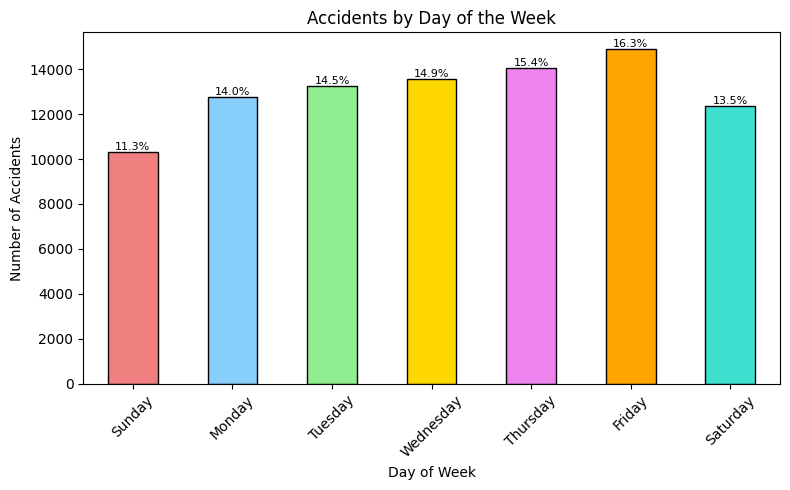

In [31]:
# Plot accidents by day of the week
plt.figure(figsize=(8, 5))

# Define labels
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_counts.index = day_labels

# Calculate total accidents for percentages
total_accidents = daily_counts.sum()

# Define a color for each day 
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'gold', 'violet', 'orange', 'turquoise']

# Plot
ax = daily_counts.plot(kind='bar', color=colors, edgecolor='black')
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)

# Add percentage labels on top of each bar
for p in ax.patches:
    percentage = 100 * p.get_height() / total_accidents
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


In [32]:
print("Top 4 Hours with Most Accidents:")
print(hourly_counts.sort_values(ascending=False).head(4))

print("\nTop 4 Days with Most Accidents:")
print(daily_counts.sort_values(ascending=False).head(4))

Top 4 Hours with Most Accidents:
hour
17    7813
16    7381
15    7361
18    6618
Name: count, dtype: int64

Top 4 Days with Most Accidents:
Friday       14889
Thursday     14056
Wednesday    13564
Tuesday      13267
Name: count, dtype: int64


#### heatmap

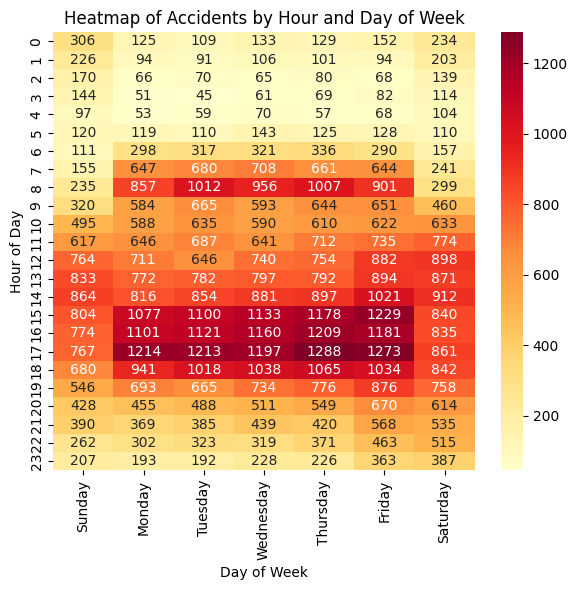

In [33]:
# Create a pivot table: index = hour, columns = day_of_week, values = count of accidents
heatmap_data = df.groupby(['hour', 'day_of_week']).size().unstack(fill_value=0)

# Reorder columns to match day_labels
day_order = [1, 2, 3, 4, 5, 6, 7]  # Monday=1 ... Sunday=7
heatmap_data = heatmap_data[day_order]

# Rename columns for better readability
heatmap_data.columns = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Plot heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt='d')
plt.title("Heatmap of Accidents by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()


## 2. Significant hours of the day and days of the week for motorcycles

In [34]:
#Motorcycle 125cc and under=03, Motorcycle over 125cc and up to 500cc=04, and Motorcycle over 500cc=05.
vehicle_types=[2,3,4,5]

df_vehicles = vehicle_data[vehicle_data['vehicle_type'].isin(vehicle_types)]

df = pd.merge(df_vehicles, accident_data, on='accident_index', how='inner')
df=df[['accident_index', 'vehicle_type', 'day_of_week', 'time']]
df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour
df.head(10)

accident_index  vehicle_type  day_of_week   time  hour
0  2020010228020             3            4  03:25     3
1  2020010228077             2            4  08:00     8
2  2020010228086             3            4  14:00    14
3  2020010228097             3            4  14:37    14
4  2020010228148             3            4  19:05    19
5  2020010228207             3            4  14:29    14
6  2020010228240             3            5  13:20    13
7  2020010228247             4            5  14:17    14
8  2020010228250             3            5  15:55    15
9  2020010228265             4            5  17:35    17

In [35]:
# Grouping data for plotting
hourly_counts = df.groupby('vehicle_type')['hour'].value_counts().unstack(fill_value=0).T
daily_counts = df.groupby('vehicle_type')['day_of_week'].value_counts().unstack(fill_value=0).T
hourly_counts

vehicle_type    2    3    4    5
hour                            
0               5   68   17   11
1               5   55   18   17
2               6   31    4    8
3               5   25    5    7
4               2   28    9    4
5               5   54   13   44
6              16  117   35   91
7              19  274   77  180
8              54  250   62  133
9              34  211   54  123
10             34  255   67  175
11             44  320   70  258
12             67  418   93  275
13             75  516  122  323
14             83  522  131  323
15             96  551  151  336
16            103  603  157  366
17            113  692  175  421
18            101  705  128  242
19             89  580   93  163
20             59  475   82  112
21             59  365   56   83
22             37  254   38   56
23             17  154   34   33

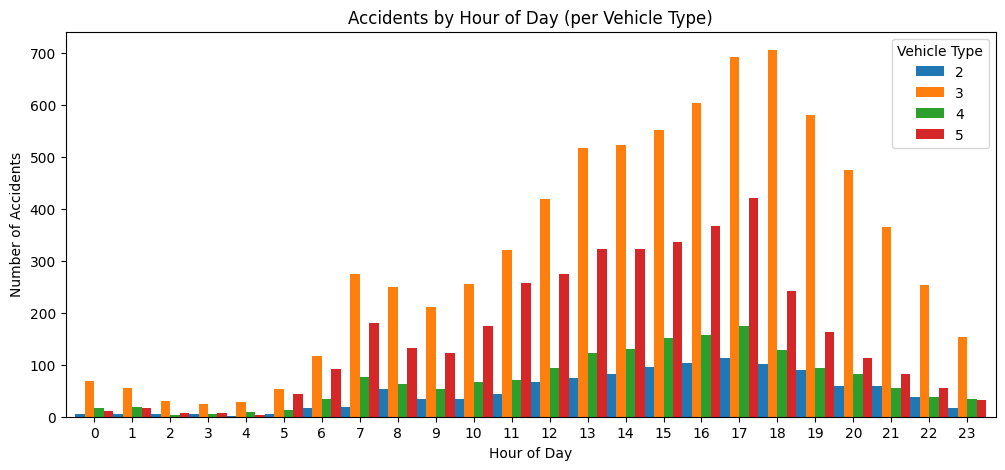

In [36]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Accidents by Hour of Day for each vehicle type

hourly_counts.plot(kind='bar', ax=plt.gca(), width=1.0)
plt.title("Accidents by Hour of Day (per Vehicle Type)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=0)
plt.legend(title="Vehicle Type", loc='upper right')

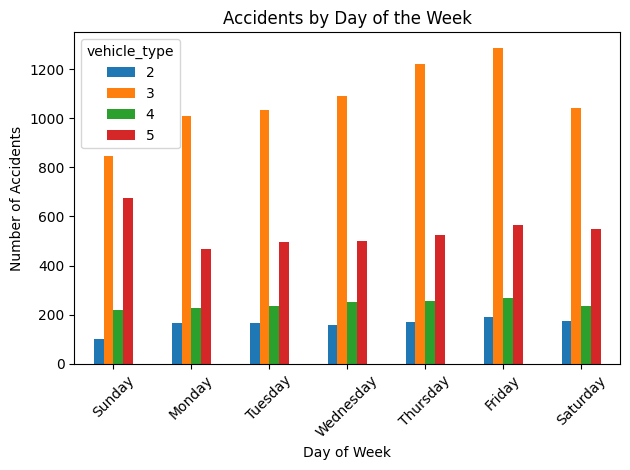

In [37]:


# Plot 2: Accidents by Day of the Week (all vehicle types combined)
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_counts.index = day_labels
daily_counts.plot(kind='bar')
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [38]:
top_hours = hourly_counts.sum(axis=1).sort_values(ascending=False).head(4)
print("Top 4 Hours with Most Accidents (all selected motorcycle types):")
print(top_hours)
top_days = daily_counts.sum(axis=1).sort_values(ascending=False).head(4)
print("Top 4 days with Most Accidents (all selected motorcycle types):")
print(top_days)

Top 4 Hours with Most Accidents (all selected motorcycle types):
hour
17    1401
16    1229
18    1176
15    1134
dtype: int64
Top 4 days with Most Accidents (all selected motorcycle types):
Friday       2308
Thursday     2172
Saturday     2003
Wednesday    2001
dtype: int64


## 3. Significant hours of the day and days of the week for accidents in which pedestrians are involved

In [39]:
pedestrian_df = casualty_data[casualty_data['casualty_class']==3] # casualty class 3 for pedestrians
df = pd.merge(pedestrian_df, accident_data, on='accident_index', how='inner')

df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour
df

casualty_index accident_index  accident_year_x accident_reference_x  \
0              484748  2020010219808             2020            010219808   
1              484749  2020010220496             2020            010220496   
2              484750  2020010220496             2020            010220496   
3              484751  2020010228005             2020            010228005   
4              484752  2020010228006             2020            010228006   
...               ...            ...              ...                  ...   
14745          600321  2020991023621             2020            991023621   
14746          600322  2020991023880             2020            991023880   
14747          600326  2020991024526             2020            991024526   
14748          600328  2020991029573             2020            991029573   
14749          600331  2020991032575             2020            991032575   

       vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
0                      1                   1               3                1   
1                      1                   1               3                2   
2                      1                   2               3                2   
3                      1                   1               3                1   
4                      1                   1               3                1   
...                  ...                 ...             ...              ...   
14745                  1                   2               3                2   
14746                  1                   1               3                2   
14747                  1                   1               3                1   
14748                  1                   1               3                2   
14749                  1                   1               3                1   

       age_of_casualty  age_band_of_casualty  ...  light_conditions  \
0                   31                     6  ...                 1   
1                    2                     1  ...                 1   
2                    4                     1  ...                 1   
3                   23                     5  ...                 4   
4                   47                     8  ...                 4   
...                ...                   ...  ...               ...   
14745               54                     8  ...                 1   
14746               58                     9  ...                 4   
14747               69                    10  ...                 1   
14748               63                     9  ...                 1   
14749               48                     8  ...                 1   

       weather_conditions  road_surface_conditions  \
0                       9                        9   
1                       1                        1   
2                       1                        1   
3                       1                        2   
4                       1                        1   
...                   ...                      ...   
14745                   9                        2   
14746                   1                        2   
14747                   2                        2   
14748                   1                        1   
14749                   1                        1   

       special_conditions_at_site  carriageway_hazards  urban_or_rural_area  \
0                               0                    0                    1   
1                               0                    0                    1   
2                               0                    0                    1   
3                               0                    0                    1   
4                               0                    0                    1   
...                           ...                  ...                  ...   
14745                           0         

In [40]:
# Grouping for visualization
hourly_countss = df['hour'].value_counts().sort_index()
daily_counts = df['day_of_week'].value_counts().sort_index()
hourly_countss

hour
0      173
1      144
2       83
3       82
4       50
5       74
6      173
7      514
8     1060
9      607
10     644
11     725
12     809
13     833
14    1015
15    1672
16    1323
17    1274
18    1146
19     824
20     518
21     412
22     365
23     230
Name: count, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

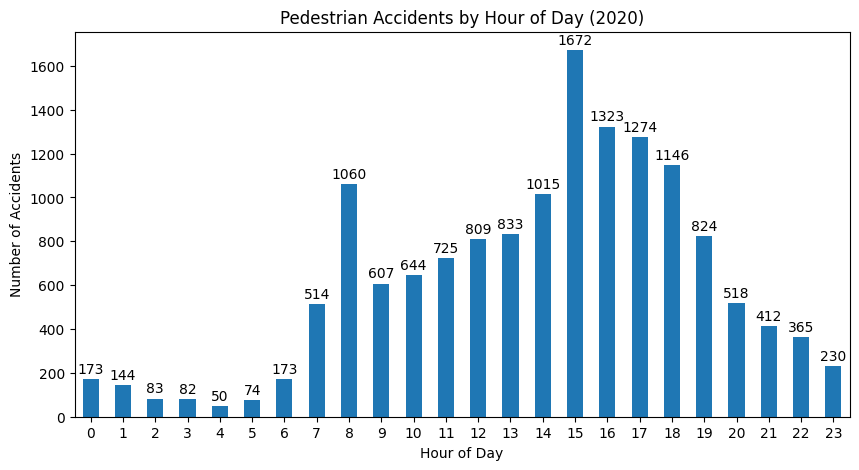

In [41]:
plt.figure(figsize=(10, 5))

# Accidents by Hour
ax=hourly_countss.plot(kind='bar')
ax.bar_label(ax.containers[0], label_type='edge', padding=2)
plt.title("Pedestrian Accidents by Hour of Day (2020)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=0)

In [42]:
daily_counts

day_of_week
1    1242
2    2207
3    2267
4    2247
5    2366
6    2543
7    1878
Name: count, dtype: int64

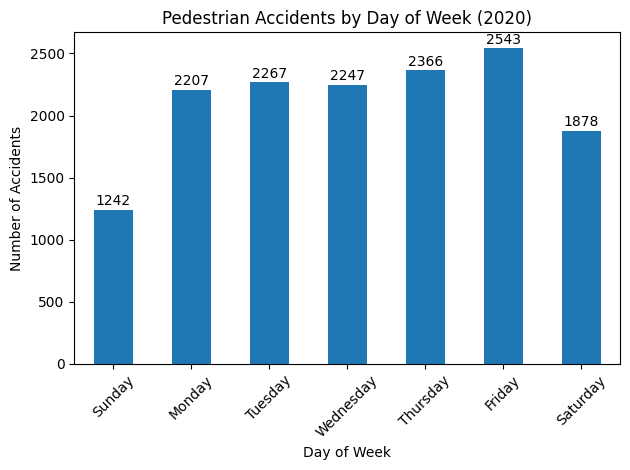

In [43]:
# Plotting


# Accidents by Day
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_counts.index = day_labels
ax = daily_counts.plot(kind='bar')
ax.bar_label(ax.containers[0], label_type='edge', padding=1)
plt.title("Pedestrian Accidents by Day of Week (2020)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 4. Apriori Algorithm

In [60]:
pip install mlxtend


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## step 1. data cleaning and manipulation

In [44]:
selected_cols = [
    'accident_severity',
    'weather_conditions',
    'light_conditions',
    'road_surface_conditions',
    'speed_limit',
]

In [45]:
df_shape = merged_df.shape[0]
df_shape

167375

In [46]:
df_apriori =merged_df[selected_cols].copy()
df_apriori

accident_severity  weather_conditions  light_conditions  \
0                       3                   9                 1   
1                       3                   1                 1   
2                       3                   1                 4   
3                       2                   1                 4   
4                       3                   1                 4   
...                   ...                 ...               ...   
167370                  2                   1                 1   
167371                  2                   1                 1   
167372                  3                   1                 1   
167373                  3                   1                 1   
167374                  3                   1                 1   

        road_surface_conditions  speed_limit  
0                             9           20  
1                             1           20  
2                             2           30  
3                             1           30  
4                             1           30  
...                         ...          ...  
167370                        1           60  
167371                        1           60  
167372                        1           30  
167373                        1           30  
167374                        1           30  

[167375 rows x 5 columns]

In [47]:
df_apriori['light_conditions'].unique()

array([ 1,  4,  5,  7,  6, -1])

In [48]:
df_apriori['road_surface_conditions'].unique()

array([ 9,  1,  2,  5,  4,  3, -1])

In [49]:
df_apriori['speed_limit'].unique()

array([20, 30, 40, 50, 60, 70, -1])

In [50]:
# Count -1 values in each column
minus_one_counts = (df_apriori[selected_cols] == -1).sum()
minus_one_counts[minus_one_counts > 0]

weather_conditions           1
light_conditions             1
road_surface_conditions    552
speed_limit                 14
dtype: int64

In [51]:
# Replace -1 with NaN first
df_apriori[['weather_conditions', 'light_conditions', 'speed_limit']] = df_apriori[
    ['weather_conditions', 'light_conditions', 'speed_limit']
].replace(-1, pd.NA)

In [52]:
df_apriori['weather_conditions'] = df_apriori['weather_conditions'].fillna(df_apriori['weather_conditions'].mode()[0])
df_apriori['light_conditions'] = df_apriori['light_conditions'].fillna(df_apriori['light_conditions'].mode()[0])
df_apriori['speed_limit'] = df_apriori['speed_limit'].fillna(df_apriori['speed_limit'].median())

/var/folders/38/qw_rrlt93hj2cg5m59k8_4yw0000gq/T/ipykernel_47374/293917304.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_apriori['weather_conditions'] = df_apriori['weather_conditions'].fillna(df_apriori['weather_conditions'].mode()[0])
/var/folders/38/qw_rrlt93hj2cg5m59k8_4yw0000gq/T/ipykernel_47374/293917304.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_apriori['light_conditions'] = df_apriori['light_conditions'].fillna(df_apriori['light_conditions'].mode()[0])
/var/folders/38/qw_rrlt93hj2cg5m59k8_4yw0000gq/T/ipykernel_47374/293917304

In [53]:
# Replace -1 with NaN for processing
df_apriori['road_surface_conditions'] = df_apriori['road_surface_conditions'].replace(-1, pd.NA)

# STEP 1: Find most common road surface condition for each weather condition
most_common_surface = (
    df_apriori[df_apriori['road_surface_conditions'].notna()]
    .groupby('weather_conditions')['road_surface_conditions']
    .agg(lambda x: x.value_counts().idxmax())
)

# STEP 2: Define a function to apply this mapping
def infer_surface(row):
    if pd.isna(row['road_surface_conditions']):
        return most_common_surface.get(row['weather_conditions'], pd.NA)
    return row['road_surface_conditions']

# STEP 3: Apply the inference
df_apriori['road_surface_conditions'] = df_apriori.apply(infer_surface, axis=1)

In [54]:
# Count -1 values in each column
minus_one_counts = (df_apriori[selected_cols] == -1).sum()
minus_one_counts[minus_one_counts > 0]

Series([], dtype: int64)

# step 2: one hot encoding

In [55]:
# One-hot encode each column with a prefix
a_severity = pd.get_dummies(df_apriori['accident_severity'], prefix='severity').astype(int)
weather = pd.get_dummies(df_apriori['weather_conditions'], prefix='weather').astype(int)
light = pd.get_dummies(df_apriori['light_conditions'], prefix='light').astype(int)
surface = pd.get_dummies(df_apriori['road_surface_conditions'], prefix='surface').astype(int)
speed = pd.get_dummies(df_apriori['speed_limit'], prefix='speed').astype(int)

# Combine all into a new DataFrame
df_encoded = pd.concat([a_severity, weather, light, surface, speed], axis=1)

# View the result
df_encoded.head()


severity_1  severity_2  severity_3  weather_1  weather_2  weather_3  \
0           0           0           1          0          0          0   
1           0           0           1          1          0          0   
2           0           0           1          1          0          0   
3           0           1           0          1          0          0   
4           0           0           1          1          0          0   

   weather_4  weather_5  weather_6  weather_7  ...  surface_3  surface_4  \
0          0          0          0          0  ...          0          0   
1          0          0          0          0  ...          0          0   
2          0          0          0          0  ...          0          0   
3          0          0          0          0  ...          0          0   
4          0          0          0          0  ...          0          0   

   surface_5  surface_9  speed_20.0  speed_30.0  speed_40.0  speed_50.0  \
0          0          1           1           0           0           0   
1          0          0           1           0           0           0   
2          0          0           0           1           0           0   
3          0          0           0           1           0           0   
4          0          0           0           1           0           0   

   speed_60.0  speed_70.0  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  

[5 rows x 29 columns]

# step3: run apriori algorithm

In [56]:
frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)
frequent_itemsets

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


support                                           itemsets
0   0.795650                                       (severity_3)
1   0.783086                                        (weather_1)
2   0.715985                                          (light_1)
3   0.206937                                          (light_4)
4   0.698730                                        (surface_1)
5   0.282055                                        (surface_2)
6   0.570127                                       (speed_30.0)
7   0.618605                            (severity_3, weather_1)
8   0.573909                              (severity_3, light_1)
9   0.555340                            (severity_3, surface_1)
10  0.224006                            (severity_3, surface_2)
11  0.465362                           (speed_30.0, severity_3)
12  0.590052                               (light_1, weather_1)
13  0.655259                             (weather_1, surface_1)
14  0.450940                            (speed_30.0, weather_1)
15  0.547417                               (light_1, surface_1)
16  0.407498                              (speed_30.0, light_1)
17  0.410372                            (speed_30.0, surface_1)
18  0.469102                   (severity_3, light_1, weather_1)
19  0.518954                 (weather_1, severity_3, surface_1)
20  0.366070                (speed_30.0, severity_3, weather_1)
21  0.436762                   (severity_3, light_1, surface_1)
22  0.335946                  (speed_30.0, severity_3, light_1)
23  0.334220                (speed_30.0, severity_3, surface_1)
24  0.516320                    (weather_1, light_1, surface_1)
25  0.339358                   (speed_30.0, light_1, weather_1)
26  0.384388                 (weather_1, speed_30.0, surface_1)
27  0.320287                   (speed_30.0, light_1, surface_1)
28  0.410557        (weather_1, severity_3, light_1, surface_1)
29  0.277628       (speed_30.0, severity_3, light_1, weather_1)
30  0.312376     (weather_1, speed_30.0, severity_3, surface_1)
31  0.262584       (speed_30.0, severity_3, light_1, surface_1)
32  0.301712        (weather_1, speed_30.0, light_1, surface_1)
33  0.246805  (weather_1, surface_1, speed_30.0, severity_3,...

In [57]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

support                                           itemsets  length
0   0.795650                                       (severity_3)       1
1   0.783086                                        (weather_1)       1
2   0.715985                                          (light_1)       1
3   0.206937                                          (light_4)       1
4   0.698730                                        (surface_1)       1
5   0.282055                                        (surface_2)       1
6   0.570127                                       (speed_30.0)       1
7   0.618605                            (severity_3, weather_1)       2
8   0.573909                              (severity_3, light_1)       2
9   0.555340                            (severity_3, surface_1)       2
10  0.224006                            (severity_3, surface_2)       2
11  0.465362                           (speed_30.0, severity_3)       2
12  0.590052                               (light_1, weather_1)       2
13  0.655259                             (weather_1, surface_1)       2
14  0.450940                            (speed_30.0, weather_1)       2
15  0.547417                               (light_1, surface_1)       2
16  0.407498                              (speed_30.0, light_1)       2
17  0.410372                            (speed_30.0, surface_1)       2
18  0.469102                   (severity_3, light_1, weather_1)       3
19  0.518954                 (weather_1, severity_3, surface_1)       3
20  0.366070                (speed_30.0, severity_3, weather_1)       3
21  0.436762                   (severity_3, light_1, surface_1)       3
22  0.335946                  (speed_30.0, severity_3, light_1)       3
23  0.334220                (speed_30.0, severity_3, surface_1)       3
24  0.516320                    (weather_1, light_1, surface_1)       3
25  0.339358                   (speed_30.0, light_1, weather_1)       3
26  0.384388                 (weather_1, speed_30.0, surface_1)       3
27  0.320287                   (speed_30.0, light_1, surface_1)       3
28  0.410557        (weather_1, severity_3, light_1, surface_1)       4
29  0.277628       (speed_30.0, severity_3, light_1, weather_1)       4
30  0.312376     (weather_1, speed_30.0, severity_3, surface_1)       4
31  0.262584       (speed_30.0, severity_3, light_1, surface_1)       4
32  0.301712        (weather_1, speed_30.0, light_1, surface_1)       4
33  0.246805  (weather_1, surface_1, speed_30.0, severity_3,...       5

In [58]:
temp = frequent_itemsets[(frequent_itemsets['length'] > 1) & (frequent_itemsets['support'] >=0.2)]
temp

support                                           itemsets  length
7   0.618605                            (severity_3, weather_1)       2
8   0.573909                              (severity_3, light_1)       2
9   0.555340                            (severity_3, surface_1)       2
10  0.224006                            (severity_3, surface_2)       2
11  0.465362                           (speed_30.0, severity_3)       2
12  0.590052                               (light_1, weather_1)       2
13  0.655259                             (weather_1, surface_1)       2
14  0.450940                            (speed_30.0, weather_1)       2
15  0.547417                               (light_1, surface_1)       2
16  0.407498                              (speed_30.0, light_1)       2
17  0.410372                            (speed_30.0, surface_1)       2
18  0.469102                   (severity_3, light_1, weather_1)       3
19  0.518954                 (weather_1, severity_3, surface_1)       3
20  0.366070                (speed_30.0, severity_3, weather_1)       3
21  0.436762                   (severity_3, light_1, surface_1)       3
22  0.335946                  (speed_30.0, severity_3, light_1)       3
23  0.334220                (speed_30.0, severity_3, surface_1)       3
24  0.516320                    (weather_1, light_1, surface_1)       3
25  0.339358                   (speed_30.0, light_1, weather_1)       3
26  0.384388                 (weather_1, speed_30.0, surface_1)       3
27  0.320287                   (speed_30.0, light_1, surface_1)       3
28  0.410557        (weather_1, severity_3, light_1, surface_1)       4
29  0.277628       (speed_30.0, severity_3, light_1, weather_1)       4
30  0.312376     (weather_1, speed_30.0, severity_3, surface_1)       4
31  0.262584       (speed_30.0, severity_3, light_1, surface_1)       4
32  0.301712        (weather_1, speed_30.0, light_1, surface_1)       4
33  0.246805  (weather_1, surface_1, speed_30.0, severity_3,...       5

### calculate confidence, lift, support 

In [59]:
def get_association_rules(metric, min_threshold, itemsets):
    rules = association_rules(itemsets, metric = metric, min_threshold=min_threshold)
    rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
    rules = rules[(rules['antecedent_len']>=2)]
    return rules

In [60]:
def get_rules_only_with_accident_severity_in_consequents(rules):
    severity_rules = rules[
        (rules['consequents'].apply(lambda x: any('severity_' in str(item) for item in x)))
    ]
    return severity_rules

In [61]:
def prettify_output(severity_rules):
    for _, row in severity_rules.iterrows():
        antecedents = ' AND '.join(sorted([str(item) for item in row['antecedents']]))
        consequents = ' AND '.join(sorted([str(item) for item in row['consequents']]))
        
        print(f"IF {antecedents} THEN {consequents} "
              f"(Support: {row['support']:.2f}, Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f})")


In [62]:
lift = get_association_rules("lift", 1.05, frequent_itemsets)
lift

antecedents                          consequents  \
6    (severity_3, weather_1)                            (light_1)   
8    (severity_3, weather_1)                          (surface_1)   
9    (severity_3, surface_1)                          (weather_1)   
12     (severity_3, light_1)                          (surface_1)   
13   (severity_3, surface_1)                            (light_1)   
..                       ...                                  ...   
105  (speed_30.0, surface_1)     (severity_3, light_1, weather_1)   
106  (severity_3, surface_1)     (speed_30.0, light_1, weather_1)   
107     (light_1, surface_1)  (speed_30.0, severity_3, weather_1)   
108    (speed_30.0, light_1)   (surface_1, severity_3, weather_1)   
109    (severity_3, light_1)   (surface_1, speed_30.0, weather_1)   

     antecedent support  consequent support   support  confidence      lift  \
6              0.618605            0.715985  0.469102    0.758323  1.059132   
8              0.618605            0.698730  0.518954    0.838911  1.200622   
9              0.555340            0.783086  0.518954    0.934481  1.193331   
12             0.573909            0.698730  0.436762    0.761030  1.089161   
13             0.555340            0.715985  0.436762    0.786477  1.098454   
..                  ...                 ...       ...         ...       ...   
105            0.410372            0.469102  0.246805    0.601418  1.282062   
106            0.555340            0.339358  0.246805    0.444422  1.309597   
107            0.547417            0.366070  0.246805    0.450853  1.231604   
108            0.407498            0.518954  0.246805    0.605659  1.167076   
109            0.573909            0.384388  0.246805    0.430042  1.118770   

     representativity  leverage  conviction  zhangs_metric   jaccard  \
6                 1.0  0.026190    1.175184       0.146386  0.542009   
8                 1.0  0.086716    1.870205       0.438124  0.650009   
9                 1.0  0.084076    3.310701       0.364345  0.633280   
12                1.0  0.035754    1.260699       0.192123  0.522519   
13                1.0  0.039147    1.330135       0.201569  0.523342   
..                ...       ...         ...            ...       ...   
105               1.0  0.054299    1.331966       0.373127  0.390101   
106               1.0  0.058346    1.189107       0.531656  0.380935   
107               1.0  0.046412    1.154391       0.415506  0.370199   
108               1.0  0.035332    1.219873       0.241616  0.363137   
109               1.0  0.026201    1.080101       0.249152  0.346884   

     certainty  kulczynski  antecedent_len  
6     0.149069    0.706754               2  
8     0.465299    0.790811               2  
9     0.697949    0.798593               2  
12    0.206790    0.693054               2  
13    0.248197    0.698246               2  
..         ...         ...             ...  
105   0.249230    0.563770               2  
106   0.159033    0.585846               2  
107   0.133742    0.562527               2  
108   0.180243    0.540620               2  
109   0.074160    0.536057               2  

[75 rows x 15 columns]

In [63]:
severity_rules = get_rules_only_with_accident_severity_in_consequents(lift)
severity_rules

antecedents                          consequents  \
40                 (light_1, weather_1)              (severity_3, surface_1)   
41               (surface_1, weather_1)                (severity_3, light_1)   
44                 (light_1, surface_1)              (severity_3, weather_1)   
50                (speed_30.0, light_1)              (severity_3, weather_1)   
51              (speed_30.0, weather_1)                (severity_3, light_1)   
59              (speed_30.0, weather_1)              (severity_3, surface_1)   
61              (speed_30.0, surface_1)              (severity_3, weather_1)   
69                (speed_30.0, light_1)              (severity_3, surface_1)   
70              (speed_30.0, surface_1)                (severity_3, light_1)   
92   (surface_1, speed_30.0, weather_1)                (severity_3, light_1)   
95     (speed_30.0, light_1, weather_1)              (severity_3, surface_1)   
98     (speed_30.0, light_1, surface_1)              (severity_3, weather_1)   
101              (surface_1, weather_1)    (speed_30.0, severity_3, light_1)   
102             (speed_30.0, weather_1)     (severity_3, light_1, surface_1)   
104                (light_1, weather_1)  (speed_30.0, severity_3, surface_1)   
105             (speed_30.0, surface_1)     (severity_3, light_1, weather_1)   
107                (light_1, surface_1)  (speed_30.0, severity_3, weather_1)   
108               (speed_30.0, light_1)   (surface_1, severity_3, weather_1)   

     antecedent support  consequent support   support  confidence      lift  \
40             0.590052            0.555340  0.410557    0.695798  1.252923   
41             0.655259            0.573909  0.410557    0.626557  1.091736   
44             0.547417            0.618605  0.410557    0.749989  1.212388   
50             0.407498            0.618605  0.277628    0.681299  1.101348   
51             0.450940            0.573909  0.277628    0.615666  1.072759   
59             0.450940            0.555340  0.312376    0.692724  1.247387   
61             0.410372            0.618605  0.312376    0.761203  1.230516   
69             0.407498            0.555340  0.262584    0.644381  1.160336   
70             0.410372            0.573909  0.262584    0.639868  1.114930   
92             0.384388            0.573909  0.246805    0.642072  1.118770   
95             0.339358            0.555340  0.246805    0.727271  1.309597   
98             0.320287            0.618605  0.246805    0.770575  1.245666   
101            0.655259            0.335946  0.246805    0.376653  1.121169   
102            0.450940            0.436762  0.246805    0.547313  1.253116   
104            0.590052            0.334220  0.246805    0.418277  1.251503   
105            0.410372            0.469102  0.246805    0.601418  1.282062   
107            0.547417            0.366070  0.246805    0.450853  1.231604   
108            0.407498            0.518954  0.246805    0.605659  1.167076   

     representativity  leverage  conviction  zhangs_metric   jaccard  \
40                1.0  0.082878    1.461726       0.492419  0.558707   
41                1.0  0.034498    1.140980       0.243741  0.501529   
44                1.0  0.071922    1.525514       0.387071  0.543449   
50                1.0  0.025548    1.196718       0.155310  0.370925   
51                1.0  0.018830    1.108648       0.123528  0.371548   
59                1.0  0.061952    1.447101       0.361206  0.450173   
61                1.0  0.058518    1.597153       0.317713  0.435914   
69                1.0  0.036284    1.250383       0.233216  0.374984   
70                1.0  0.027068    1.183154       0.174827  0.363843   
92                1.0  0.026201    1.190439       0.172449  0.346884   
95                1.0  0.058346    1.630411       0.357843  0.380935   
98                1.0  0.048674    1.662398       0.290147  0.356610   
101               1.0  0.026673    1.065303       0.313494  0.331549 

In [64]:
print("OUTPUT FOR LIFT METRIC")
prettify_output(severity_rules)

OUTPUT FOR LIFT METRIC
IF light_1 AND weather_1 THEN severity_3 AND surface_1 (Support: 0.41, Confidence: 0.70, Lift: 1.25)
IF surface_1 AND weather_1 THEN light_1 AND severity_3 (Support: 0.41, Confidence: 0.63, Lift: 1.09)
IF light_1 AND surface_1 THEN severity_3 AND weather_1 (Support: 0.41, Confidence: 0.75, Lift: 1.21)
IF light_1 AND speed_30.0 THEN severity_3 AND weather_1 (Support: 0.28, Confidence: 0.68, Lift: 1.10)
IF speed_30.0 AND weather_1 THEN light_1 AND severity_3 (Support: 0.28, Confidence: 0.62, Lift: 1.07)
IF speed_30.0 AND weather_1 THEN severity_3 AND surface_1 (Support: 0.31, Confidence: 0.69, Lift: 1.25)
IF speed_30.0 AND surface_1 THEN severity_3 AND weather_1 (Support: 0.31, Confidence: 0.76, Lift: 1.23)
IF light_1 AND speed_30.0 THEN severity_3 AND surface_1 (Support: 0.26, Confidence: 0.64, Lift: 1.16)
IF speed_30.0 AND surface_1 THEN light_1 AND severity_3 (Support: 0.26, Confidence: 0.64, Lift: 1.11)
IF speed_30.0 AND surface_1 AND weather_1 THEN light_1 AND

In [65]:
support = get_association_rules("support", 0.3, frequent_itemsets)
support

antecedents               consequents  \
20                 (severity_3, light_1)               (weather_1)   
21               (severity_3, weather_1)                 (light_1)   
22                  (light_1, weather_1)              (severity_3)   
26               (severity_3, weather_1)               (surface_1)   
27                (surface_1, weather_1)              (severity_3)   
28               (severity_3, surface_1)               (weather_1)   
32              (speed_30.0, severity_3)               (weather_1)   
33               (speed_30.0, weather_1)              (severity_3)   
34               (severity_3, weather_1)              (speed_30.0)   
38                 (severity_3, light_1)               (surface_1)   
39               (severity_3, surface_1)                 (light_1)   
40                  (light_1, surface_1)              (severity_3)   
44              (speed_30.0, severity_3)                 (light_1)   
45                 (speed_30.0, light_1)              (severity_3)   
46                 (severity_3, light_1)              (speed_30.0)   
50              (speed_30.0, severity_3)               (surface_1)   
51               (speed_30.0, surface_1)              (severity_3)   
52               (severity_3, surface_1)              (speed_30.0)   
56                  (light_1, weather_1)               (surface_1)   
57                (surface_1, weather_1)                 (light_1)   
58                  (light_1, surface_1)               (weather_1)   
62                 (speed_30.0, light_1)               (weather_1)   
63               (speed_30.0, weather_1)                 (light_1)   
64                  (light_1, weather_1)              (speed_30.0)   
68               (speed_30.0, weather_1)               (surface_1)   
69                (surface_1, weather_1)              (speed_30.0)   
70               (speed_30.0, surface_1)               (weather_1)   
74                 (speed_30.0, light_1)               (surface_1)   
75               (speed_30.0, surface_1)                 (light_1)   
76                  (light_1, surface_1)              (speed_30.0)   
80      (severity_3, light_1, weather_1)               (surface_1)   
81    (surface_1, severity_3, weather_1)                 (light_1)   
82       (surface_1, light_1, weather_1)              (severity_3)   
83      (severity_3, light_1, surface_1)               (weather_1)   
84               (severity_3, weather_1)      (light_1, surface_1)   
85                  (light_1, weather_1)   (severity_3, surface_1)   
86                (surface_1, weather_1)     (severity_3, light_1)   
87                 (severity_3, light_1)    (surface_1, weather_1)   
88               (severity_3, surface_1)      (light_1, weather_1)   
89                  (light_1, surface_1)   (severity_3, weather_1)   
94   (speed_30.0, severity_3, weather_1)               (surface_1)   
95    (surface_1, speed_30.0, weather_1)              (severity_3)   
96    (surface_1, severity_3, weather_1)              (speed_30.0)   
97   (speed_30.0, severity_3, surface_1)               (weather_1)   
98               (speed_30.0, weather_1)   (severity_3, surface_1)   
99               (severity_3, weather_1)   (speed_30.0, surface_1)   
100               (surface_1, weather_1)  (speed_30.0, severity_3)   
101             (speed_30.0, severity_3)    (surface_1, weather_1)   
102              (speed_30.0, surface_1)   (severity_3, weather_1)   
103              (severity_3, surface_1)   (speed_30.0, weather_1)   
108     (speed_30.0, light_1, weather_1)               (surface_1)   
109   (surface_1, speed_30.0, weather_1)                 (light_1)   
110      (surface_1, light_1, weather_1)              (speed_30.0)   
111     (speed_30.0, light_1, surface_1)               (weather_1)   
112              (speed_30.0, weather_1)      (light_1, surface_1)   
113                 (light_1, weather_1)   (speed_30.0, surface_1)   
114               (surface_1, weather_1

In [66]:
severity_rules = get_rules_only_with_accident_severity_in_consequents(support)
severity_rules

antecedents               consequents  \
22                 (light_1, weather_1)              (severity_3)   
27               (surface_1, weather_1)              (severity_3)   
33              (speed_30.0, weather_1)              (severity_3)   
40                 (light_1, surface_1)              (severity_3)   
45                (speed_30.0, light_1)              (severity_3)   
51              (speed_30.0, surface_1)              (severity_3)   
82      (surface_1, light_1, weather_1)              (severity_3)   
85                 (light_1, weather_1)   (severity_3, surface_1)   
86               (surface_1, weather_1)     (severity_3, light_1)   
89                 (light_1, surface_1)   (severity_3, weather_1)   
95   (surface_1, speed_30.0, weather_1)              (severity_3)   
98              (speed_30.0, weather_1)   (severity_3, surface_1)   
100              (surface_1, weather_1)  (speed_30.0, severity_3)   
102             (speed_30.0, surface_1)   (severity_3, weather_1)   

     antecedent support  consequent support   support  confidence      lift  \
22             0.590052            0.795650  0.469102    0.795018  0.999205   
27             0.655259            0.795650  0.518954    0.791984  0.995391   
33             0.450940            0.795650  0.366070    0.811794  1.020290   
40             0.547417            0.795650  0.436762    0.797859  1.002775   
45             0.407498            0.795650  0.335946    0.824412  1.036148   
51             0.410372            0.795650  0.334220    0.814431  1.023604   
82             0.516320            0.795650  0.410557    0.795161  0.999385   
85             0.590052            0.555340  0.410557    0.695798  1.252923   
86             0.655259            0.573909  0.410557    0.626557  1.091736   
89             0.547417            0.618605  0.410557    0.749989  1.212388   
95             0.384388            0.795650  0.312376    0.812658  1.021376   
98             0.450940            0.555340  0.312376    0.692724  1.247387   
100            0.655259            0.465362  0.312376    0.476722  1.024410   
102            0.410372            0.618605  0.312376    0.761203  1.230516   

     representativity  leverage  conviction  zhangs_metric   jaccard  \
22                1.0 -0.000373    0.996916      -0.001936  0.511785   
27                1.0 -0.002403    0.982372      -0.013253  0.556845   
33                1.0  0.007280    1.085779       0.036220  0.415743   
40                1.0  0.001209    1.010924       0.006115  0.481914   
45                1.0  0.011720    1.163799       0.058881  0.387391   
51                1.0  0.007707    1.101204       0.039109  0.383366   
82                1.0 -0.000253    0.997609      -0.001272  0.455460   
85                1.0  0.082878    1.461726       0.492419  0.558707   
86                1.0  0.034498    1.140980       0.243741  0.501529   
89                1.0  0.071922    1.525514       0.387071  0.543449   
95                1.0  0.006538    1.090785       0.033997  0.360021   
98                1.0  0.061952    1.447101       0.361206  0.450173   
100               1.0  0.007444    1.021709       0.069121  0.386487   
102               1.0  0.058518    1.597153       0.317713  0.435914   

     certainty  kulczynski  antecedent_len  
22   -0.003094    0.692301               2  
27   -0.017945    0.722111               2  
33    0.079002    0.635942               2  
40    0.010806    0.673398               2  
45    0.140745    0.623320               2  
51    0.091903    0.617245               2  
82   -0.002396    0.655581               3  
85    0.315877    0.717544               2  
86    0.123560    0.670963               2  
89    0.344483    0.706836               2  
95    0.083229    0.602632               3  
98    0.308963    0.627610               2  
100   0.021247    0.573988               2  
102   0.373886    0.633086               2

In [67]:
print("OUTPUT FOR SUPPORT METRIC")
prettify_output(severity_rules)

OUTPUT FOR SUPPORT METRIC
IF light_1 AND weather_1 THEN severity_3 (Support: 0.47, Confidence: 0.80, Lift: 1.00)
IF surface_1 AND weather_1 THEN severity_3 (Support: 0.52, Confidence: 0.79, Lift: 1.00)
IF speed_30.0 AND weather_1 THEN severity_3 (Support: 0.37, Confidence: 0.81, Lift: 1.02)
IF light_1 AND surface_1 THEN severity_3 (Support: 0.44, Confidence: 0.80, Lift: 1.00)
IF light_1 AND speed_30.0 THEN severity_3 (Support: 0.34, Confidence: 0.82, Lift: 1.04)
IF speed_30.0 AND surface_1 THEN severity_3 (Support: 0.33, Confidence: 0.81, Lift: 1.02)
IF light_1 AND surface_1 AND weather_1 THEN severity_3 (Support: 0.41, Confidence: 0.80, Lift: 1.00)
IF light_1 AND weather_1 THEN severity_3 AND surface_1 (Support: 0.41, Confidence: 0.70, Lift: 1.25)
IF surface_1 AND weather_1 THEN light_1 AND severity_3 (Support: 0.41, Confidence: 0.63, Lift: 1.09)
IF light_1 AND surface_1 THEN severity_3 AND weather_1 (Support: 0.41, Confidence: 0.75, Lift: 1.21)
IF speed_30.0 AND surface_1 AND weather

In [68]:
confidence = get_association_rules("confidence", 0.7, frequent_itemsets)
confidence

antecedents              consequents  \
16                           (severity_3, light_1)              (weather_1)   
17                         (severity_3, weather_1)                (light_1)   
18                            (light_1, weather_1)             (severity_3)   
19                         (severity_3, weather_1)              (surface_1)   
20                          (surface_1, weather_1)             (severity_3)   
21                         (severity_3, surface_1)              (weather_1)   
23                        (speed_30.0, severity_3)              (weather_1)   
24                         (speed_30.0, weather_1)             (severity_3)   
25                           (severity_3, light_1)              (surface_1)   
26                         (severity_3, surface_1)                (light_1)   
27                            (light_1, surface_1)             (severity_3)   
28                        (speed_30.0, severity_3)                (light_1)   
29                           (speed_30.0, light_1)             (severity_3)   
30                        (speed_30.0, severity_3)              (surface_1)   
31                         (speed_30.0, surface_1)             (severity_3)   
32                            (light_1, weather_1)              (surface_1)   
33                          (surface_1, weather_1)                (light_1)   
34                            (light_1, surface_1)              (weather_1)   
37                           (speed_30.0, light_1)              (weather_1)   
38                         (speed_30.0, weather_1)                (light_1)   
39                         (speed_30.0, weather_1)              (surface_1)   
40                         (speed_30.0, surface_1)              (weather_1)   
41                           (speed_30.0, light_1)              (surface_1)   
42                         (speed_30.0, surface_1)                (light_1)   
43                (severity_3, light_1, weather_1)              (surface_1)   
44              (surface_1, severity_3, weather_1)                (light_1)   
45                 (surface_1, light_1, weather_1)             (severity_3)   
46                (severity_3, light_1, surface_1)              (weather_1)   
47                           (severity_3, light_1)   (surface_1, weather_1)   
48                         (severity_3, surface_1)     (light_1, weather_1)   
49                            (light_1, surface_1)  (severity_3, weather_1)   
50               (speed_30.0, severity_3, light_1)              (weather_1)   
51             (speed_30.0, severity_3, weather_1)                (light_1)   
52                (speed_30.0, light_1, weather_1)             (severity_3)   
53             (speed_30.0, severity_3, weather_1)              (surface_1)   
54              (surface_1, speed_30.0, weather_1)             (severity_3)   
55             (speed_30.0, severity_3, surface_1)              (weather_1)   
56                         (speed_30.0, surface_1)  (severity_3, weather_1)   
57               (speed_30.0, severity_3, light_1)              (surface_1)   
58             (speed_30.0, severity_3, surface_1)                (light_1)   
59                (speed_30.0, light_1, surface_1)             (severity_3)   
60                (speed_30.0, light_1, weather_1)              (surface_1)   
61              (surface_1, speed_30.0, weather_1)                (light_1)   
62                (speed_30.0, light_1, surface_1)              (weather_1)   
63                           (speed_30.0, light_1)   (surface_1, weather_1)   
64                         (speed_30.0, surface_1)     (light_1, weather_1)   
65  (surface_1, speed_30.0, severity_3, weather_1)                (light_1)   
66     (surface_1, speed_30.0, light_1, weather_1)             (severity_3)   
67    (speed_30.0, severity_3, light_1, weather_1)              (surface_1)   
68    (speed_30.0, severity_3, light_1, surface_1)              (weather_1)   
69        

In [69]:
severity_rules = get_rules_only_with_accident_severity_in_consequents(confidence)
severity_rules

antecedents              consequents  \
18                         (light_1, weather_1)             (severity_3)   
20                       (surface_1, weather_1)             (severity_3)   
24                      (speed_30.0, weather_1)             (severity_3)   
27                         (light_1, surface_1)             (severity_3)   
29                        (speed_30.0, light_1)             (severity_3)   
31                      (speed_30.0, surface_1)             (severity_3)   
45              (surface_1, light_1, weather_1)             (severity_3)   
49                         (light_1, surface_1)  (severity_3, weather_1)   
52             (speed_30.0, light_1, weather_1)             (severity_3)   
54           (surface_1, speed_30.0, weather_1)             (severity_3)   
56                      (speed_30.0, surface_1)  (severity_3, weather_1)   
59             (speed_30.0, light_1, surface_1)             (severity_3)   
66  (surface_1, speed_30.0, light_1, weather_1)             (severity_3)   
69             (speed_30.0, light_1, weather_1)  (severity_3, surface_1)   
71             (speed_30.0, light_1, surface_1)  (severity_3, weather_1)   

    antecedent support  consequent support   support  confidence      lift  \
18            0.590052            0.795650  0.469102    0.795018  0.999205   
20            0.655259            0.795650  0.518954    0.791984  0.995391   
24            0.450940            0.795650  0.366070    0.811794  1.020290   
27            0.547417            0.795650  0.436762    0.797859  1.002775   
29            0.407498            0.795650  0.335946    0.824412  1.036148   
31            0.410372            0.795650  0.334220    0.814431  1.023604   
45            0.516320            0.795650  0.410557    0.795161  0.999385   
49            0.547417            0.618605  0.410557    0.749989  1.212388   
52            0.339358            0.795650  0.277628    0.818099  1.028214   
54            0.384388            0.795650  0.312376    0.812658  1.021376   
56            0.410372            0.618605  0.312376    0.761203  1.230516   
59            0.320287            0.795650  0.262584    0.819840  1.030403   
66            0.301712            0.795650  0.246805    0.818016  1.028110   
69            0.339358            0.555340  0.246805    0.727271  1.309597   
71            0.320287            0.618605  0.246805    0.770575  1.245666   

    representativity  leverage  conviction  zhangs_metric   jaccard  \
18               1.0 -0.000373    0.996916      -0.001936  0.511785   
20               1.0 -0.002403    0.982372      -0.013253  0.556845   
24               1.0  0.007280    1.085779       0.036220  0.415743   
27               1.0  0.001209    1.010924       0.006115  0.481914   
29               1.0  0.011720    1.163799       0.058881  0.387391   
31               1.0  0.007707    1.101204       0.039109  0.383366   
45               1.0 -0.000253    0.997609      -0.001272  0.455460   
49               1.0  0.071922    1.525514       0.387071  0.543449   
52               1.0  0.007618    1.123408       0.041534  0.323810   
54               1.0  0.006538    1.090785       0.033997  0.360021   
56               1.0  0.058518    1.597153       0.317713  0.435914   
59               1.0  0.007748    1.134269       0.043409  0.307708   
66               1.0  0.006748    1.122899       0.039155  0.290169   
69               1.0  0.058346    1.630411       0.357843  0.380935   
71               1.0  0.048674    1.662398       0.290147  0.356610   

    certainty  kulczynski  antecedent_len  
18  -0.003094    0.692301               2  
20  -0.017945    0.722111               2  
24   0.079002    0.635942               2  
27   0.010806    0.673398               2  
29   0.140745    0.623320               2  
31   0.091903    0.617245               2  
45  -0.002396    0.655581               3  
49   0.344483    0.706836               2  
52   0.109852    0.583515            

In [70]:
print("OUTPUT FOR CONFIDENCE METRIC")
prettify_output(severity_rules)

OUTPUT FOR CONFIDENCE METRIC
IF light_1 AND weather_1 THEN severity_3 (Support: 0.47, Confidence: 0.80, Lift: 1.00)
IF surface_1 AND weather_1 THEN severity_3 (Support: 0.52, Confidence: 0.79, Lift: 1.00)
IF speed_30.0 AND weather_1 THEN severity_3 (Support: 0.37, Confidence: 0.81, Lift: 1.02)
IF light_1 AND surface_1 THEN severity_3 (Support: 0.44, Confidence: 0.80, Lift: 1.00)
IF light_1 AND speed_30.0 THEN severity_3 (Support: 0.34, Confidence: 0.82, Lift: 1.04)
IF speed_30.0 AND surface_1 THEN severity_3 (Support: 0.33, Confidence: 0.81, Lift: 1.02)
IF light_1 AND surface_1 AND weather_1 THEN severity_3 (Support: 0.41, Confidence: 0.80, Lift: 1.00)
IF light_1 AND surface_1 THEN severity_3 AND weather_1 (Support: 0.41, Confidence: 0.75, Lift: 1.21)
IF light_1 AND speed_30.0 AND weather_1 THEN severity_3 (Support: 0.28, Confidence: 0.82, Lift: 1.03)
IF speed_30.0 AND surface_1 AND weather_1 THEN severity_3 (Support: 0.31, Confidence: 0.81, Lift: 1.02)
IF speed_30.0 AND surface_1 THEN

### Run with min support 0.02 to catch rare associations

In [76]:
frequent_itemsets = apriori(df_encoded, min_support=0.02, use_colnames=True)
frequent_itemsets

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


support                                           itemsets
0    0.189819                                       (severity_2)
1    0.795650                                       (severity_3)
2    0.783086                                        (weather_1)
3    0.123597                                        (weather_2)
4    0.028666                                        (weather_8)
..        ...                                                ...
220  0.039480  (speed_60.0, weather_1, surface_1, severity_3,...
221  0.029383  (weather_1, speed_30.0, severity_3, surface_2,...
222  0.056639  (weather_1, surface_1, speed_30.0, severity_3,...
223  0.030937  (weather_2, speed_30.0, severity_3, surface_2,...
224  0.020493  (weather_2, speed_30.0, severity_3, surface_2,...

[225 rows x 2 columns]

In [77]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

support                                           itemsets  length
0    0.189819                                       (severity_2)       1
1    0.795650                                       (severity_3)       1
2    0.783086                                        (weather_1)       1
3    0.123597                                        (weather_2)       1
4    0.028666                                        (weather_8)       1
..        ...                                                ...     ...
220  0.039480  (speed_60.0, weather_1, surface_1, severity_3,...       5
221  0.029383  (weather_1, speed_30.0, severity_3, surface_2,...       5
222  0.056639  (weather_1, surface_1, speed_30.0, severity_3,...       5
223  0.030937  (weather_2, speed_30.0, severity_3, surface_2,...       5
224  0.020493  (weather_2, speed_30.0, severity_3, surface_2,...       5

[225 rows x 3 columns]

In [78]:
temp = frequent_itemsets[(frequent_itemsets['length'] > 1) & (frequent_itemsets['support'] >=0.2)]
temp

support                                           itemsets  length
26   0.618605                            (severity_3, weather_1)       2
30   0.573909                              (severity_3, light_1)       2
34   0.555340                            (severity_3, surface_1)       2
35   0.224006                            (severity_3, surface_2)       2
37   0.465362                           (speed_30.0, severity_3)       2
42   0.590052                               (light_1, weather_1)       2
45   0.655259                             (weather_1, surface_1)       2
48   0.450940                            (speed_30.0, weather_1)       2
57   0.547417                               (light_1, surface_1)       2
60   0.407498                              (speed_30.0, light_1)       2
72   0.410372                            (speed_30.0, surface_1)       2
98   0.469102                   (severity_3, light_1, weather_1)       3
100  0.518954                 (weather_1, severity_3, surface_1)       3
103  0.366070                (speed_30.0, severity_3, weather_1)       3
112  0.436762                   (severity_3, light_1, surface_1)       3
115  0.335946                  (speed_30.0, severity_3, light_1)       3
125  0.334220                (speed_30.0, severity_3, surface_1)       3
134  0.516320                    (weather_1, light_1, surface_1)       3
137  0.339358                   (speed_30.0, light_1, weather_1)       3
146  0.384388                 (weather_1, speed_30.0, surface_1)       3
159  0.320287                   (speed_30.0, light_1, surface_1)       3
175  0.410557        (weather_1, severity_3, light_1, surface_1)       4
178  0.277628       (speed_30.0, severity_3, light_1, weather_1)       4
187  0.312376     (weather_1, speed_30.0, severity_3, surface_1)       4
199  0.262584       (speed_30.0, severity_3, light_1, surface_1)       4
206  0.301712        (weather_1, speed_30.0, light_1, surface_1)       4
218  0.246805  (weather_1, surface_1, speed_30.0, severity_3,...       5

In [79]:
lift = get_association_rules("lift", 1.05, frequent_itemsets)
lift

antecedents                          consequents  \
40     (severity_2, light_1)                          (weather_1)   
42   (severity_2, surface_1)                          (weather_1)   
43   (severity_2, weather_1)                          (surface_1)   
46    (surface_2, weather_1)                         (severity_2)   
48   (severity_2, weather_1)                         (speed_60.0)   
..                       ...                                  ...   
755  (speed_30.0, surface_2)     (weather_2, severity_3, light_4)   
756    (speed_30.0, light_4)   (weather_2, severity_3, surface_2)   
757  (severity_3, surface_2)     (weather_2, speed_30.0, light_4)   
758    (severity_3, light_4)   (weather_2, speed_30.0, surface_2)   
759     (light_4, surface_2)  (weather_2, speed_30.0, severity_3)   

     antecedent support  consequent support   support  confidence      lift  \
40             0.133252            0.783086  0.113279    0.850110  1.085590   
42             0.133610            0.783086  0.126823    0.949202  1.212130   
43             0.152586            0.698730  0.126823    0.831160  1.189529   
46             0.121129            0.189819  0.024645    0.203463  1.071875   
48             0.152586            0.120287  0.027029    0.177141  1.472654   
..                  ...                 ...       ...         ...       ...   
755            0.150793            0.031474  0.020493    0.135901  4.317843   
756            0.139316            0.097069  0.020493    0.147097  1.515375   
757            0.224006            0.026450  0.020493    0.091484  3.458796   
758            0.164242            0.066181  0.020493    0.124773  1.885332   
759            0.088574            0.056615  0.020493    0.231366  4.086627   

     representativity  leverage  conviction  zhangs_metric   jaccard  \
40                1.0  0.008931    1.447154       0.090962  0.141059   
42                1.0  0.022195    4.270115       0.201994  0.160561   
43                1.0  0.020207    1.784352       0.188020  0.175051   
46                1.0  0.001653    1.017128       0.076297  0.086081   
48                1.0  0.008675    1.069093       0.378745  0.109945   
..                ...       ...         ...            ...       ...   
755               1.0  0.015747    1.120850       0.904848  0.126676   
756               1.0  0.006970    1.058655       0.395148  0.094922   
757               1.0  0.014568    1.071583       0.916092  0.089114   
758               1.0  0.009623    1.066945       0.561872  0.097618   
759               1.0  0.015478    1.227352       0.828700  0.164343   

     certainty  kulczynski  antecedent_len  
40    0.308988    0.497383               2  
42    0.765814    0.555577               2  
43    0.439572    0.506333               2  
46    0.016840    0.166649               2  
48    0.064628    0.200923               2  
..         ...         ...             ...  
755   0.107820    0.393501               2  
756   0.055405    0.179106               2  
757   0.066801    0.433137               2  
758   0.062744    0.217212               2  
759   0.185238    0.296667               2  

[499 rows x 15 columns]

In [80]:
severity_rules = get_rules_only_with_accident_severity_in_consequents(lift)
severity_rules

antecedents                          consequents  \
46    (surface_2, weather_1)                         (severity_2)   
49   (speed_60.0, weather_1)                         (severity_2)   
62     (light_1, speed_60.0)                         (severity_2)   
71   (speed_60.0, surface_1)                         (severity_2)   
81   (speed_20.0, weather_1)                         (severity_3)   
..                       ...                                  ...   
752   (weather_2, surface_2)    (speed_30.0, severity_3, light_4)   
753     (weather_2, light_4)  (speed_30.0, severity_3, surface_2)   
755  (speed_30.0, surface_2)     (weather_2, severity_3, light_4)   
756    (speed_30.0, light_4)   (weather_2, severity_3, surface_2)   
759     (light_4, surface_2)  (weather_2, speed_30.0, severity_3)   

     antecedent support  consequent support   support  confidence      lift  \
46             0.121129            0.189819  0.024645    0.203463  1.071875   
49             0.094106            0.189819  0.027029    0.287220  1.513123   
62             0.090874            0.189819  0.025763    0.283498  1.493514   
71             0.075220            0.189819  0.022016    0.292693  1.541954   
81             0.091961            0.795650  0.077903    0.847128  1.064699   
..                  ...                 ...       ...         ...       ...   
752            0.119325            0.110202  0.020493    0.171740  1.558420   
753            0.039241            0.123214  0.020493    0.522229  4.238378   
755            0.150793            0.031474  0.020493    0.135901  4.317843   
756            0.139316            0.097069  0.020493    0.147097  1.515375   
759            0.088574            0.056615  0.020493    0.231366  4.086627   

     representativity  leverage  conviction  zhangs_metric   jaccard  \
46                1.0  0.001653    1.017128       0.076297  0.086081   
49                1.0  0.009166    1.136649       0.374343  0.105214   
62                1.0  0.008513    1.130744       0.363468  0.101057   
71                1.0  0.007738    1.145444       0.380061  0.090594   
81                1.0  0.004734    1.336739       0.066922  0.096211   
..                ...       ...         ...            ...       ...   
752               1.0  0.007343    1.074299       0.406875  0.098036   
753               1.0  0.015658    1.835159       0.795268  0.144354   
755               1.0  0.015747    1.120850       0.904848  0.126676   
756               1.0  0.006970    1.058655       0.395148  0.094922   
759               1.0  0.015478    1.227352       0.828700  0.164343   

     certainty  kulczynski  antecedent_len  
46    0.016840    0.166649               2  
49    0.120221    0.214807               2  
62    0.115627    0.209609               2  
71    0.126976    0.204339               2  
81    0.251911    0.472520               2  
..         ...         ...             ...  
752   0.069160    0.178849               2  
753   0.455088    0.344274               2  
755   0.107820    0.393501               2  
756   0.055405    0.179106               2  
759   0.185238    0.296667               2  

[130 rows x 15 columns]

In [81]:
print("OUTPUT FOR CONFIDENCE METRIC")
prettify_output(severity_rules)

OUTPUT FOR CONFIDENCE METRIC
IF surface_2 AND weather_1 THEN severity_2 (Support: 0.02, Confidence: 0.20, Lift: 1.07)
IF speed_60.0 AND weather_1 THEN severity_2 (Support: 0.03, Confidence: 0.29, Lift: 1.51)
IF light_1 AND speed_60.0 THEN severity_2 (Support: 0.03, Confidence: 0.28, Lift: 1.49)
IF speed_60.0 AND surface_1 THEN severity_2 (Support: 0.02, Confidence: 0.29, Lift: 1.54)
IF speed_20.0 AND weather_1 THEN severity_3 (Support: 0.08, Confidence: 0.85, Lift: 1.06)
IF light_1 AND speed_20.0 THEN severity_3 (Support: 0.07, Confidence: 0.85, Lift: 1.07)
IF light_4 AND speed_20.0 THEN severity_3 (Support: 0.02, Confidence: 0.84, Lift: 1.06)
IF speed_20.0 AND surface_1 THEN severity_3 (Support: 0.08, Confidence: 0.85, Lift: 1.07)
IF speed_20.0 AND surface_2 THEN severity_3 (Support: 0.02, Confidence: 0.85, Lift: 1.07)
IF light_1 AND surface_1 THEN severity_2 AND weather_1 (Support: 0.10, Confidence: 0.18, Lift: 1.19)
IF surface_1 AND weather_1 THEN light_1 AND severity_2 (Support: 0.

# Time Series

### Choose three policing areas by filtering the data using the "police_force" column, then create time series models to predict weekly accident counts for the upcoming year based on historical data from 2017 to 2019.

In [82]:
selected_forces = [13, 14, 16]
placeholders = ', '.join(['?'] * len(selected_forces))

cur.execute(f"""
    SELECT police_force, date
    FROM accident
    WHERE police_force IN ({placeholders})
    AND accident_year >= 2017 AND accident_year <= 2020
""", selected_forces)

rows = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(rows, columns=columns)
df

police_force        date
0                13  19/05/2017
1                13  13/03/2017
2                13  17/03/2017
3                13  14/01/2017
4                13  01/01/2017
...             ...         ...
33195            16  25/12/2020
33196            16  31/12/2020
33197            16  24/12/2020
33198            16  08/12/2020
33199            16  29/12/2020

[33200 rows x 2 columns]

In [83]:
def preprocess_data(df_region):
    # Step 1: Preprocess
    df_region['date'] = pd.to_datetime(df_region['date'], format='%d/%m/%Y', errors='coerce')
    df_region.set_index('date', inplace=True)
    weekly_accidents = df_region.resample('W').size().reset_index(name='accident_count')
    weekly_accidents.set_index('date', inplace=True)
    weekly_accidents
    return weekly_accidents

In [84]:
# STL decomposition
def plot_stl_decomposition(weekly_accidents, label):
    STL(weekly_accidents['accident_count']).fit().plot()
    plt.suptitle(f'STL Decomposition - {label}')
    plt.tight_layout()
    plt.show()

In [85]:
# ADF Test
def conduct_adf_test(weekly_accidents):
    adf_stat, p_val = adfuller(weekly_accidents['accident_count'])[:2]
    print(f"ADF Statistic: {adf_stat:.3f}; p-value: {p_val:.3f}")

In [86]:
def run_Ljungbox_test(model):
    # Evaluation using Ljung-Box test
    ljungbox = acorr_ljungbox(model.resid) #returns test score for first 10 lags.
    return ljungbox

In [87]:
def fit_arima_model(train,test, order):
    arima_model = SARIMAX(train['accident_count'], order=order).fit()
    # forecast the weekly accident counts for the next 52 weeks
    forecast = arima_model.get_forecast(steps=52)
    mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    print(arima_model.summary())
    # Ljung-Box test
    print("Ljung-Box test for arima model", acorr_ljungbox(arima_model.resid, lags=[10]))
    
    # Plot diagnostics
    arima_model.plot_diagnostics(figsize=(10, 8))
    plt.suptitle("ARIMA Diagnostics", fontsize=14)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))

    # Plot Train Data
    plt.plot(train.index, train['accident_count'], label='Train', color='blue')
    
    # Plot Actual Test Data
    plt.plot(test.index, test['accident_count'], label='Actual', color='red')
    
    # Plot Forecasted Values
    plt.plot(test.index, mean, label='Forecast', color='green')
    
    # Plot Confidence Interval
    plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                     color='lightgreen', alpha=0.4, label='95% Confidence Interval')
    plt.title('ARIMA(1,1,1) - Weekly Accident Counts Forecast vs Actual', fontsize=14)
    plt.xlabel('Week')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast, mean, conf_int

## Finding Best ARIMA Order
We perform a grid search over ARIMA(p, d, q) parameters to minimize the AIC score. 
This helps select the most appropriate model order for forecasting.

In [88]:
def find_best_order(train):
    # Grid Search ARIMA(p,1,q)
    ps = range(0, 5)
    qs = range(0, 5)
    p_q_combinations = list(product(ps, qs))
    d = 1
    best_aic = np.inf
    best_order = None
    aic_list = []
    for p, q in p_q_combinations:
        try:
            model = SARIMAX(train['accident_count'], order=(p, d, q))
            results = model.fit(disp=False)
            aic_list.append(((p, d, q), results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue
    # Assuming aic_list is already created like this
    # Each item: ((p,d,q), AIC_value)
    
    aic_df = pd.DataFrame(aic_list, columns=["Order", "AIC"])
    aic_df['p'] = aic_df['Order'].apply(lambda x: x[0])
    aic_df['q'] = aic_df['Order'].apply(lambda x: x[2])
    
    plt.figure(figsize=(10,6))
    
    # Correct pivot syntax
    pivot_table = aic_df.pivot(index='p', columns='q', values='AIC')
    
    # Plot heatmap
    sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'AIC Value'})
    plt.title("AIC Values for Different (p,q) Orders")
    plt.xlabel("q (MA order)")
    plt.ylabel("p (AR order)")
    plt.show()

    return best_order

In [89]:

def print_metrics(name, rmse, mae, mape, r2):
    print(f"\n{name} Model:")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE  : {mae:.2f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.2f}")

    

In [90]:
def calculate_metrics_for_models(test):
    # Actuals
    actual = test['accident_count']
    
    # ARIMA
    arima_pred = test['arima_pred']
    arima_rmse = mean_squared_error(actual, arima_pred, squared=False)
    arima_mae = mean_absolute_error(actual, arima_pred)
    arima_mape = np.mean(np.abs((actual - arima_pred) / actual)) * 100
    arima_r2 = r2_score(actual, arima_pred)
    
    # SARIMA
    sarima_pred = test['sarima_pred']
    sarima_rmse = mean_squared_error(actual, sarima_pred, squared=False)
    sarima_mae = mean_absolute_error(actual, sarima_pred)
    sarima_mape = np.mean(np.abs((actual - sarima_pred) / actual)) * 100
    sarima_r2 = r2_score(actual, sarima_pred)
    
    # Naive
    naive_pred = test['naive_pred']
    naive_rmse = mean_squared_error(actual, naive_pred, squared=False)
    naive_mae = mean_absolute_error(actual, naive_pred)
    naive_mape = np.mean(np.abs((actual - naive_pred) / actual)) * 100
    naive_r2 = r2_score(actual, naive_pred)
    
    print_metrics("ARIMA", arima_rmse, arima_mae, arima_mape, arima_r2)
    print_metrics("SARIMA", sarima_rmse, sarima_mae, sarima_mape, sarima_r2)
    print_metrics("Naive", naive_rmse, naive_mae, naive_mape, naive_r2)


First-order differencing was applied to achieve overall stationarity. However, no seasonal differencing was necessary since the data displayed a stable yearly pattern (52-week seasonality) without seasonal drift. Therefore, the SARIMA model was fit with (P=1, D=0, Q=1, S=52).

In [91]:
def fit_sarima_model(train, best_order,test):
    # SARIMA
    sarima_model = SARIMAX(train['accident_count'],
                           order=best_order, seasonal_order=(1,0,1,52)).fit()
    sarima_forecast = sarima_model.get_forecast(steps=52)
    sarima_mean = sarima_forecast.predicted_mean
    sarima_conf_int = sarima_forecast.conf_int()

    print(sarima_model.summary())
    # Ljung-Box test
    print("Ljung-Box test for arima model", acorr_ljungbox(sarima_model.resid, lags=[10]))

    # Plot diagnostics
    sarima_model.plot_diagnostics(figsize=(10, 8))
    plt.suptitle("SARIMA Diagnostics", fontsize=14)
    plt.tight_layout()
    plt.show()

    
     # Forecast plot
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['accident_count'], label='Train')
    plt.plot(test.index, test['accident_count'], label='Actual', color='red')
    plt.plot(sarima_mean.index, sarima_mean, label='SARIMA Forecast', color='green')
    plt.fill_between(sarima_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.3)
    plt.title('SARIMA Forecast vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return sarima_forecast,sarima_mean,sarima_conf_int

## for humberside code 16

In [92]:
df_humberside = df[df['police_force']==16].copy()
df_humberside

police_force        date
7164             16  06/01/2017
7165             16  02/01/2017
7166             16  01/01/2017
7167             16  02/01/2017
7168             16  01/01/2017
...             ...         ...
33195            16  25/12/2020
33196            16  31/12/2020
33197            16  24/12/2020
33198            16  08/12/2020
33199            16  29/12/2020

[8653 rows x 2 columns]

In [93]:
weekly_accidents=preprocess_data(df_humberside)
weekly_accidents


accident_count
date                      
2017-01-01               2
2017-01-08              47
2017-01-15              46
2017-01-22              44
2017-01-29              56
...                    ...
2020-12-06              44
2020-12-13              42
2020-12-20              40
2020-12-27              28
2021-01-03              15

[210 rows x 1 columns]

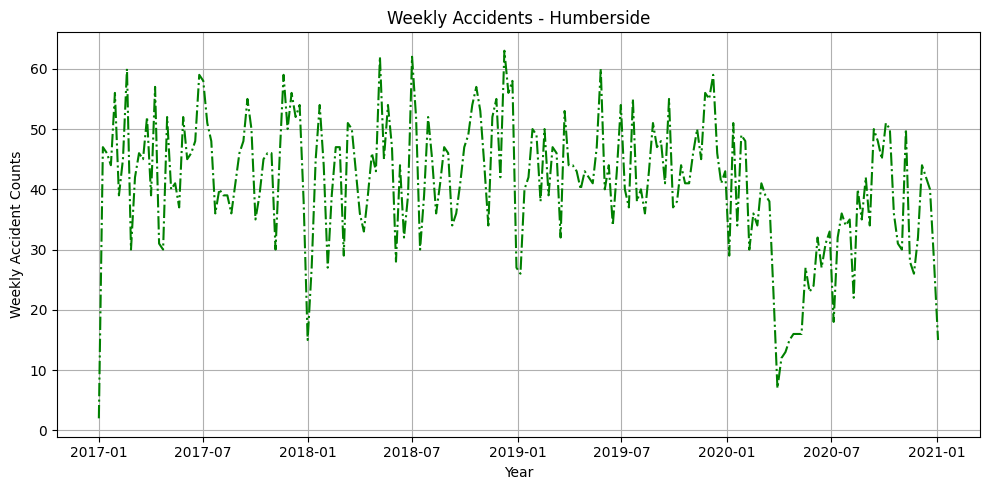

In [94]:

# plot the weekly accident counts 
plt.figure(figsize=(10, 5))
plt.plot(weekly_accidents, 'g-.')
plt.title(f"Weekly Accidents - Humberside")
plt.xlabel("Year")
plt.ylabel(f"Weekly Accident Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
# ADF Test
conduct_adf_test(weekly_accidents)

ADF Statistic: -2.302; p-value: 0.171


1. Strong negative value, indicating stationarity.
2. The p-value is not less than 0.05. Hence, we cannot reject the null hypothesis of non-stationarity.

In [96]:
# Applying differencing to for stationarity
diff_1 = weekly_accidents[['accident_count']].diff(1).dropna()
diff_1 

accident_count
date                      
2017-01-08            45.0
2017-01-15            -1.0
2017-01-22            -2.0
2017-01-29            12.0
2017-02-05           -17.0
...                    ...
2020-12-06            12.0
2020-12-13            -2.0
2020-12-20            -2.0
2020-12-27           -12.0
2021-01-03           -13.0

[209 rows x 1 columns]

In [97]:
# Testing the differenced series for stationarity
ADF_test = adfuller(diff_1)[:2]

print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: -9.738017135382874; p-value 8.645134750437607e-17


The p-value is less than 0.05. Hence, we reject the null hypothesis of non-stationarity.

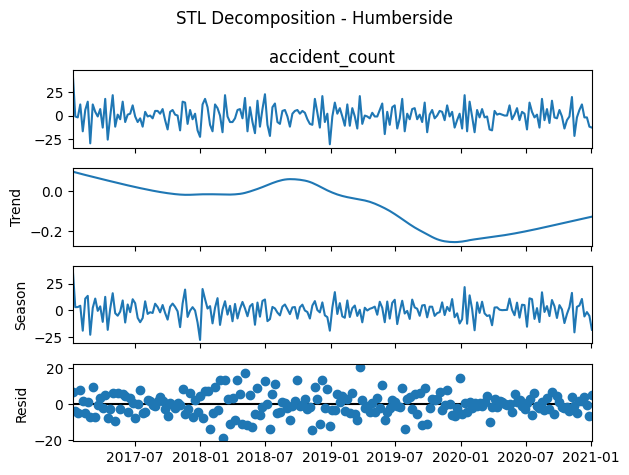

In [98]:
# Decomposition of the differenced series
plot_stl_decomposition(diff_1,'Humberside')

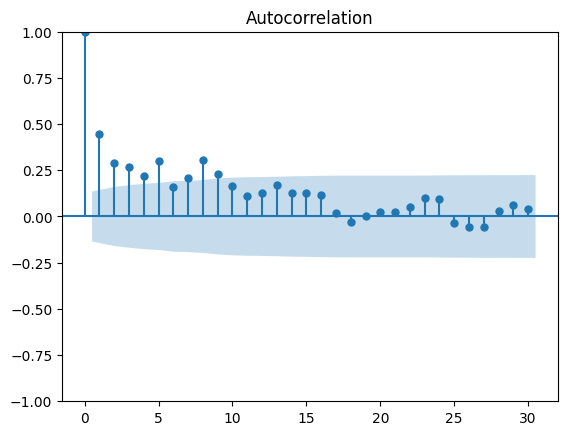

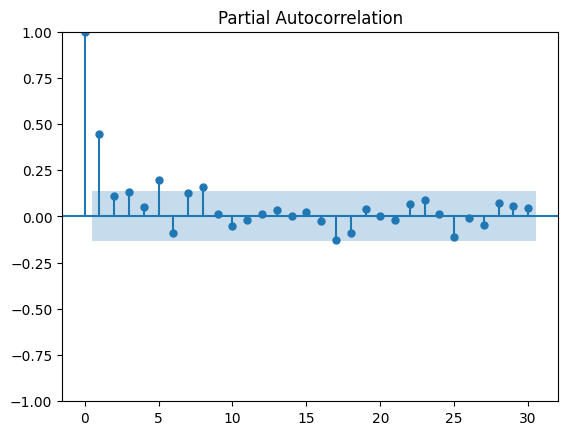

In [99]:
# Plot of ACF to understand the series 
# ACF/PACF
plot_acf(weekly_accidents['accident_count'], lags=30)
plt.show()
plot_pacf(weekly_accidents['accident_count'], lags=30)
plt.show()

The ACF plot shows an oscillating or wave-like pattern with high correlation (peaks) as seasonal lags. This shows that the data is periodic. The ACF values are also gradually decaying, this is a sign of non-stationarity. So, this timeseries is non-stationary and periodic.

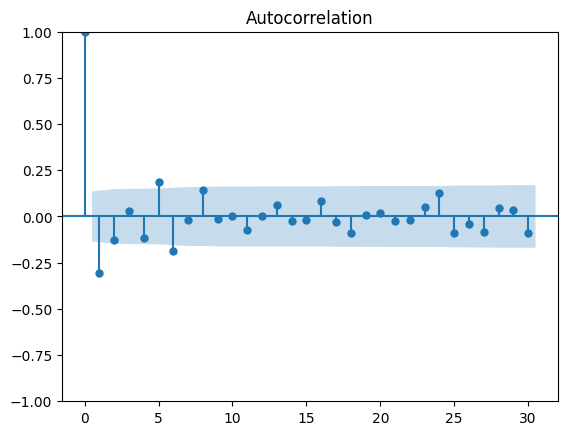

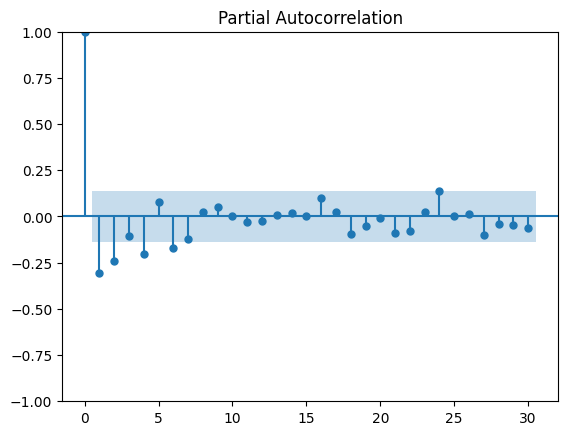

In [100]:
plot_acf(diff_1, lags=30)
plot_pacf(diff_1, lags=30)
plt.show()

The ACF plot for the differenced data shows a significant spike at lag 1 and then quickly falls within the confidence interval, indicating that there is no long-term autocorrelation after lag 1. This suggests that a low-order Moving Average (MA) term (q=1) may be appropriate.

The PACF plot for the differenced data shows a strong spike at lag 1 followed by a rapid decline, with no significant spikes at higher lags. This indicates that a low-order Autoregressive (AR) term (p=1) is suitable.

There is no strong evidence of seasonality present after differencing, as no repeated patterns or significant spikes are visible at seasonal lags in either ACF or PACF plots.

Based on these observations, an ARIMA(1,1,1) model would be appropriate for modeling the series after first differencing.

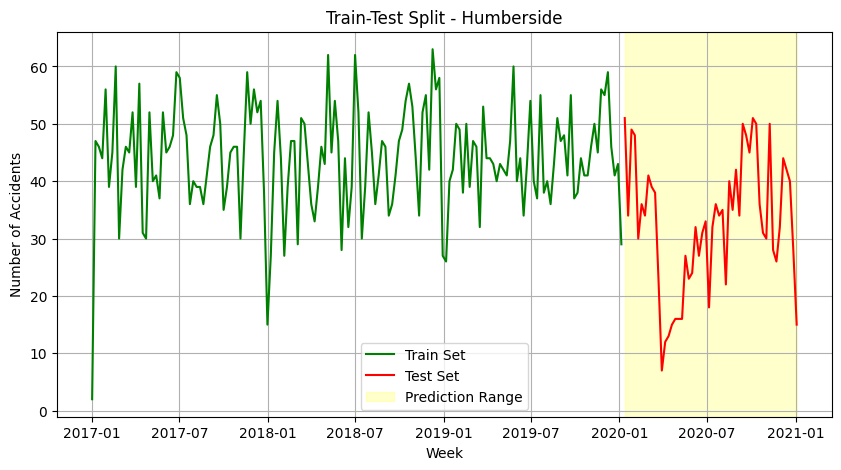

In [101]:
# Split train/test
train = weekly_accidents[:-52]
test = weekly_accidents[-52:]

plt.figure(figsize=(10, 5))
plt.plot(train.index, train['accident_count'], 'g-', label='Train Set')
plt.plot(test.index, test['accident_count'], 'r-', label='Test Set')
plt.axvspan(test.index[0], test.index[-1], color='yellow', alpha=0.2, label='Prediction Range')
plt.title(f'Train-Test Split - Humberside')
plt.xlabel('Week')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
train.head()

accident_count
date                      
2017-01-01               2
2017-01-08              47
2017-01-15              46
2017-01-22              44
2017-01-29              56

## ARIMA MODEL FOR HUMBERSIDE

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69194D+00    |proj g|=  1.35499D-01

At iterate    5    f=  3.62338D+00    |proj g|=  2.05628D-02

At iterate   10    f=  3.61504D+00    |proj g|=  1.02405D-03

At iterate   15    f=  3.61443D+00    |proj g|=  2.94045D-03

At iterate   20    f=  3.61437D+00    |proj g|=  1.49249D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   6.585D-06   3.614D+00
  F =   3.6143626332794407     

CONVERG

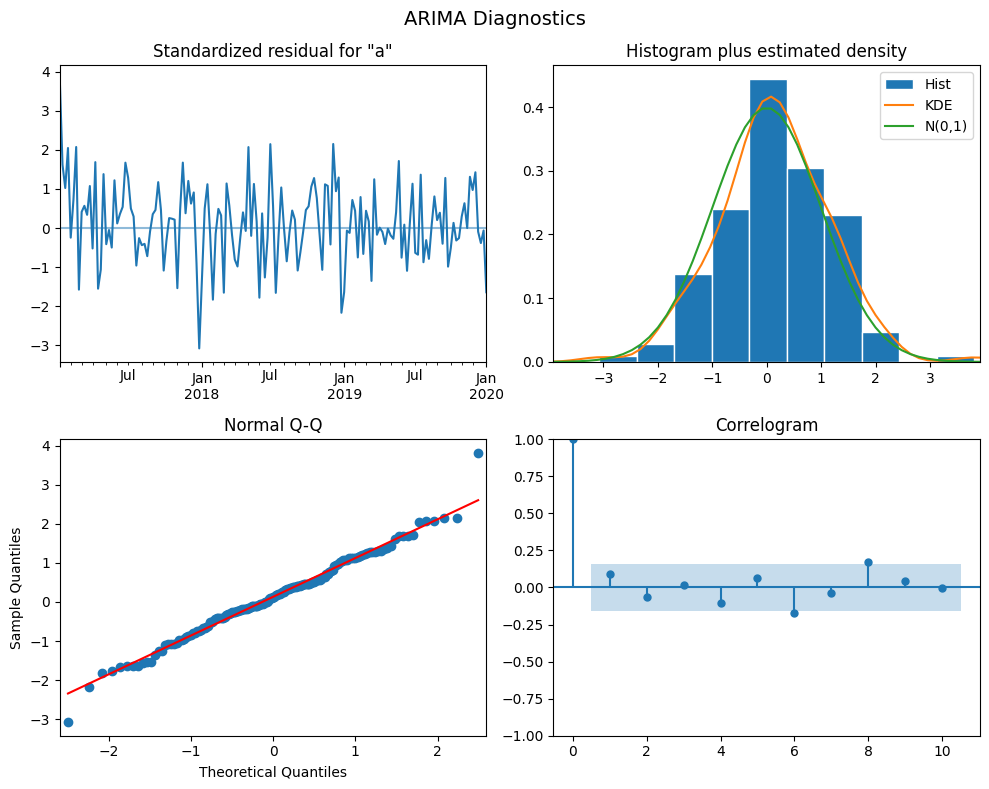

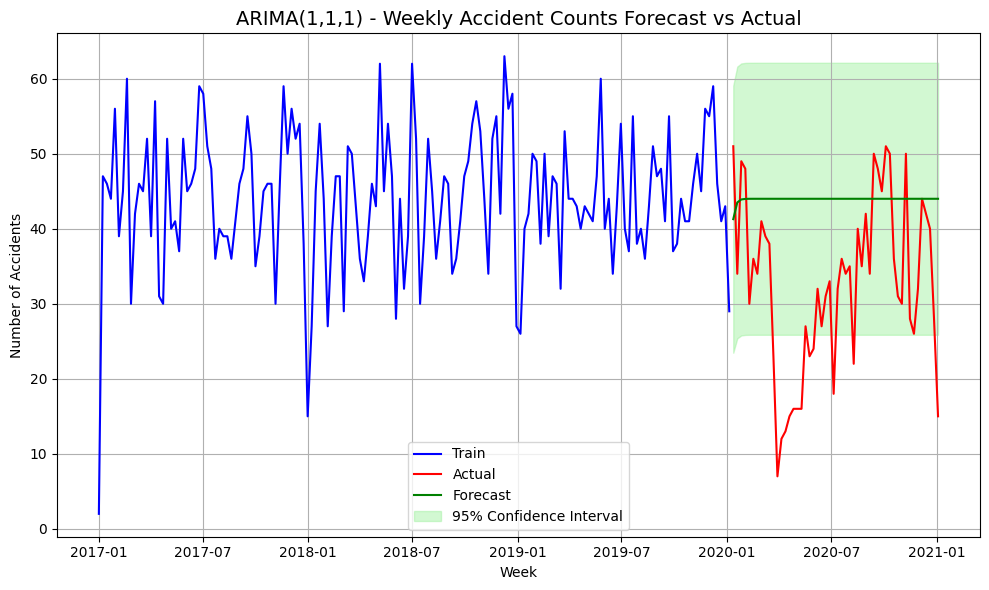

In [104]:
# Fit ARIMA
# From both the PACF and ACF plots, an ARIMA(1, 1, 1) model is suggested.
# Fitting the ARIMA model based on the order (1,1,1)
forecast, mean, conf_int = fit_arima_model(train,test,order=(1,1,1))
arima_pred = mean.values
test.loc[:, 'arima_pred'] = arima_pred

### naive model 

In [106]:
naive_pred = train['accident_count'][len(train)-52:len(train)].values

test.loc[:,'naive_pred'] = naive_pred

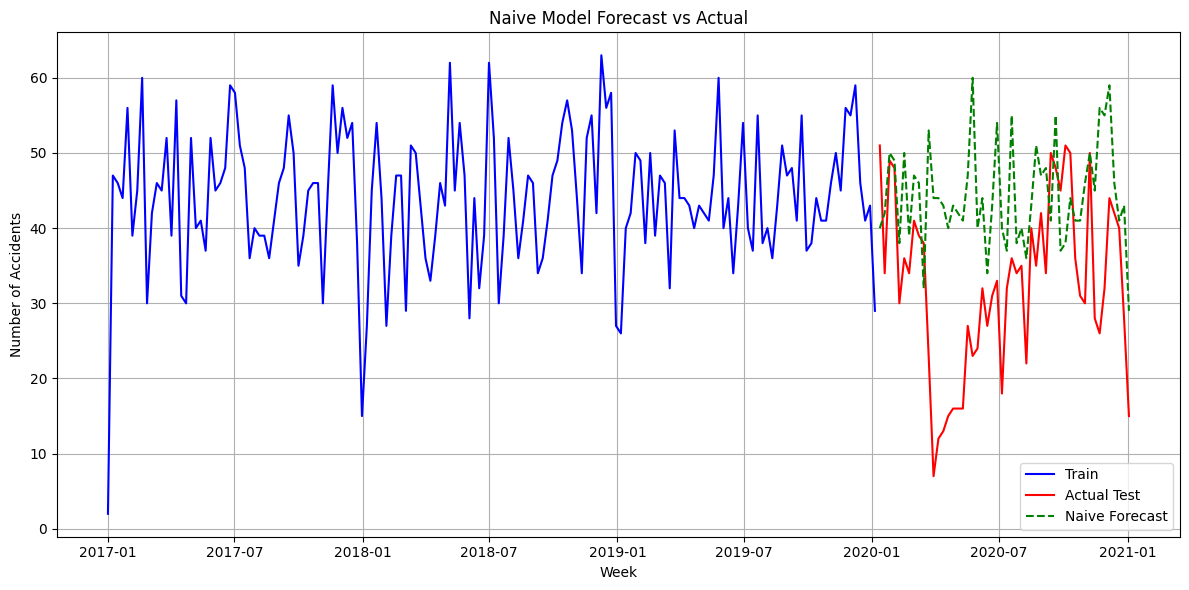

In [107]:
plt.figure(figsize=(12,6))

plt.plot(train.index, train['accident_count'], label='Train', color='blue')
plt.plot(test.index, test['accident_count'], label='Actual Test', color='red')
plt.plot(test.index, test['naive_pred'], label='Naive Forecast', color='green', linestyle='--')

plt.title('Naive Model Forecast vs Actual')
plt.xlabel('Week')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### fit sarima model

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/m

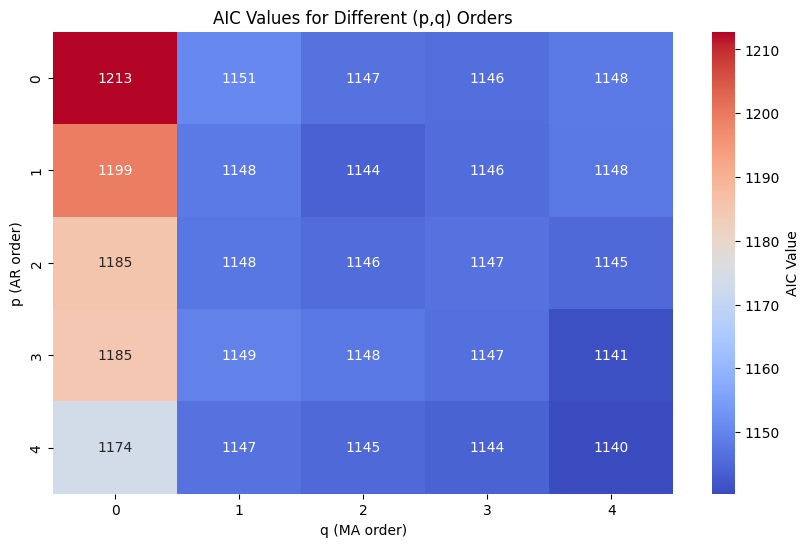

In [108]:
# find the best order p,q,d
best_order = find_best_order(train)

In [109]:
best_order

(4, 1, 4)

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60901D+00    |proj g|=  1.82727D-01

At iterate    5    f=  3.56098D+00    |proj g|=  4.28535D-02

At iterate   10    f=  3.53741D+00    |proj g|=  3.66096D-02

At iterate   15    f=  3.53052D+00    |proj g|=  3.10690D-02

At iterate   20    f=  3.52867D+00    |proj g|=  3.56327D-03

At iterate   25    f=  3.52823D+00    |proj g|=  4.34157D-04

At iterate   30    f=  3.52823D+00    |proj g|=  2.73910D-04

At iterate   35    f=  3.52819D+00    |proj g|=  3.21809D-03

At iterate   40    f=  3.52818D+00    |proj g|=  3.39635D-04

At iterate   45    f=  3.52816D+00    |proj g|=  3.93931D-04


/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.52815D+00    |proj g|=  7.34203D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   7.342D-04   3.528D+00
  F =   3.5281516659999781     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                       accident_count   No. Observations:                  158
Model:             SARIMAX(4, 1, 4)x(1, 0, [1], 52)   Log Likelihood                -557.448
Date:                              Mon, 28 Apr 2025   AIC                         

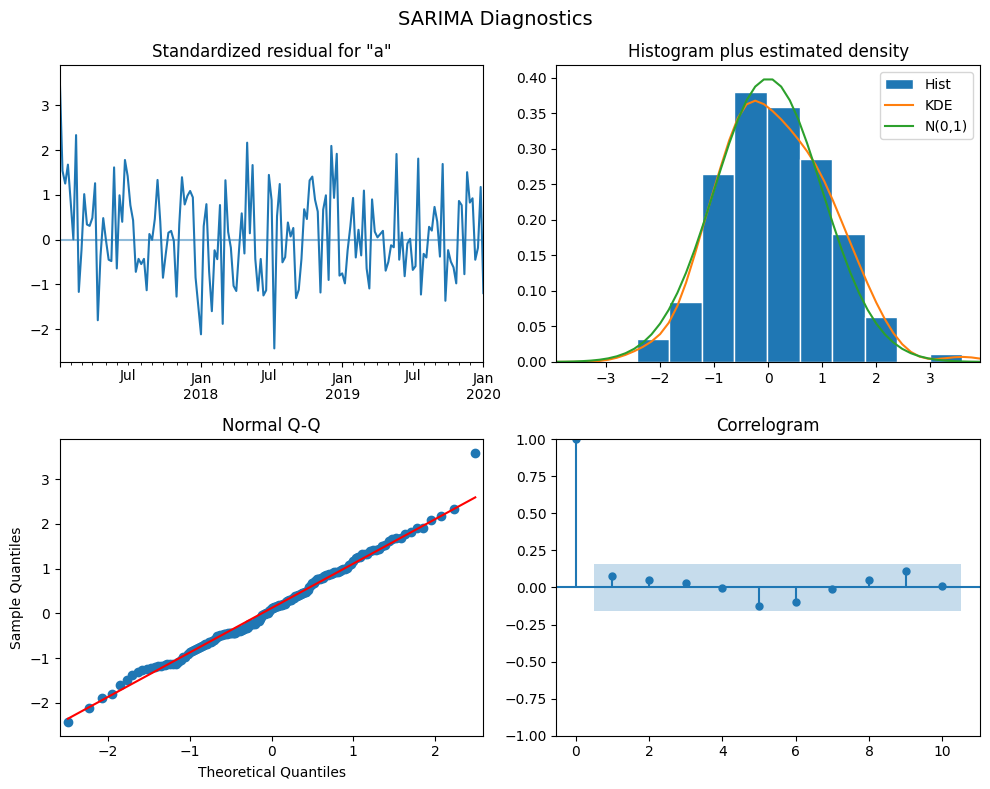

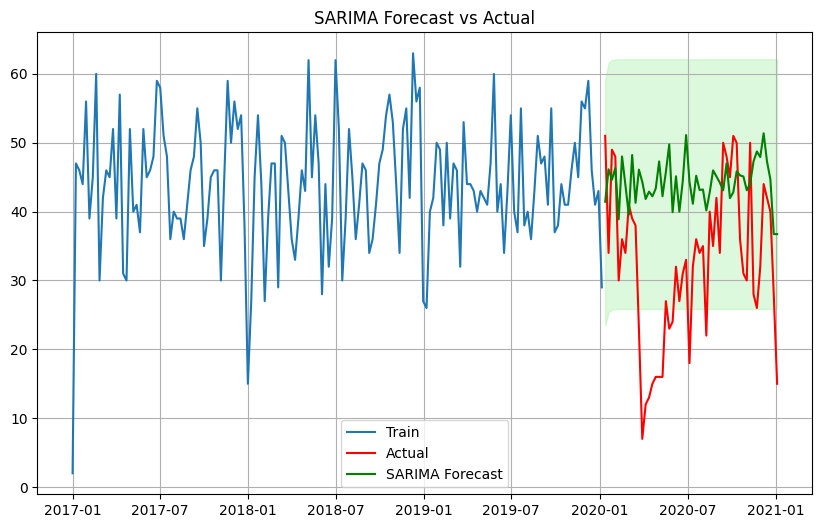

In [110]:
sarima_forecast,sarima_mean,sarima_conf_int = fit_sarima_model(train,best_order,test)

In [112]:

test.loc[:,'sarima_pred'] = sarima_mean

## Comparison of Models


ARIMA Model:
RMSE : 16.22
MAE  : 13.33
MAPE : 67.03%
R²   : -1.03

SARIMA Model:
RMSE : 16.25
MAE  : 13.51
MAPE : 66.64%
R²   : -1.03

Naive Model:
RMSE : 16.98
MAE  : 13.92
MAPE : 66.75%
R²   : -1.22


/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWa

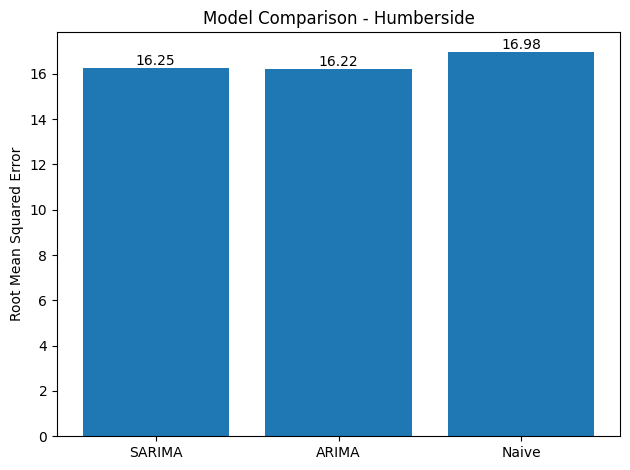

In [113]:


# Compare RMSE
sarima_mse = mean_squared_error(test['accident_count'], test['sarima_pred'], squared=False)
arima_mse = mean_squared_error(test['accident_count'], test['arima_pred'], squared=False)
naive_mse = mean_squared_error(test['accident_count'], test['naive_pred'], squared=False)

calculate_metrics_for_models(test)
# RMSE Plot
list_mse = [sarima_mse, arima_mse, naive_mse]
models = ['SARIMA', 'ARIMA', 'Naive']
plt.bar(models, list_mse)
plt.ylabel('Root Mean Squared Error')
plt.title(f'Model Comparison - Humberside')
for i, val in enumerate(list_mse):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


## for West Yorkshire code 13

In [114]:
df_w_yorkshire = df[df['police_force']==13].copy()
df_w_yorkshire

police_force        date
0                13  19/05/2017
1                13  13/03/2017
2                13  17/03/2017
3                13  14/01/2017
4                13  01/01/2017
...             ...         ...
29465            13  31/12/2020
29466            13  31/12/2020
29467            13  31/12/2020
29468            13  31/12/2020
29469            13  31/12/2020

[14886 rows x 2 columns]

In [115]:
weekly_accidents=preprocess_data(df_w_yorkshire)
weekly_accidents


accident_count
date                      
2017-01-01               7
2017-01-08              69
2017-01-15              83
2017-01-22              91
2017-01-29              87
...                    ...
2020-12-06              61
2020-12-13              54
2020-12-20              67
2020-12-27              32
2021-01-03              17

[210 rows x 1 columns]

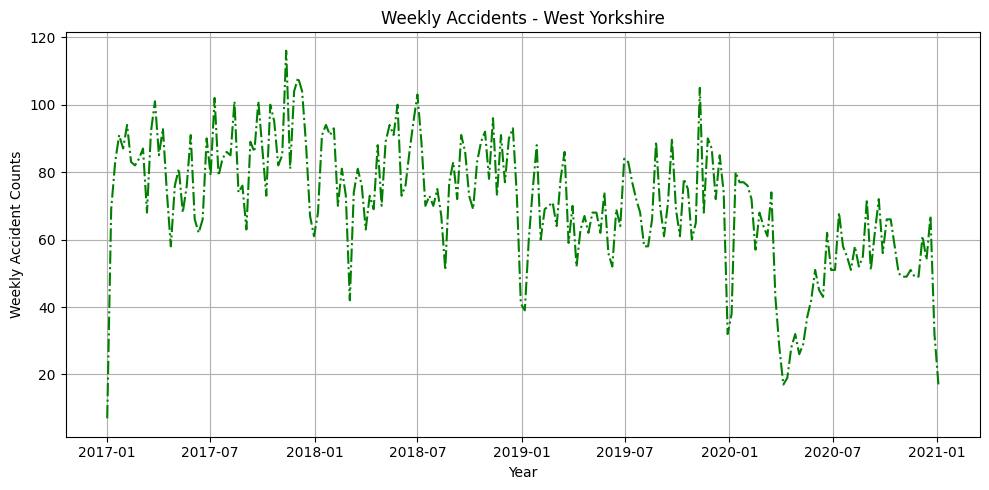

In [116]:

# plot the weekly accident counts 
plt.figure(figsize=(10, 5))
plt.plot(weekly_accidents, 'g-.')
plt.title(f"Weekly Accidents - West Yorkshire")
plt.xlabel("Year")
plt.ylabel(f"Weekly Accident Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

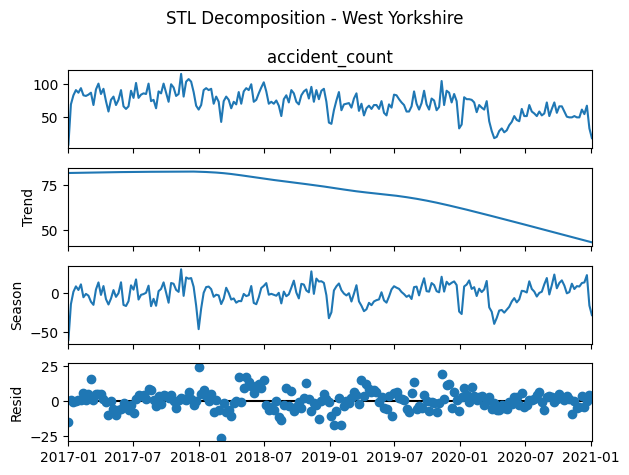

In [117]:
# STL decomposition
plot_stl_decomposition(weekly_accidents,'West Yorkshire')

In [118]:
# ADF Test
conduct_adf_test(weekly_accidents)

ADF Statistic: -2.159; p-value: 0.222


Since the p-value (0.222) is greater than 0.05, we fail to reject the null hypothesis of the Augmented Dickey-Fuller (ADF) test.

This means that the data is non-stationary.
A time series model like ARIMA requires stationarity, so differencing will be needed to transform the data into a stationary series before modeling.

In [119]:
# Applying differencing to for stationarity
diff_1 = weekly_accidents[['accident_count']].diff(1).dropna()
diff_1 

accident_count
date                      
2017-01-08            62.0
2017-01-15            14.0
2017-01-22             8.0
2017-01-29            -4.0
2017-02-05             7.0
...                    ...
2020-12-06            12.0
2020-12-13            -7.0
2020-12-20            13.0
2020-12-27           -35.0
2021-01-03           -15.0

[209 rows x 1 columns]

In [120]:
# ADF Test
conduct_adf_test(diff_1)

ADF Statistic: -5.022; p-value: 0.000


After first differencing, the p-value is 0.000, which is less than 0.05.

Therefore, we reject the null hypothesis of the Augmented Dickey-Fuller (ADF) test.

This means that the differenced data is now stationary and suitable for time series modeling.

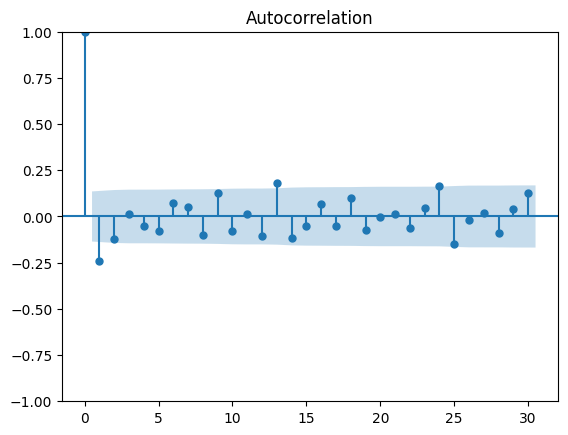

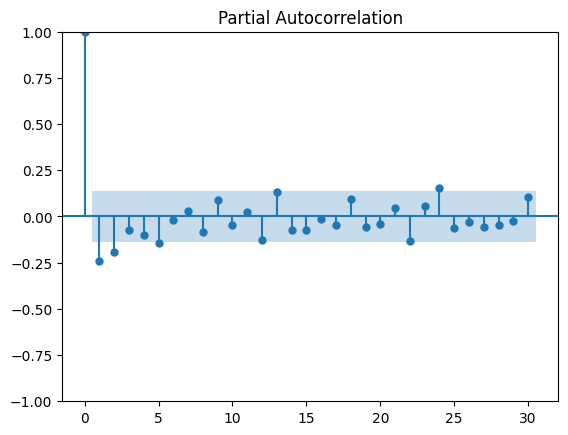

In [121]:

# ACF/PACF
plot_acf(diff_1['accident_count'], lags=30)
plt.show()
plot_pacf(diff_1['accident_count'], lags=30)
plt.show()

The ACF plot shows a strong spike at lag 1, followed by a rapid drop where subsequent lags fall within the confidence bounds, indicating that a low-order Moving Average (MA) component (q=1) is appropriate. Similarly, the PACF plot displays a significant spike at lag 1 and then quickly cuts off, suggesting a low-order Autoregressive (AR) component (p=1). There is no clear slow decay or oscillating pattern, which confirms that the series is now stationary after differencing. Therefore, based on the ACF and PACF behavior, an ARIMA(1,1,1) model is recommended.



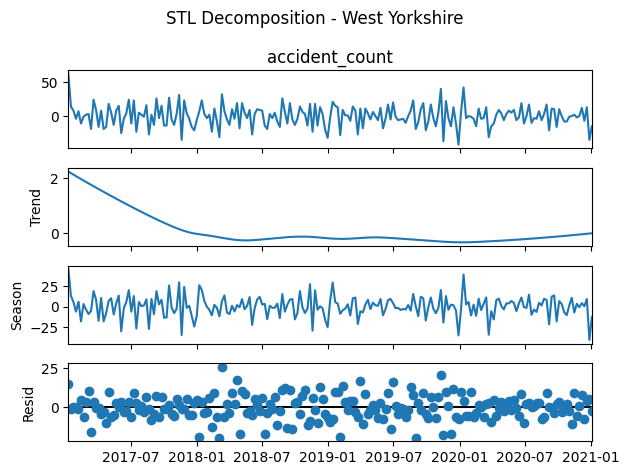

In [122]:
# Decomposition of the differenced series
plot_stl_decomposition(diff_1,'West Yorkshire')

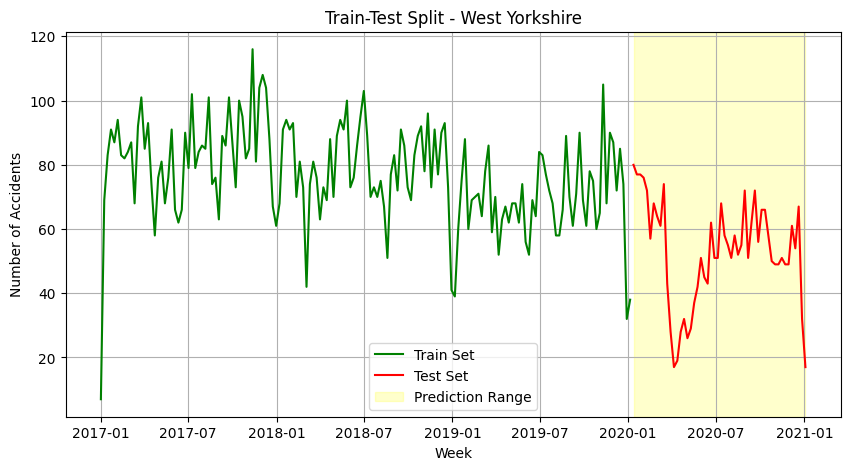

In [123]:
# Split train/test
train = weekly_accidents[:-52]
test = weekly_accidents[-52:]

plt.figure(figsize=(10, 5))
plt.plot(train.index, train['accident_count'], 'g-', label='Train Set')
plt.plot(test.index, test['accident_count'], 'r-', label='Test Set')
plt.axvspan(test.index[0], test.index[-1], color='yellow', alpha=0.2, label='Prediction Range')
plt.title(f'Train-Test Split - West Yorkshire')
plt.xlabel('Week')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

## ARIMA Model for West Yorkshire

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07724D+00    |proj g|=  6.64073D-02

At iterate    5    f=  4.05053D+00    |proj g|=  3.44919D-03

At iterate   10    f=  4.04992D+00    |proj g|=  1.29722D-03

At iterate   15    f=  4.04991D+00    |proj g|=  5.86855D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   5.869D-06   4.050D+00
  F =   4.0499072517036154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

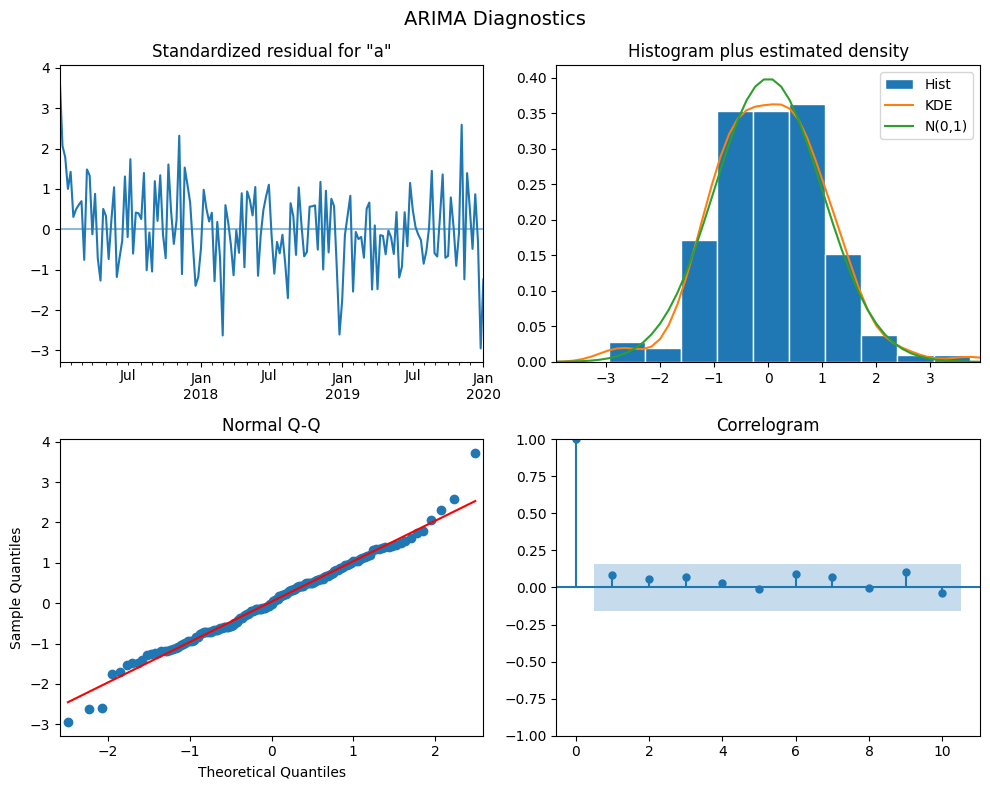

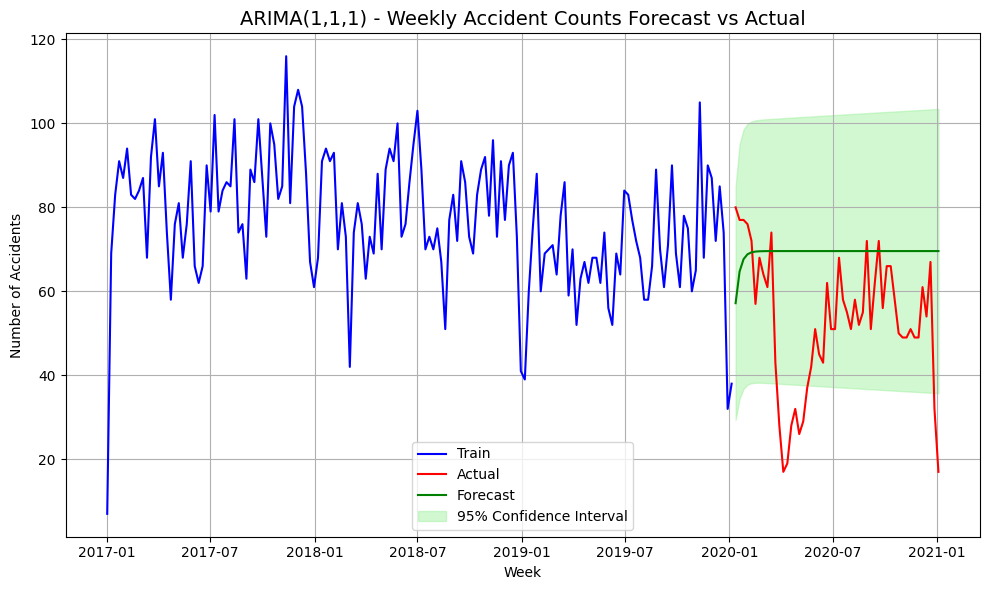

In [125]:
# Fit ARIMA
forecast, mean, conf_int = fit_arima_model(train,test,order=(1,1,1))
arima_pred = mean.values
test.loc[:,'arima_pred'] = arima_pred

## Naive Model for West Yorkshire

In [127]:
naive_pred = train['accident_count'][len(train)-52:len(train)].values

test.loc[:,'naive_pred'] = naive_pred

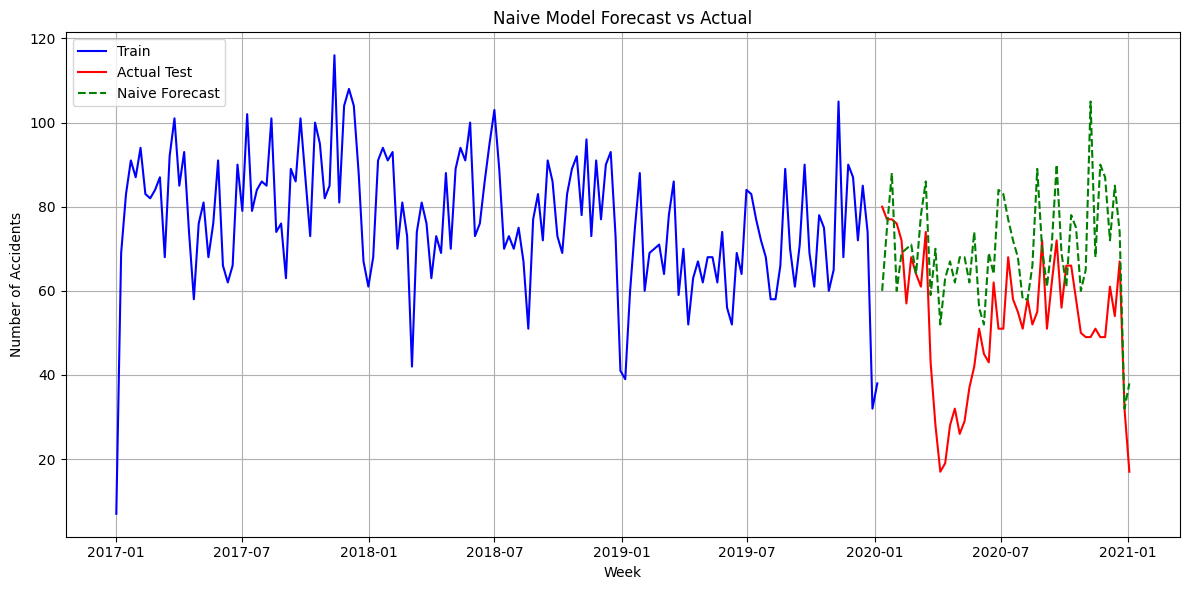

In [128]:
plt.figure(figsize=(12,6))

plt.plot(train.index, train['accident_count'], label='Train', color='blue')
plt.plot(test.index, test['accident_count'], label='Actual Test', color='red')
plt.plot(test.index, test['naive_pred'], label='Naive Forecast', color='green', linestyle='--')

plt.title('Naive Model Forecast vs Actual')
plt.xlabel('Week')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## SARIMA Model for West Yorkshire

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/m

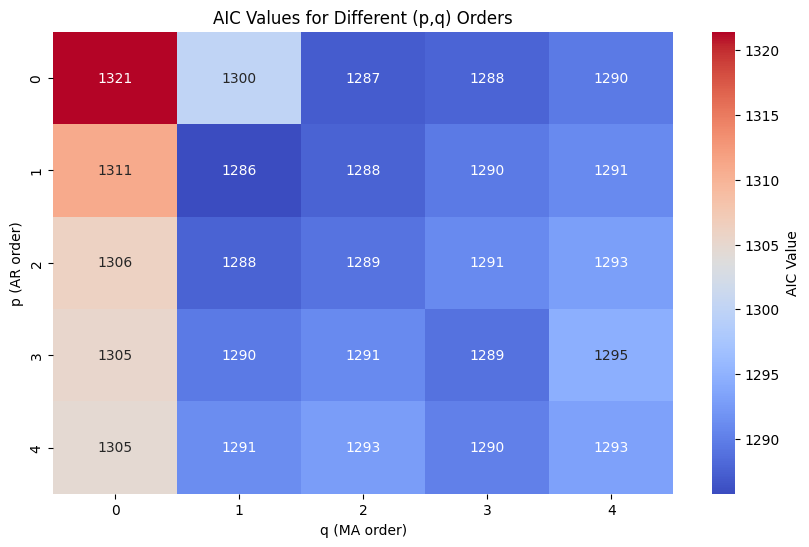

In [129]:
# find the best order p,q,d
best_order = find_best_order(train)

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07724D+00    |proj g|=  2.96696D-01


 This problem is unconstrained.



At iterate    5    f=  3.99291D+00    |proj g|=  9.92573D-02

At iterate   10    f=  3.96522D+00    |proj g|=  8.52994D-03

At iterate   15    f=  3.96381D+00    |proj g|=  1.10575D-03

At iterate   20    f=  3.96342D+00    |proj g|=  5.10595D-03

At iterate   25    f=  3.96324D+00    |proj g|=  1.67308D-03

At iterate   30    f=  3.96319D+00    |proj g|=  1.77559D-03

At iterate   35    f=  3.96318D+00    |proj g|=  5.23412D-04

At iterate   40    f=  3.96318D+00    |proj g|=  2.65604D-04

At iterate   45    f=  3.96318D+00    |proj g|=  1.79878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     62   

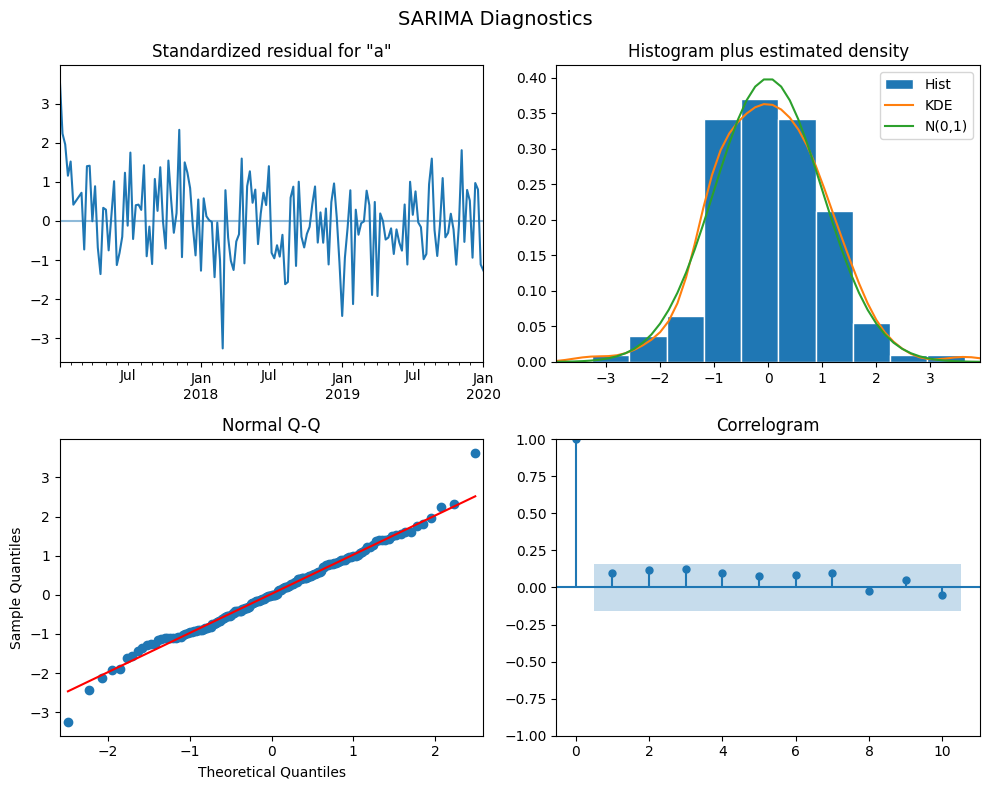

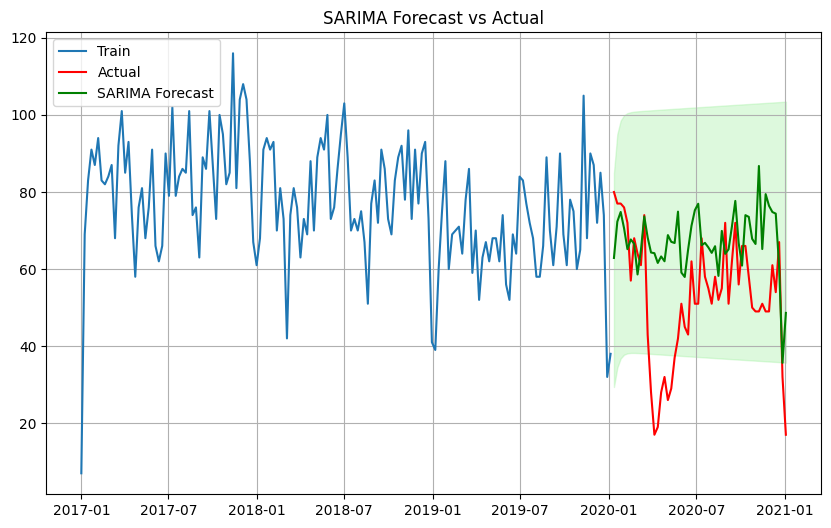

In [130]:
sarima_forecast,sarima_mean,sarima_conf_int = fit_sarima_model(train,best_order,test)

In [132]:

test.loc[:,'sarima_pred'] = sarima_mean

## Comparison of Models for West Yorkshire


ARIMA Model:
RMSE : 23.54
MAE  : 18.98
MAPE : 55.14%
R²   : -1.16

SARIMA Model:
RMSE : 21.08
MAE  : 16.95
MAPE : 47.33%
R²   : -0.73

Naive Model:
RMSE : 23.31
MAE  : 18.67
MAPE : 48.60%
R²   : -1.12


/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWa

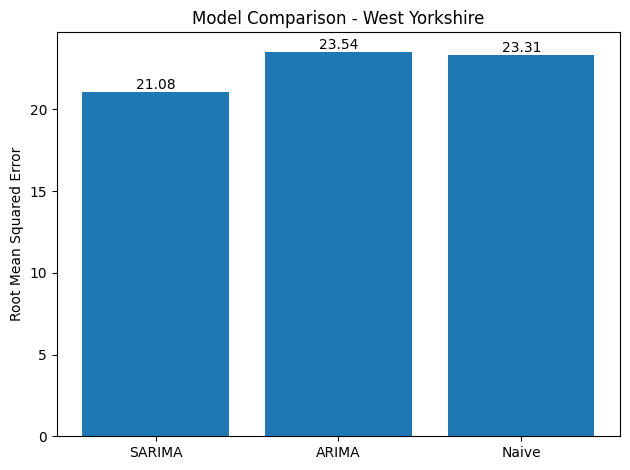

In [133]:


# Compare RMSE
sarima_mse = mean_squared_error(test['accident_count'], test['sarima_pred'], squared=False)
arima_mse = mean_squared_error(test['accident_count'], test['arima_pred'], squared=False)
naive_mse = mean_squared_error(test['accident_count'], test['naive_pred'], squared=False)

calculate_metrics_for_models(test)
# RMSE Plot
list_mse = [sarima_mse, arima_mse, naive_mse]
models = ['SARIMA', 'ARIMA', 'Naive']
plt.bar(models, list_mse)
plt.ylabel('Root Mean Squared Error')
plt.title(f'Model Comparison - West Yorkshire')
for i, val in enumerate(list_mse):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


## South Yorkshire code 14

In [134]:
df_s_yorkshire = df[df['police_force']==14].copy()
df_s_yorkshire

police_force        date
4370             14  02/01/2017
4371             14  06/01/2017
4372             14  08/01/2017
4373             14  07/01/2017
4374             14  11/01/2017
...             ...         ...
31486            14  23/09/2020
31487            14  30/01/2020
31488            14  19/10/2020
31489            14  22/08/2020
31490            14  25/08/2020

[9661 rows x 2 columns]

In [135]:
weekly_accidents=preprocess_data(df_s_yorkshire)
weekly_accidents


accident_count
date                      
2017-01-01               4
2017-01-08              49
2017-01-15              80
2017-01-22              47
2017-01-29              72
...                    ...
2020-12-06              52
2020-12-13              48
2020-12-20              47
2020-12-27              45
2021-01-03              16

[210 rows x 1 columns]

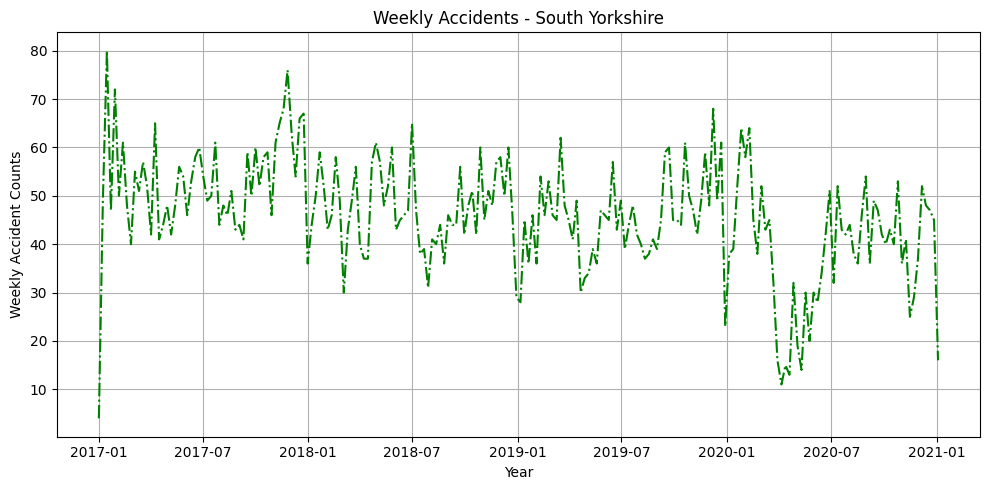

In [136]:

# plot the weekly accident counts 
plt.figure(figsize=(10, 5))
plt.plot(weekly_accidents, 'g-.')
plt.title(f"Weekly Accidents - South Yorkshire")
plt.xlabel("Year")
plt.ylabel(f"Weekly Accident Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

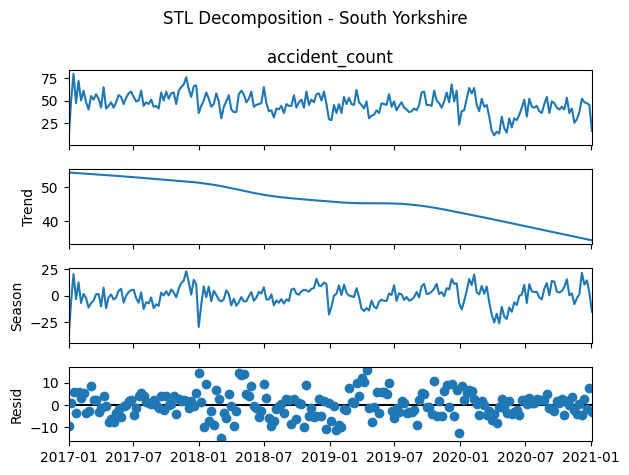

In [137]:
# STL decomposition
plot_stl_decomposition(weekly_accidents,'South Yorkshire')

In [138]:
# ADF Test
conduct_adf_test(weekly_accidents)

ADF Statistic: -3.377; p-value: 0.012


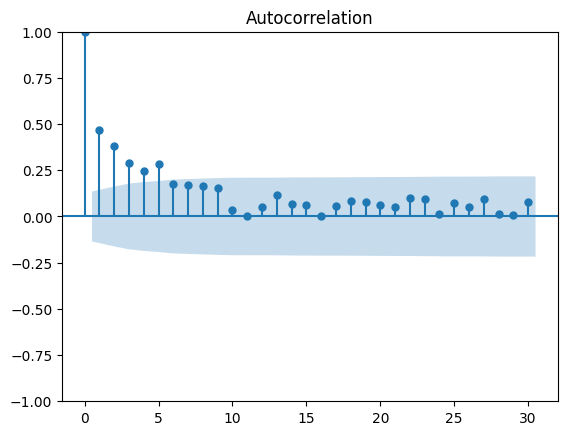

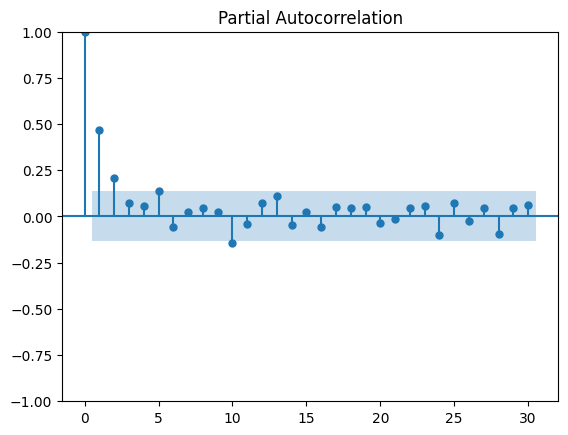

In [139]:

# ACF/PACF
plot_acf(weekly_accidents['accident_count'], lags=30)
plt.show()
plot_pacf(weekly_accidents['accident_count'], lags=30)
plt.show()

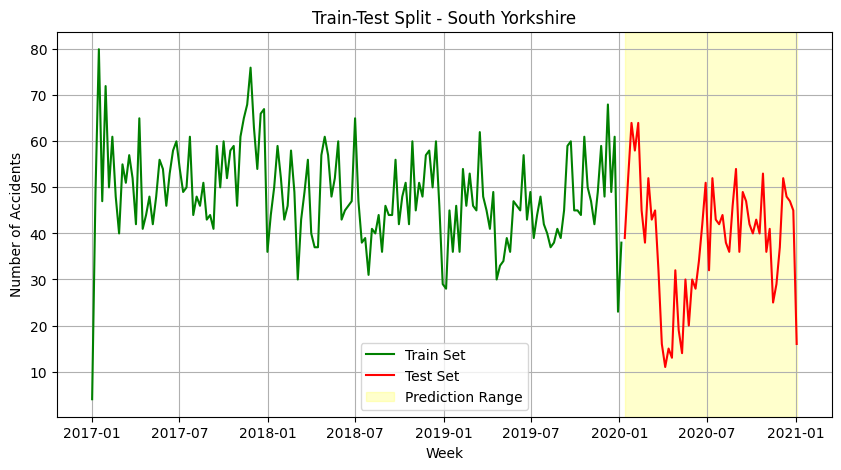

In [140]:
# Split train/test
train = weekly_accidents[:-52]
test = weekly_accidents[-52:]

plt.figure(figsize=(10, 5))
plt.plot(train.index, train['accident_count'], 'g-', label='Train Set')
plt.plot(test.index, test['accident_count'], 'r-', label='Test Set')
plt.axvspan(test.index[0], test.index[-1], color='yellow', alpha=0.2, label='Prediction Range')
plt.title(f'Train-Test Split - South Yorkshire')
plt.xlabel('Week')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)
plt.show()

## ARIMA MODEL

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77407D+00    |proj g|=  6.86547D-02

At iterate    5    f=  3.75601D+00    |proj g|=  2.32010D-03

At iterate   10    f=  3.74785D+00    |proj g|=  4.61922D-03

At iterate   15    f=  3.74432D+00    |proj g|=  8.56451D-04

At iterate   20    f=  3.74418D+00    |proj g|=  1.68128D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   1.681D-06   3.744D+00
  F =   3.7441787044779895     

CONVERG

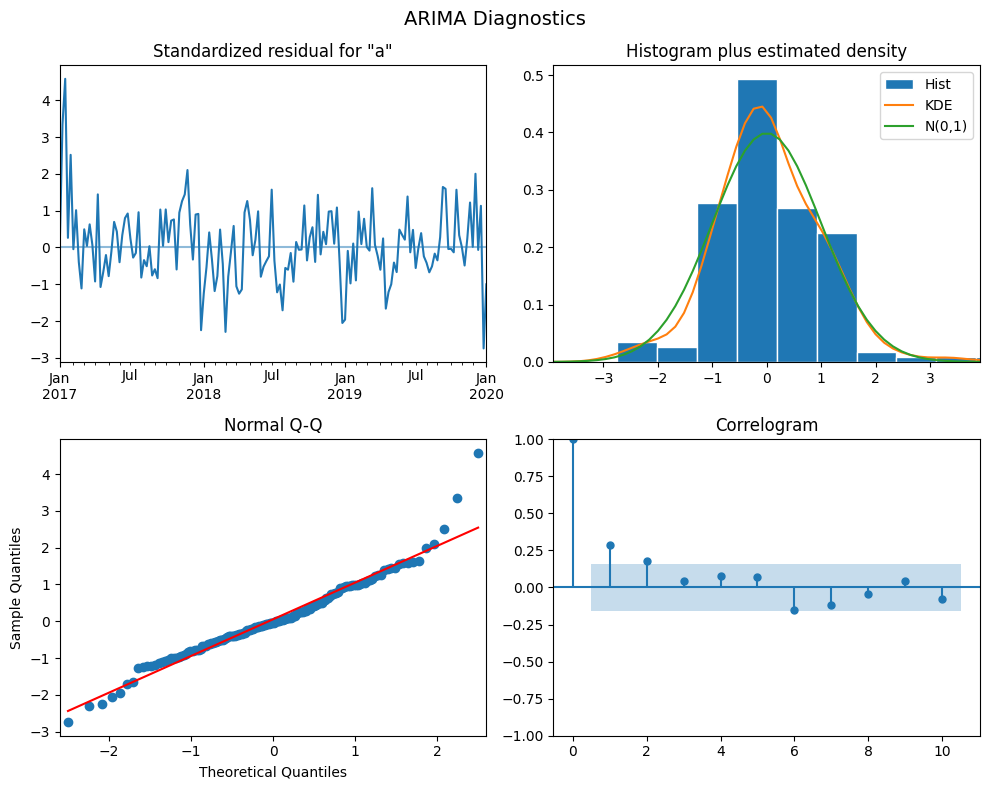

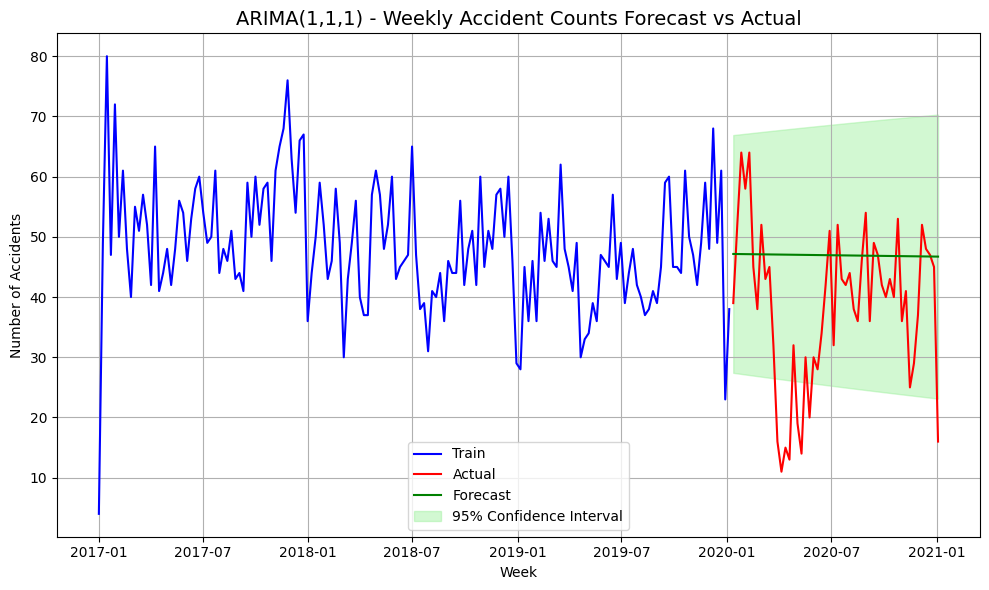

/var/folders/38/qw_rrlt93hj2cg5m59k8_4yw0000gq/T/ipykernel_47374/2061907070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['arima_pred'] = arima_pred


In [142]:
# Fit ARIMA
forecast, mean, conf_int = fit_arima_model(train,test,(1,0,1))
arima_pred = mean.values
test['arima_pred'] = arima_pred

## Naive Model

In [145]:
naive_pred = train['accident_count'][len(train)-52:len(train)].values

test.loc[:,'naive_pred'] = naive_pred

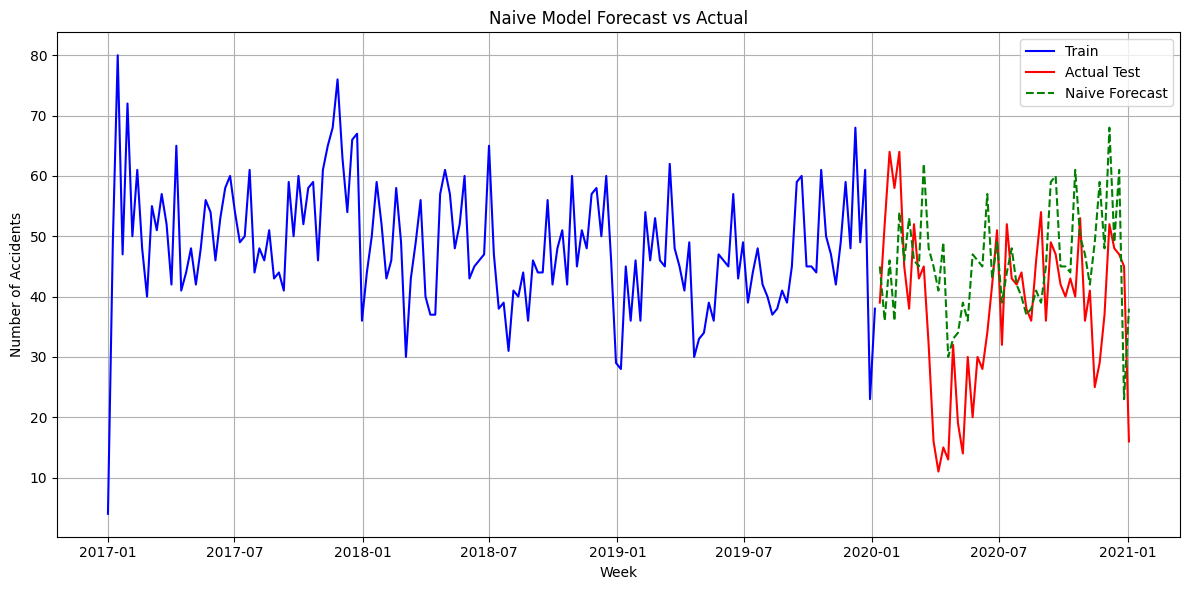

In [146]:
plt.figure(figsize=(12,6))

plt.plot(train.index, train['accident_count'], label='Train', color='blue')
plt.plot(test.index, test['accident_count'], label='Actual Test', color='red')
plt.plot(test.index, test['naive_pred'], label='Naive Forecast', color='green', linestyle='--')

plt.title('Naive Model Forecast vs Actual')
plt.xlabel('Week')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## SARIMA MODEL

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/m

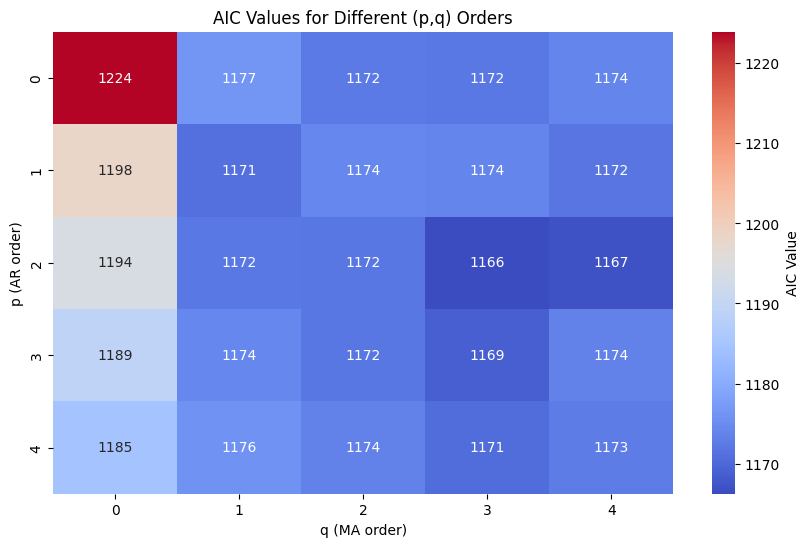

In [147]:
# find the best order p,q,d
best_order = find_best_order(train)

In [1111]:
best_order

(2, 1, 3)

/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72368D+00    |proj g|=  1.52691D-01

At iterate    5    f=  3.67121D+00    |proj g|=  2.09109D-02

At iterate   10    f=  3.64665D+00    |proj g|=  3.16000D-02

At iterate   15    f=  3.64014D+00    |proj g|=  1.83418D-01

At iterate   20    f=  3.63163D+00    |proj g|=  1.88049D-02

At iterate   25    f=  3.62427D+00    |proj g|=  2.27008D-02

At iterate   30    f=  3.61736D+00    |proj g|=  8.12212D-02

At iterate   35    f=  3.61543D+00    |proj g|=  3.20811D-02

At iterate   40    f=  3.61499D+00    |proj g|=  1.32584D-02

At iterate   45    f=  3.61467D+00    |proj g|=  3.67518D-02


/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.61444D+00    |proj g|=  1.26609D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.266D-02   3.614D+00
  F =   3.6144357206215374     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                       accident_count   No. Observations:                  158
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 52)   Log Likelihood                -571.081
Date:                              Mon, 28 Apr 2025   AIC                         

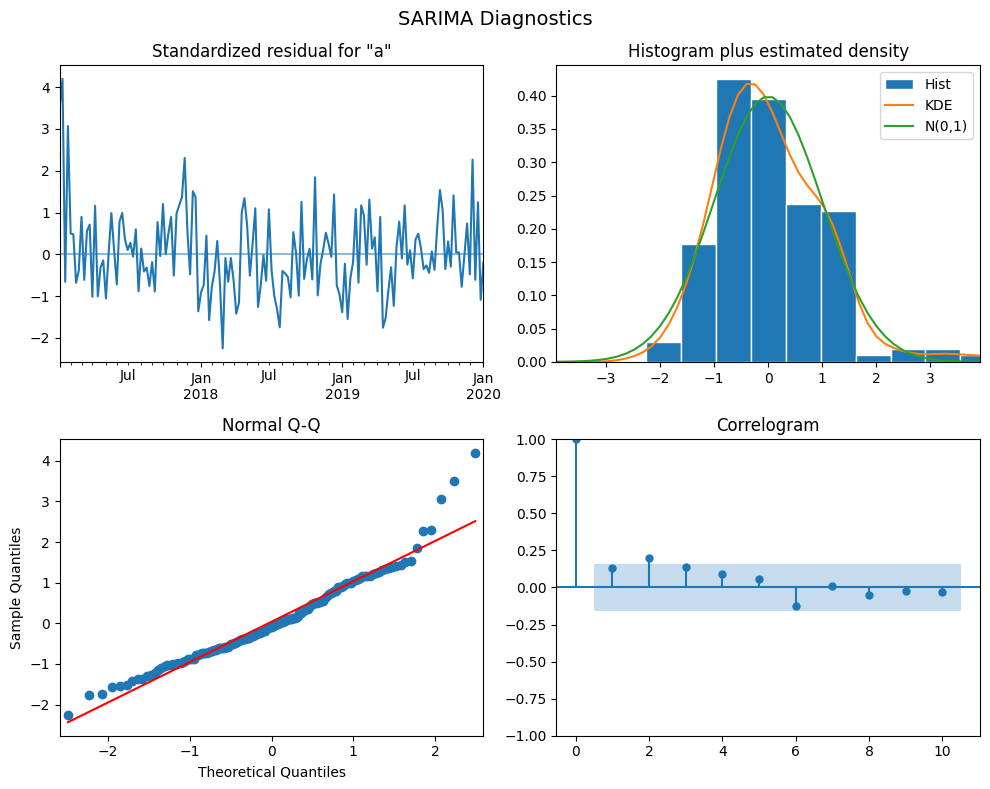

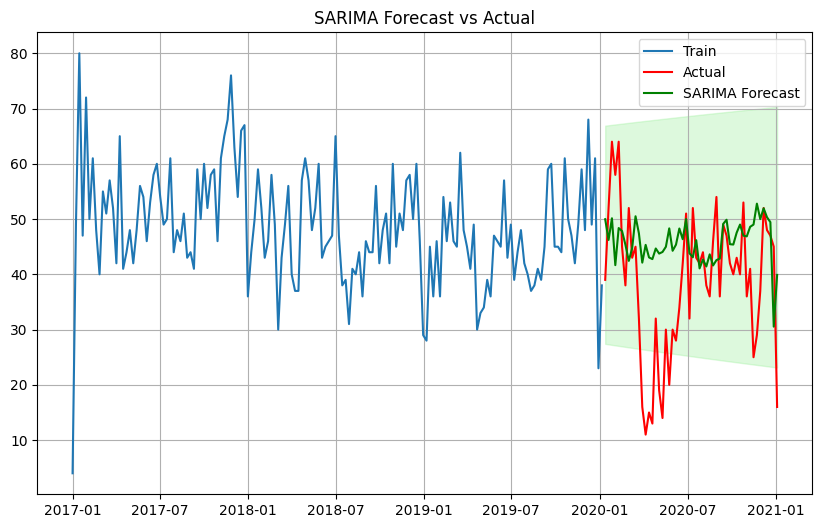

In [150]:
sarima_forecast,sarima_mean,sarima_conf_int = fit_sarima_model(train,best_order,test)
test.loc[:,'sarima_pred'] = sarima_mean


ARIMA Model:
RMSE : 15.45
MAE  : 11.78
MAPE : 51.62%
R²   : -0.43

SARIMA Model:
RMSE : 14.68
MAE  : 11.52
MAPE : 48.57%
R²   : -0.29

Naive Model:
RMSE : 15.36
MAE  : 12.23
MAPE : 47.26%
R²   : -0.42


/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWa

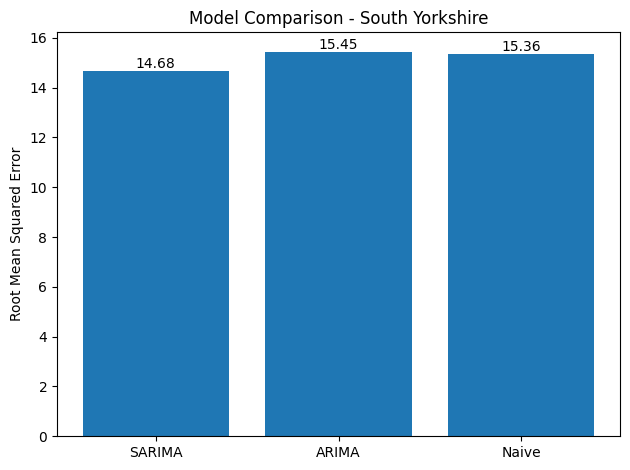

In [151]:


# Compare RMSE
sarima_mse = mean_squared_error(test['accident_count'], test['sarima_pred'], squared=False)
arima_mse = mean_squared_error(test['accident_count'], test['arima_pred'], squared=False)
naive_mse = mean_squared_error(test['accident_count'], test['naive_pred'], squared=False)

calculate_metrics_for_models(test)
# RMSE Plot
list_mse = [sarima_mse, arima_mse, naive_mse]
models = ['SARIMA', 'ARIMA', 'Naive']
plt.bar(models, list_mse)
plt.ylabel('Root Mean Squared Error')
plt.title(f'Model Comparison - South Yorkshire')
for i, val in enumerate(list_mse):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


### 7. Identify the three Local Super Output Areas (LSOAs) of Hull city that recorded the highest number of road accidents in the first three months of 2020, then employ a time series model to forecast daily accident occurrences for the upcoming month (e.g., July), leveraging data from the preceding six months (e.g., January to June) for these high-incident areas.

## Step 1: Data Selection

In [152]:
query = """
SELECT 
    lsoa01cd,
    COUNT(*) AS accident_count
FROM 
    lsoa 
JOIN 
    accident 
ON 
    lsoa.lsoa01cd = accident.lsoa_of_accident_location
WHERE 
    lsoa01nm LIKE '%Kingston Upon Hull%'
    AND accident.accident_year = 2020
    AND substr(accident.date, 4, 2) IN ('01', '02', '03')
GROUP BY 
    lsoa01cd
ORDER BY 
    accident_count DESC
LIMIT 3
"""
cur.execute(query)
data = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(data, columns=columns)
df


lsoa01cd  accident_count
0  E01012817              10
1  E01012889               7
2  E01012848               7

In [153]:
lsoas = tuple(df['lsoa01cd'])
lsoas

('E01012817', 'E01012889', 'E01012848')

In [154]:
lsoas = tuple(df['lsoa01cd'])

query = f"""
SELECT 
    lsoa.lsoa01cd,
    lsoa.lsoa01nm AS lsoa_name, 
    accident.date,
    COUNT(*) AS accident_count_per_day
FROM 
    lsoa 
JOIN 
    accident 
ON 
    lsoa.lsoa01cd = accident.lsoa_of_accident_location
WHERE 
    lsoa.lsoa01cd IN {lsoas}
    AND accident.accident_year = 2020
    AND substr(accident.date, 4, 2) IN ('01', '02', '03','04','05','06')
GROUP BY 
    lsoa.lsoa01cd, accident.date
ORDER BY 
    accident_count_per_day DESC
"""
cur.execute(query)
data = cur.fetchall()
columns = [desc[0] for desc in cur.description]
timeseries_df = pd.DataFrame(data, columns=columns)
timeseries_df


lsoa01cd                lsoa_name        date  accident_count_per_day
0   E01012817  Kingston upon Hull 016D  02/01/2020                       2
1   E01012817  Kingston upon Hull 016D  01/05/2020                       1
2   E01012817  Kingston upon Hull 016D  03/01/2020                       1
3   E01012817  Kingston upon Hull 016D  03/02/2020                       1
4   E01012817  Kingston upon Hull 016D  09/06/2020                       1
5   E01012817  Kingston upon Hull 016D  11/02/2020                       1
6   E01012817  Kingston upon Hull 016D  11/03/2020                       1
7   E01012817  Kingston upon Hull 016D  13/01/2020                       1
8   E01012817  Kingston upon Hull 016D  13/06/2020                       1
9   E01012817  Kingston upon Hull 016D  17/01/2020                       1
10  E01012817  Kingston upon Hull 016D  22/01/2020                       1
11  E01012817  Kingston upon Hull 016D  23/01/2020                       1
12  E01012848  Kingston upon Hull 020B  10/01/2020                       1
13  E01012848  Kingston upon Hull 020B  18/02/2020                       1
14  E01012848  Kingston upon Hull 020B  20/04/2020                       1
15  E01012848  Kingston upon Hull 020B  22/01/2020                       1
16  E01012848  Kingston upon Hull 020B  25/02/2020                       1
17  E01012848  Kingston upon Hull 020B  26/02/2020                       1
18  E01012848  Kingston upon Hull 020B  27/02/2020                       1
19  E01012848  Kingston upon Hull 020B  30/03/2020                       1
20  E01012848  Kingston upon Hull 020B  30/06/2020                       1
21  E01012889  Kingston upon Hull 030B  10/01/2020                       1
22  E01012889  Kingston upon Hull 030B  11/02/2020                       1
23  E01012889  Kingston upon Hull 030B  13/03/2020                       1
24  E01012889  Kingston upon Hull 030B  15/04/2020                       1
25  E01012889  Kingston upon Hull 030B  16/02/2020                       1
26  E01012889  Kingston upon Hull 030B  17/03/2020                       1
27  E01012889  Kingston upon Hull 030B  24/02/2020                       1
28  E01012889  Kingston upon Hull 030B  26/03/2020                       1

## Step 2: Time Series Preparation

In [155]:
# First, make sure your 'date' column is datetime
timeseries_df['date'] = pd.to_datetime(timeseries_df['date'], format='%d/%m/%Y')

# Then, set up the lsoa_daily_timeseries dictionary
lsoa_daily_timeseries = {}

for lsoa_code in timeseries_df['lsoa01cd'].unique():
    df_lsoa = timeseries_df[timeseries_df['lsoa01cd'] == lsoa_code]
    df_lsoa = df_lsoa.set_index('date').sort_index()
    
    # Ensure all dates from Jan 1 to June 30 are present
    full_index = pd.date_range(start='2020-01-01', end='2020-06-30', freq='D')
    df_lsoa = df_lsoa.reindex(full_index, fill_value=0)
    
    # Now it's ready
    lsoa_daily_timeseries[lsoa_code] = df_lsoa['accident_count_per_day']
lsoa_daily_timeseries

{'E01012817': 2020-01-01    0
 2020-01-02    2
 2020-01-03    1
 2020-01-04    0
 2020-01-05    0
              ..
 2020-06-26    0
 2020-06-27    0
 2020-06-28    0
 2020-06-29    0
 2020-06-30    0
 Freq: D, Name: accident_count_per_day, Length: 182, dtype: int64,
 'E01012848': 2020-01-01    0
 2020-01-02    0
 2020-01-03    0
 2020-01-04    0
 2020-01-05    0
              ..
 2020-06-26    0
 2020-06-27    0
 2020-06-28    0
 2020-06-29    0
 2020-06-30    1
 Freq: D, Name: accident_count_per_day, Length: 182, dtype: int64,
 'E01012889': 2020-01-01    0
 2020-01-02    0
 2020-01-03    0
 2020-01-04    0
 2020-01-05    0
              ..
 2020-06-26    0
 2020-06-27    0
 2020-06-28    0
 2020-06-29    0
 2020-06-30    0
 Freq: D, Name: accident_count_per_day, Length: 182, dtype: int64}

## Step 3: Model Building & Forecasting


====== LSOA E01012817 ======


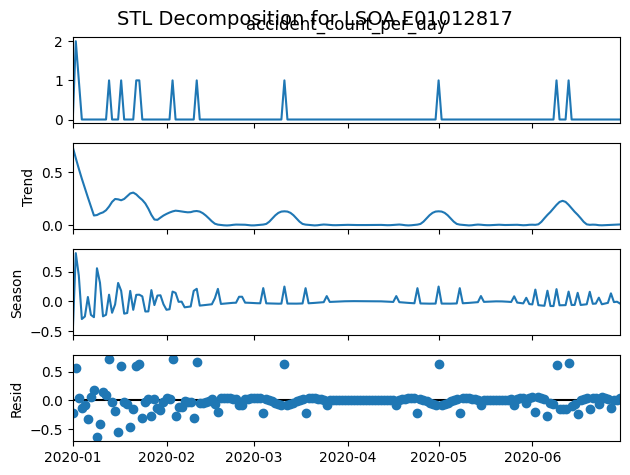

ADF Statistic: -11.5389; p-value: 0.0000
=> Series is stationary. No differencing needed (d=0).

Finding best (p,d,q) order using AIC minimization...


/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

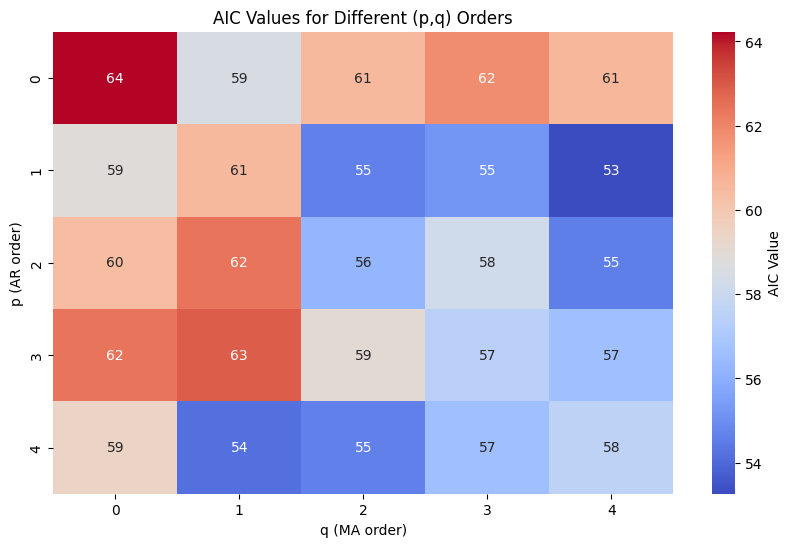

Best order found: (1, 0, 4)

Fitting final SARIMA model...



/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


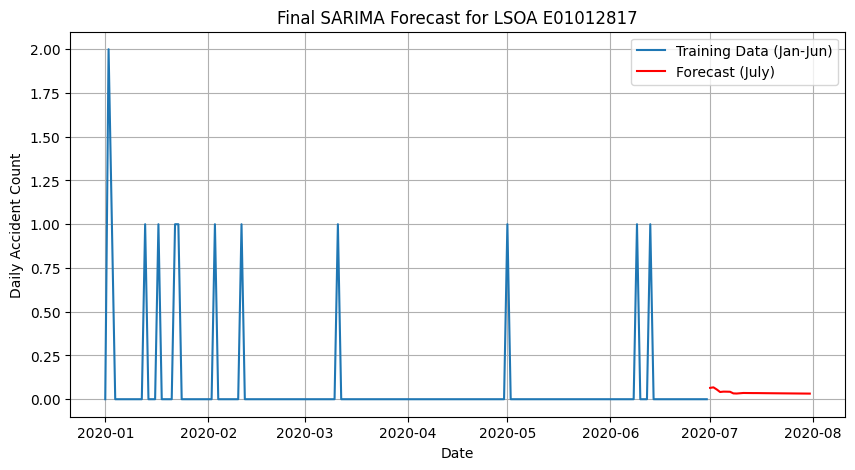


====== LSOA E01012848 ======


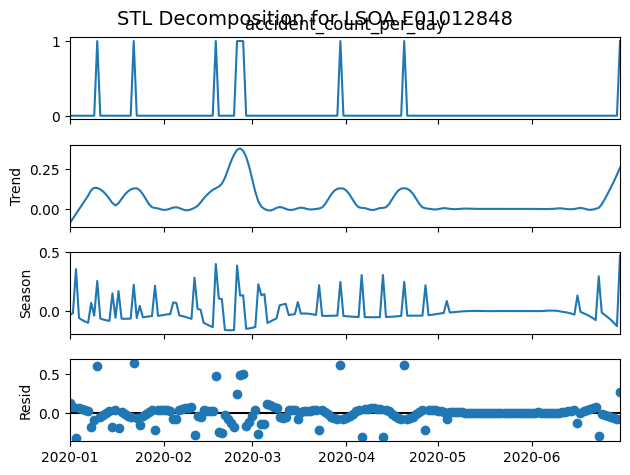

ADF Statistic: -10.2020; p-value: 0.0000
=> Series is stationary. No differencing needed (d=0).

Finding best (p,d,q) order using AIC minimization...


/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zero

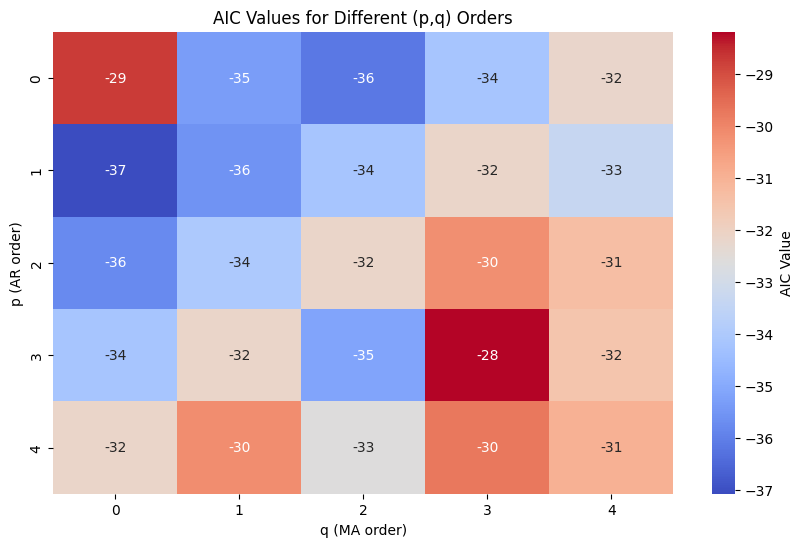

Best order found: (1, 0, 0)

Fitting final SARIMA model...



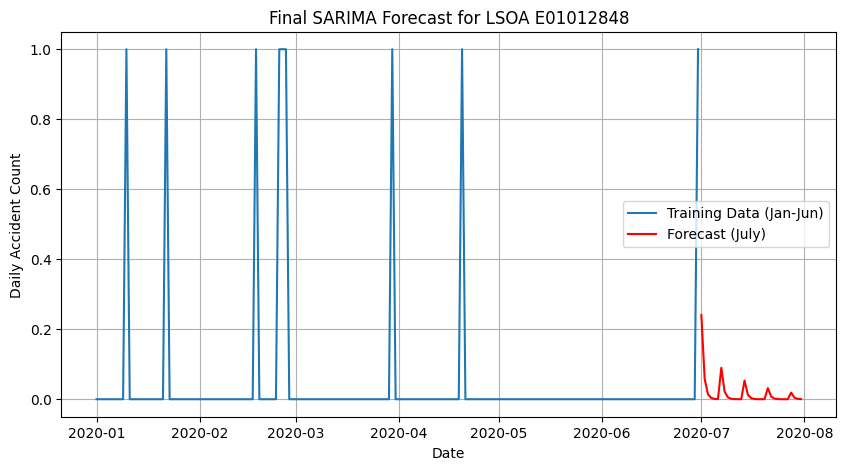


====== LSOA E01012889 ======


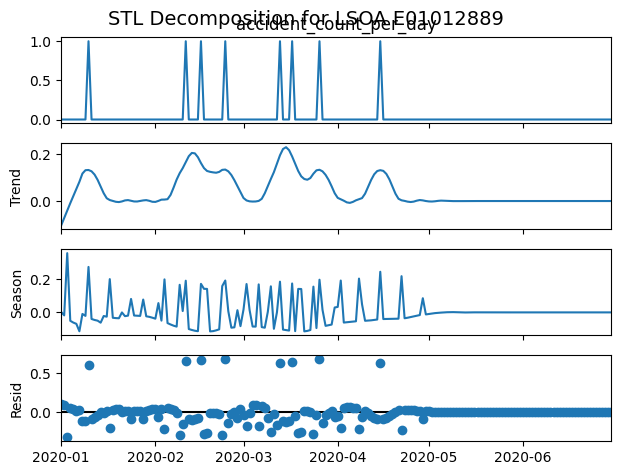

ADF Statistic: -14.0128; p-value: 0.0000
=> Series is stationary. No differencing needed (d=0).

Finding best (p,d,q) order using AIC minimization...


/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters fou

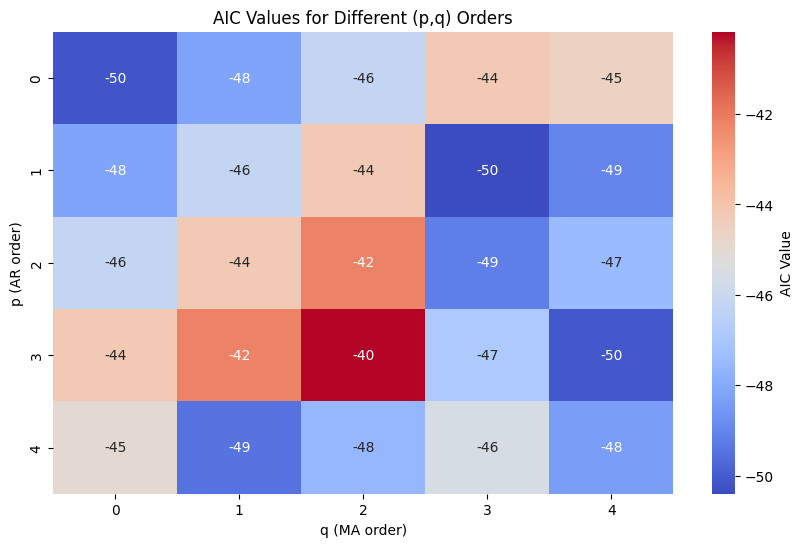

Best order found: (1, 0, 3)

Fitting final SARIMA model...



/Users/dureaqdaskhan/Desktop/langchain/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


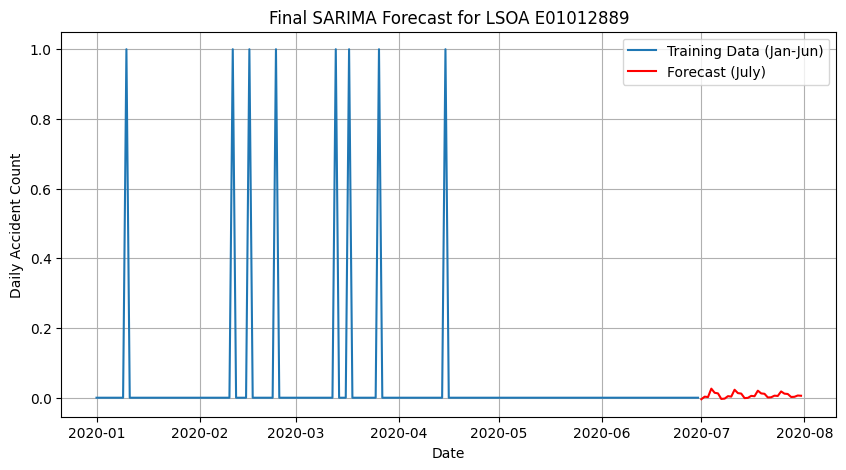

{'E01012817':                  date  predicted_accidents
 2020-07-01 2020-07-01             0.064826
 2020-07-02 2020-07-02             0.067875
 2020-07-03 2020-07-03             0.055763
 2020-07-04 2020-07-04             0.041275
 2020-07-05 2020-07-05             0.043361
 2020-07-06 2020-07-06             0.043127
 2020-07-07 2020-07-07             0.042599
 2020-07-08 2020-07-08             0.033267
 2020-07-09 2020-07-09             0.032594
 2020-07-10 2020-07-10             0.034119
 2020-07-11 2020-07-11             0.035696
 2020-07-12 2020-07-12             0.035460
 2020-07-13 2020-07-13             0.035268
 2020-07-14 2020-07-14             0.035083
 2020-07-15 2020-07-15             0.035059
 2020-07-16 2020-07-16             0.034878
 2020-07-17 2020-07-17             0.034658
 2020-07-18 2020-07-18             0.034438
 2020-07-19 2020-07-19             0.034253
 2020-07-20 2020-07-20             0.034067
 2020-07-21 2020-07-21             0.033883
 2020-07-22 2020-07

In [156]:

# Updated find_best_order function
def find_best_order(train_series):
    ps = range(0, 5)
    qs = range(0, 5)
    p_q_combinations = list(product(ps, qs))
    d = 0  # from ADF test: no differencing needed
    best_aic = np.inf
    best_order = None
    aic_list = []
    
    for p, q in p_q_combinations:
        try:
            model = SARIMAX(train_series, order=(p, d, q))
            results = model.fit(disp=False)
            aic_list.append(((p, d, q), results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue

    aic_df = pd.DataFrame(aic_list, columns=["Order", "AIC"])
    aic_df['p'] = aic_df['Order'].apply(lambda x: x[0])
    aic_df['q'] = aic_df['Order'].apply(lambda x: x[2])

    plt.figure(figsize=(10,6))
    pivot_table = aic_df.pivot(index='p', columns='q', values='AIC')
    sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={'label': 'AIC Value'})
    plt.title("AIC Values for Different (p,q) Orders")
    plt.xlabel("q (MA order)")
    plt.ylabel("p (AR order)")
    plt.show()

    return best_order

# Final process: STL decomposition, ADF test, find best SARIMA order, fit and forecast
forecast_results_final = {}

for lsoa_code, series in lsoa_daily_timeseries.items():
    print(f"\n====== LSOA {lsoa_code} ======")

    # STL Decomposition
    stl = STL(series)
    res = stl.fit()
    res.plot()
    plt.suptitle(f"STL Decomposition for LSOA {lsoa_code}", fontsize=14)
    plt.show()

    # ADF Test
    adf_statistic, p_value = adfuller(series)[:2]
    print(f"ADF Statistic: {adf_statistic:.4f}; p-value: {p_value:.4f}")
    
    # Differencing decision
    if p_value < 0.05:
        d = 0
        print("=> Series is stationary. No differencing needed (d=0).")
    else:
        d = 1
        print("=> Series is non-stationary. Differencing needed (d=1).")

    # Find best order
    print("\nFinding best (p,d,q) order using AIC minimization...")
    best_order = find_best_order(series)
    print(f"Best order found: {best_order}")

    # Fit SARIMA
    print("\nFitting final SARIMA model...\n")
    model = SARIMAX(series, order=best_order, seasonal_order=(1,0,1,7))
    model_fit = model.fit(disp=False)

    # Forecast 31 days ahead (July)
    forecast = model_fit.forecast(steps=31)
    future_dates = pd.date_range('2020-07-01', '2020-07-31')

    # Save forecast
    forecast_df = pd.DataFrame({'date': future_dates, 'predicted_accidents': forecast})
    forecast_results_final[lsoa_code] = forecast_df

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(series.index, series.values, label='Training Data (Jan-Jun)')
    plt.plot(future_dates, forecast.values, color='red', label='Forecast (July)')
    plt.title(f"Final SARIMA Forecast for LSOA {lsoa_code}")
    plt.xlabel('Date')
    plt.ylabel('Daily Accident Count')
    plt.legend()
    plt.grid(True)
    plt.show()

forecast_results_final


## Clustering

In [176]:
query = """
SELECT DISTINCT lsoa.lsoa01nm
FROM accident JOIN lsoa
ON accident.lsoa_of_accident_location=lsoa.lsoa01cd
WHERE accident.police_force = 16
"""
cur.execute(query)

# Fetch the results and print them
regions = cur.fetchall()
for region in regions:
    print(region[0])

Kingston upon Hull 028C
East Riding of Yorkshire 014D
North East Lincolnshire 006B
North Lincolnshire 013A
Kingston upon Hull 029A
North East Lincolnshire 007A
North Lincolnshire 010A
East Riding of Yorkshire 018D
North Lincolnshire 011A
Kingston upon Hull 025E
North Lincolnshire 001D
North Lincolnshire 023A
North Lincolnshire 020D
North East Lincolnshire 016B
East Riding of Yorkshire 024E
North Lincolnshire 019B
East Riding of Yorkshire 009B
Kingston upon Hull 017D
East Riding of Yorkshire 011G
Kingston upon Hull 032B
Kingston upon Hull 002A
East Riding of Yorkshire 024C
Kingston upon Hull 014E
East Riding of Yorkshire 020F
North Lincolnshire 004A
Kingston upon Hull 005C
North East Lincolnshire 005D
Kingston upon Hull 025B
Kingston upon Hull 024A
East Riding of Yorkshire 018E
North East Lincolnshire 023F
East Riding of Yorkshire 034A
East Riding of Yorkshire 018B
Kingston upon Hull 011B
North Lincolnshire 021A
East Riding of Yorkshire 006B
East Riding of Yorkshire 030B
North Lincolnsh

We will target police force 16 as it covers all the regions around Kingston Upon Hull

## step 1 get data from region of interest covering Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc

In [206]:
df_region = accident_data[accident_data['police_force']==16]
df_region

accident_index  accident_year accident_reference  location_easting_osgr  \
37750  2020160914781           2020          160914781               510156.0   
37751  2020160914930           2020          160914930               506050.0   
37752  2020160915008           2020          160915008               497660.0   
37753  2020160915028           2020          160915028               510449.0   
37754  2020160915041           2020          160915041               526236.0   
...              ...            ...                ...                    ...   
39454  2020161014491           2020          161014491               489433.0   
39455  2020161014528           2020          161014528               503756.0   
39456  2020161014544           2020          161014544               511525.0   
39457  2020161014546           2020          161014546               485978.0   
39458  2020161014949           2020          161014949               509443.0   

       location_northing_osgr  longitude   latitude  police_force  \
37750                429221.0  -0.331047  53.747751            16   
37751                428813.0  -0.393424  53.744936            16   
37752                402806.0  -0.528743  53.512895            16   
37753                434112.0  -0.324858  53.791630            16   
37754                410340.0  -0.095008  53.574501            16   
...                       ...        ...        ...           ...   
39454                408637.0  -0.651104  53.566753            16   
39455                439285.0  -0.424674  53.839482            16   
39456                433149.0  -0.308880  53.782750            16   
39457                408912.0  -0.703181  53.569801            16   
39458                428632.0  -0.342063  53.742609            16   

       accident_severity  number_of_vehicles  ...  \
37750                  2                   1  ...   
37751                  3                   2  ...   
37752                  3                   1  ...   
37753                  2                   1  ...   
37754                  3                   1  ...   
...                  ...                 ...  ...   
39454                  3                   2  ...   
39455                  3                   2  ...   
39456                  3                   1  ...   
39457                  3                   2  ...   
39458                  3                   2  ...   

       pedestrian_crossing_physical_facilities light_conditions  \
37750                                        0                4   
37751                                        5                1   
37752                                        0                4   
37753                                        0                4   
37754                                        0                4   
...                                        ...              ...   
39454                                        0                1   
39455                                        0                4   
39456                                        0                1   
39457                                        0                1   
39458                                        0                4   

       weather_conditions road_surface_conditions  special_conditions_at_site  \
37750                   1                       1                           0   
37751                   1                       1                           0   
37752                   1                       1                           0   
37753                   1                       1                           0   
37754                   1                       1                           0   
...                   ...                     ...                         ...   
39454                   1                       1                           0   
39455                   1                       1                           0   
39456                   1        

In [207]:
df_region[['local_authority_district','latitude','longitude']].describe()

local_authority_district     latitude    longitude
count               1709.000000  1709.000000  1709.000000
mean                 230.477472    53.719078    -0.381991
std                    1.948755     0.135850     0.219710
min                  228.000000    53.456614    -1.055770
25%                  228.000000    53.583015    -0.477732
50%                  231.000000    53.743329    -0.358555
75%                  232.000000    53.773967    -0.250808
max                  233.000000    54.143923     0.123813

#### check correlation between Location_Northing_OSGR & Location_Easting_OSGR AND Latitude and Longitude

In [208]:
print(df_region['location_northing_osgr'].corr(df_region['latitude']))
print(df_region['location_easting_osgr'].corr(df_region['longitude']))

0.9997788346284223
0.9997062814401861


## step 2 find the value of k using elbow method

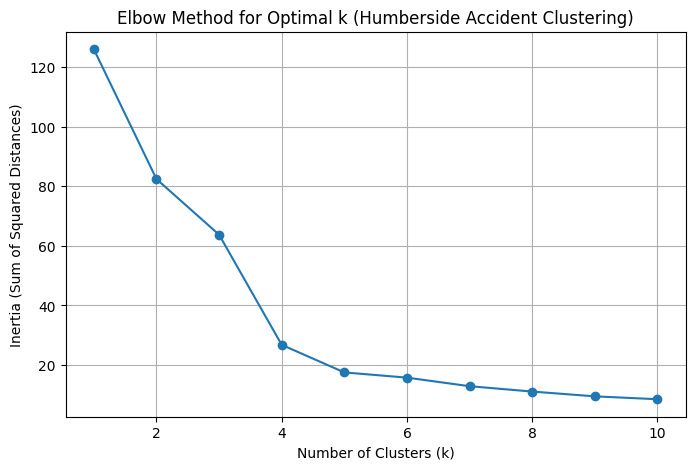

In [209]:
# Step 2: Scale coordinates
scaler = MinMaxScaler()
coords = df_region[['latitude', 'longitude']]
scaled_coords = scaler.fit_transform(coords)

# Step 3: Apply KMeans with different values of k
inertia = []
K = range(1, 11)  # Try cluster counts from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_coords)
    inertia.append(kmeans.inertia_)

# Step 4: Plot the Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k (Humberside Accident Clustering)')
plt.grid(True)
plt.show()


In [213]:
cluster_region_map = {
    0: 'North Lincolnshire',  # You can replace these with actual region names
    1: 'Kingston Upon Hull',
    2: 'East Riding of Yorkshire',
    3: 'North East Lincolnshire'
}

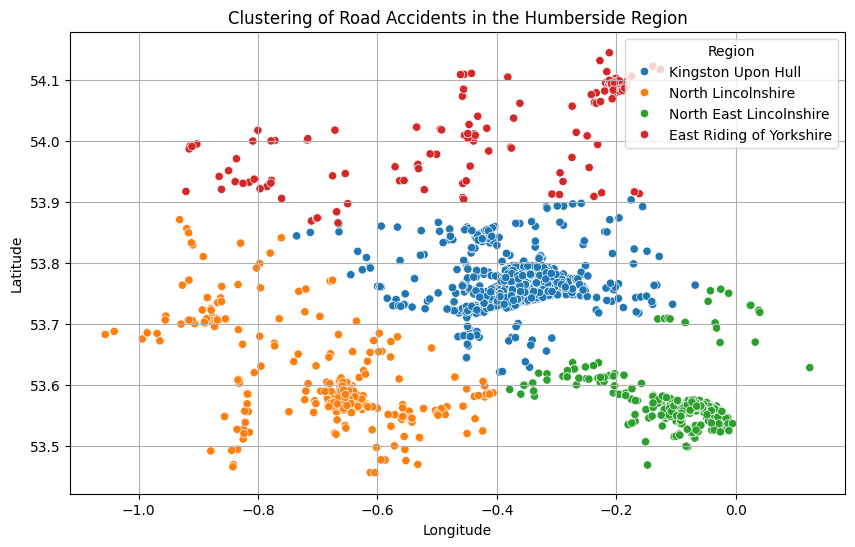

In [218]:


# Scale the lat/lon data
scaler = MinMaxScaler()
coords = df_region[['latitude', 'longitude']]
scaled_coords = scaler.fit_transform(coords)

# using k=3 from elbow method
kmeans = KMeans(n_clusters=4, random_state=42)
df_region.loc[:,'cluster'] = kmeans.fit_predict(scaled_coords)

# Map clusters to region names for hue
df_region.loc[:,'region_name'] = df_region['cluster'].map(cluster_region_map)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_region, x='longitude', y='latitude', hue='region_name', palette='tab10')
plt.title("Clustering of Road Accidents in the Humberside Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(title="Region")
plt.show()


In [211]:


# Calculate the scores
silhouette = silhouette_score(scaled_coords, df_region['cluster'])
db_score = davies_bouldin_score(scaled_coords, df_region['cluster'])

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")


Silhouette Score: 0.622
Davies-Bouldin Score: 0.631


In [212]:
df_region['cluster'].value_counts()


cluster
1    879
3    344
0    330
2    156
Name: count, dtype: int64

## DBSCAN

In [167]:
coords = df_region[['latitude', 'longitude']]
coords

latitude  longitude
37751  53.744936  -0.393424
37753  53.791630  -0.324858
37755  53.767805  -0.327733
37757  53.750410  -0.309102
37758  53.777540  -0.335481
...          ...        ...
39452  53.776745  -0.438783
39453  53.781494  -0.343885
39455  53.839482  -0.424674
39456  53.782750  -0.308880
39458  53.742609  -0.342063

[1057 rows x 2 columns]

/var/folders/38/qw_rrlt93hj2cg5m59k8_4yw0000gq/T/ipykernel_47374/3046803765.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coords['Cluster'] = cluster_labels


db score 1.2741841508166127 s_score 0.04514731984042946


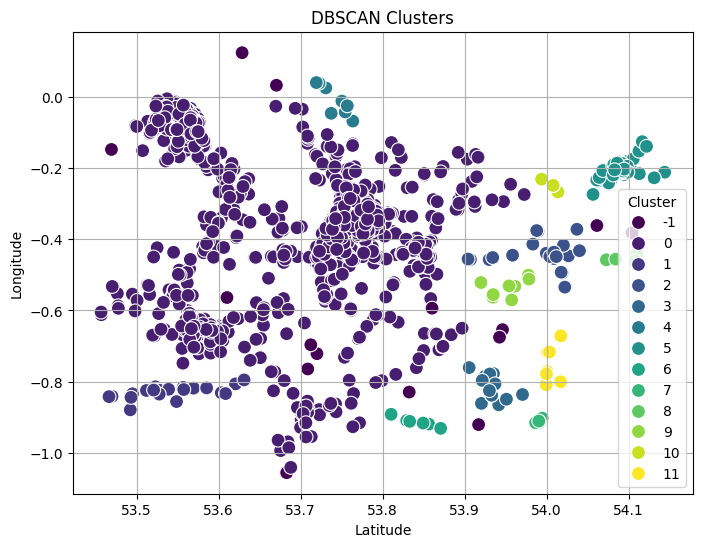

In [188]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(coords)

dbscan = DBSCAN(eps = 0.25, min_samples = 4)
# Apply DBSCAN and predict clusters
cluster_labels = dbscan.fit_predict(scaled_data)

# Add cluster labels to the DataFrame
coords['Cluster'] = cluster_labels
db_score = davies_bouldin_score(scaled_data, cluster_labels)
s_score = silhouette_score(scaled_data, cluster_labels)
print('db score', db_score, 's_score', s_score)
# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=coords,
    x=coords['latitude'],
    y=coords['longitude'],
    hue='Cluster',
    palette='viridis',
    s=100,
    legend="full"
)
plt.title(f"DBSCAN Clusters")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [170]:
cur.close()     
con.close()

Close database connection

# Network

In [69]:
pip install networkx

/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=53772) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 8. Construct a social network using the provided data and visualise the network, then provide the basic network characteristics, including numbers of nodes and edges, network density, average degree.

In [46]:
# Load the dataset
G = nx.read_edgelist('facebook_combined.txt')
G = G.to_undirected()

In [47]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Density of the graph
density = nx.density(G)

# Average degree
degree_dict = dict(G.degree())
avg_degree = sum(degree_dict.values()) / num_nodes

# Display results
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Network Density: {density:.4f}")
print(f"Average Degree: {avg_degree:.2f}")


Number of Nodes: 4039
Number of Edges: 88234
Network Density: 0.0108
Average Degree: 43.69


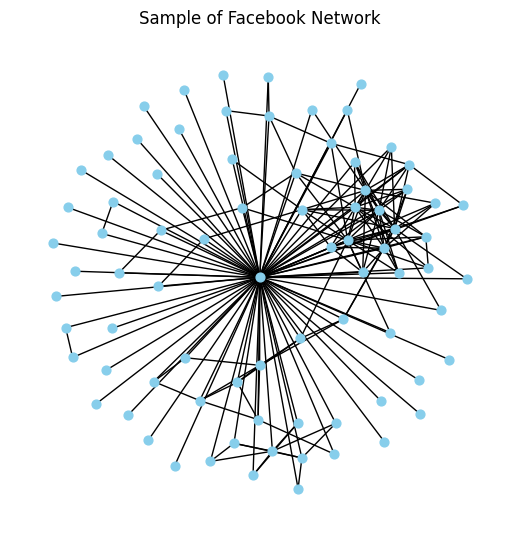

In [838]:
# Draw a sample of 80 nodes only
sample_nodes = list(G.nodes())[:80]
subgraph = G.subgraph(sample_nodes)

plt.figure(figsize=(5, 5))
nx.draw(subgraph, with_labels=False, node_size=40, node_color='skyblue')
plt.title("Sample of Facebook Network")
plt.show()


# 9. Calculate the edge centrality of this network and plot the distribution of the edge centrality values.

In [52]:
# Compute edge centralities on the graph
edge_centrality = nx.edge_betweenness_centrality(G)

In [53]:
edge_centrality

{('0', '1'): 0.00040049937955461345,
 ('0', '2'): 0.0004923848145417046,
 ('0', '3'): 0.0004287786850298508,
 ('0', '4'): 0.000494007105805077,
 ('0', '5'): 0.0004102707367255275,
 ('0', '6'): 0.0004943238949383351,
 ('0', '7'): 0.00038541192817595303,
 ('0', '8'): 0.0004941910478824526,
 ('0', '9'): 0.00036799034834932996,
 ('0', '10'): 0.00042155934476553373,
 ('0', '11'): 0.0004951720722951225,
 ('0', '12'): 0.0004951720722951225,
 ('0', '13'): 0.00038378055161711246,
 ('0', '14'): 0.0004916192164720352,
 ('0', '15'): 0.0004951720722951225,
 ('0', '16'): 0.00048681365670770943,
 ('0', '17'): 0.0004910670496064318,
 ('0', '18'): 0.0004951720722951225,
 ('0', '19'): 0.0004895878244032402,
 ('0', '20'): 0.0004917922582781589,
 ('0', '21'): 0.0003490742281667195,
 ('0', '22'): 0.0004152807378449189,
 ('0', '23'): 0.0004897151239996462,
 ('0', '24'): 0.0004832051553132059,
 ('0', '25'): 0.0003673549680936626,
 ('0', '26'): 0.00036784255714446886,
 ('0', '27'): 0.00042273172334349564,
 ('

In [56]:
# Compute closeness centrality for each node in the subgraph
# Closeness centrality measures how close a node is to all other nodes (shortest paths)
node_closeness = nx.closeness_centrality(G)
# Approximate edge closeness centrality:
# For each edge, take the average of the closeness centralities of its two endpoints
edge_closeness = {
    edge: (node_closeness[edge[0]] + node_closeness[edge[1]]) / 2
    for edge in G.edges()
}
edge_closeness

{('0', '1'): 0.3073594039919486,
 ('0', '2'): 0.30730021555425596,
 ('0', '3'): 0.3073594039919486,
 ('0', '4'): 0.30730021555425596,
 ('0', '5'): 0.307325575461456,
 ('0', '6'): 0.3072664176546473,
 ('0', '7'): 0.3140556558312401,
 ('0', '8'): 0.30728331441801743,
 ('0', '9'): 0.3076986552617916,
 ('0', '10'): 0.30730021555425596,
 ('0', '11'): 0.30722419486638736,
 ('0', '12'): 0.30722419486638736,
 ('0', '13'): 0.3074779419243071,
 ('0', '14'): 0.3073424875372951,
 ('0', '15'): 0.30722419486638736,
 ('0', '16'): 0.3072917644394221,
 ('0', '17'): 0.307325575461456,
 ('0', '18'): 0.30722419486638736,
 ('0', '19'): 0.3073509452171638,
 ('0', '20'): 0.3073424875372951,
 ('0', '21'): 0.31447762665247453,
 ('0', '22'): 0.30730866776273136,
 ('0', '23'): 0.3073594039919486,
 ('0', '24'): 0.3073509452171638,
 ('0', '25'): 0.3078007743668342,
 ('0', '26'): 0.30779225836210633,
 ('0', '27'): 0.30725797091225754,
 ('0', '28'): 0.307325575461456,
 ('0', '29'): 0.307325575461456,
 ('0', '30'): 0

In [62]:
# Compute edge degree centrality:
# For each edge, sum the degrees of its two endpoints (degree = number of connections)
edge_degree = {
    edge: G.degree(edge[0]) + G.degree(edge[1])
    for edge in G.edges()
}
edge_degree

{('0', '1'): 364,
 ('0', '2'): 357,
 ('0', '3'): 364,
 ('0', '4'): 357,
 ('0', '5'): 360,
 ('0', '6'): 353,
 ('0', '7'): 367,
 ('0', '8'): 355,
 ('0', '9'): 404,
 ('0', '10'): 357,
 ('0', '11'): 348,
 ('0', '12'): 348,
 ('0', '13'): 378,
 ('0', '14'): 362,
 ('0', '15'): 348,
 ('0', '16'): 356,
 ('0', '17'): 360,
 ('0', '18'): 348,
 ('0', '19'): 363,
 ('0', '20'): 362,
 ('0', '21'): 412,
 ('0', '22'): 358,
 ('0', '23'): 364,
 ('0', '24'): 363,
 ('0', '25'): 416,
 ('0', '26'): 415,
 ('0', '27'): 352,
 ('0', '28'): 360,
 ('0', '29'): 360,
 ('0', '30'): 364,
 ('0', '31'): 370,
 ('0', '32'): 353,
 ('0', '33'): 349,
 ('0', '34'): 352,
 ('0', '35'): 349,
 ('0', '36'): 358,
 ('0', '37'): 348,
 ('0', '38'): 356,
 ('0', '39'): 362,
 ('0', '40'): 391,
 ('0', '41'): 371,
 ('0', '42'): 349,
 ('0', '43'): 348,
 ('0', '44'): 353,
 ('0', '45'): 359,
 ('0', '46'): 352,
 ('0', '47'): 349,
 ('0', '48'): 369,
 ('0', '49'): 351,
 ('0', '50'): 358,
 ('0', '51'): 354,
 ('0', '52'): 349,
 ('0', '53'): 378,
 (

In [58]:
# Plotting histograms
def plot_distribution(data, title, xlabel, color):
    plt.figure(figsize=(10, 6))
    plt.hist(list(data.values()), bins=50, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


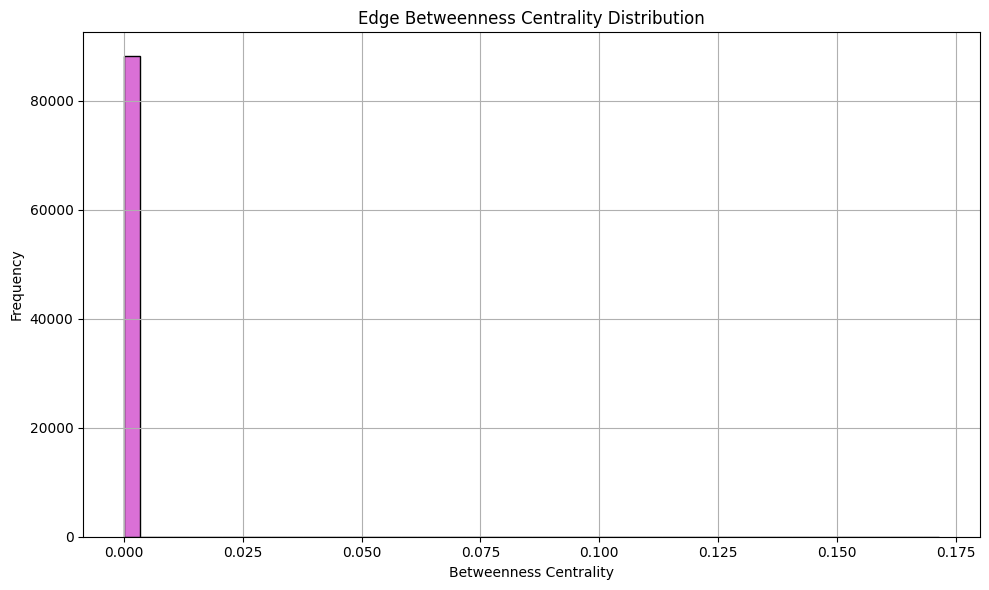

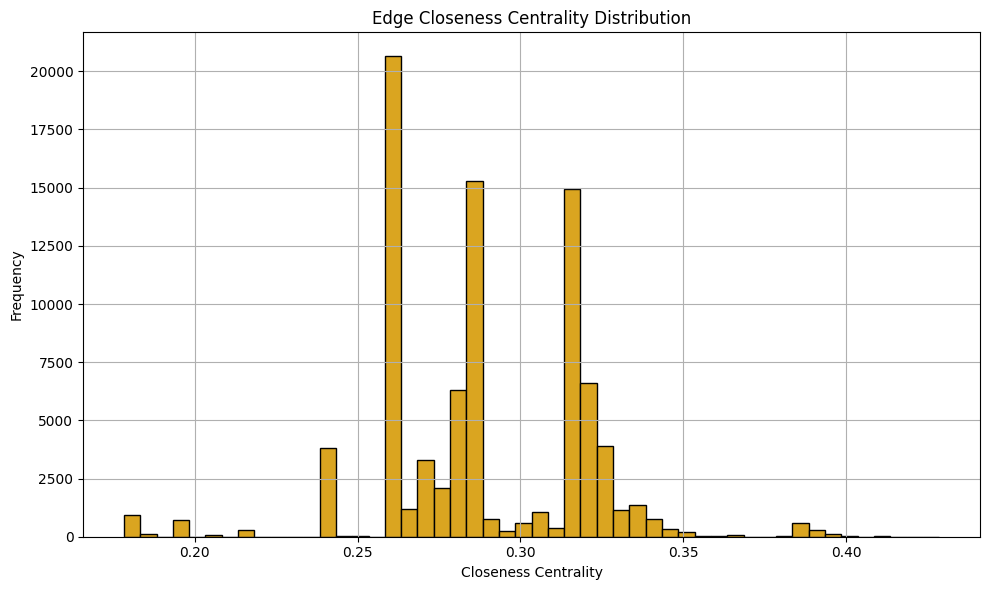

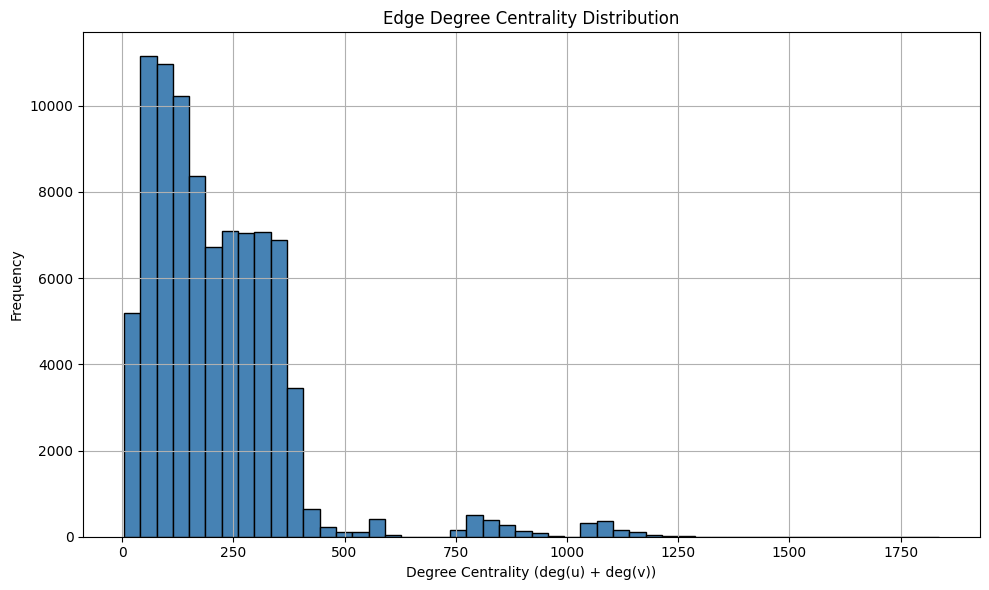

In [64]:
plot_distribution(edge_centrality, "Edge Betweenness Centrality Distribution", "Betweenness Centrality", "orchid")
plot_distribution(edge_closeness, "Edge Closeness Centrality Distribution", "Closeness Centrality", "goldenrod")
plot_distribution(edge_degree, "Edge Degree Centrality Distribution", "Degree Centrality (deg(u) + deg(v))", "steelblue")

## 10. Use two community detection algorithms to detect the clusters/community within this social network, then compare the difference of results (the number of clusters and numbers of nodes in each cluster).

In [839]:
# two algorithms we'll use
algorithms = [ "Louvain Modularity", "Label Propagation" ]

In [840]:
# Dictionary to store communities detected by each algorithm
detected_communities = {}

In [841]:
# Apply each community detection algorithm and store the detected communities
for algorithm in algorithms:
    if algorithm == "Louvain Modularity":
        communities = nx.algorithms.community.greedy_modularity_communities(G)
    elif algorithm == "Label Propagation":
        communities = nx.algorithms.community.label_propagation_communities(G)
    detected_communities[algorithm] = communities
print ('community detection done')

community detection done


In [842]:
# Evaluate and compare the results
for algorithm, communities in detected_communities.items():
    modularity = nx.algorithms.community.modularity(G, communities)
    num_communities = len(communities)
    average_community_size = sum(len(community) for community in communities) / num_communities
    print(f"{algorithm}:")
    print(f"Modularity: {modularity}")
    print(f"Number of Communities: {num_communities}")
    print(f"Average Community Size: {average_community_size}\n")

Louvain Modularity:
Modularity: 0.774528750046725
Number of Communities: 16
Average Community Size: 252.4375

Label Propagation:
Modularity: 0.7368407345348215
Number of Communities: 44
Average Community Size: 91.79545454545455



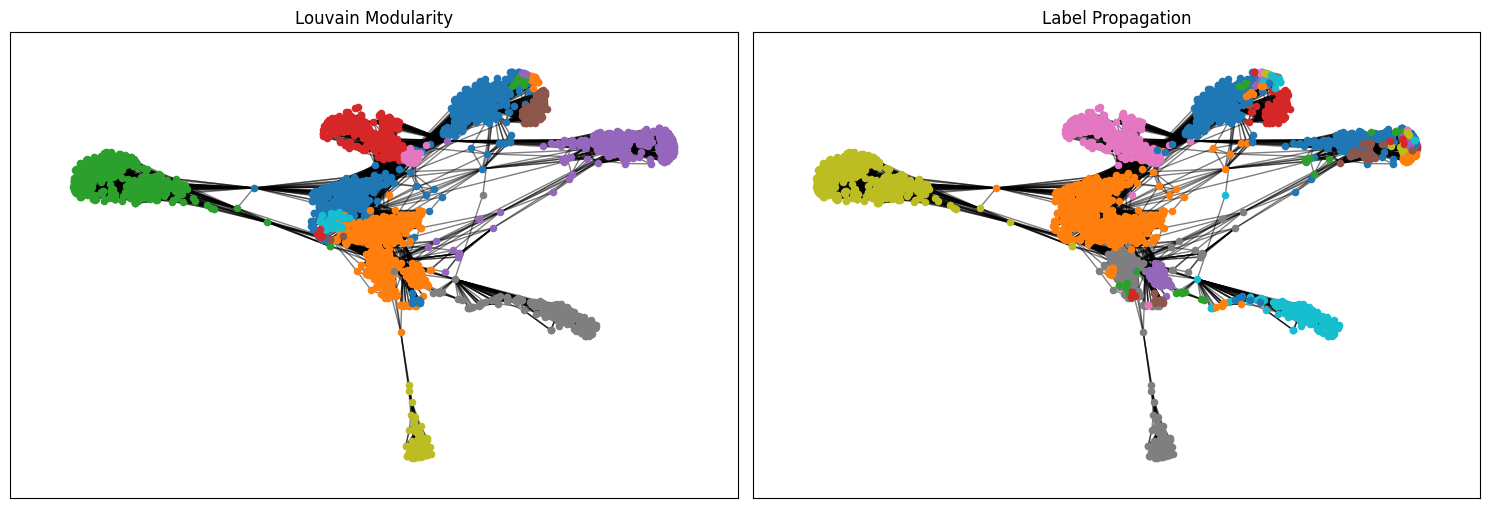

In [845]:
# Visualize community structures
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G)  # layout for consistent node placement
for i, (algorithm, communities) in enumerate(detected_communities.items()):
    plt.subplot(2, 2, i+1)
    colors = [f'C{i}' for i in range(len(communities))]  # assign unique colors
    for j, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[j], node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(algorithm)
plt.tight_layout()
plt.show()
